# Label distribution plotting
Visualising what the model has predicted given a raw dataset.

In [1]:
import os

notebook_mode: int = int(
    input(
        """
    Select notebook mode: 
    1. Google Colab  2. Local
    """
    )
)

if notebook_mode == 1:
    # Run on Colab.
    INPUT_PATH: str = "/content/drive/MyDrive/Ellinbank/video_observation/data/"
    SCRIPT_PATH: str = (
        "/content/drive/MyDrive/Ellinbank/video_observation/training_testing/data_labelling/"
    )
    OUTPUT_PATH: str = "/content/drive/MyDrive/Ellinbank/video_observation/output/"
    os.system(command="cp {}custom_model.py .".format(SCRIPT_PATH))
    os.system(command="cp {}inference.py .".format(SCRIPT_PATH))
    os.system(command="cp {}utils.py .".format(SCRIPT_PATH))
    os.system(command="cp {}operation.py .".format(SCRIPT_PATH))
elif notebook_mode == 2:
    INPUT_PATH: str = "../../../../data/"
    SCRIPT_PATH: str = "./"
    OUTPUT_PATH: str = "./out/"

In [2]:
sensor_dirs: list[int] = [
    d
    for d in os.listdir(path=INPUT_PATH)
    if os.path.isdir(s=os.path.join(INPUT_PATH, d)) and d.startswith("MOS")
]

print(sensor_dirs)

['MOS2E03230475', 'MOS2E03230488', 'MOS2E03230532', 'MOS2E03230539', 'MOS2E03230553', 'MOS2E03230561', 'MOS2E03230576', 'MOS2E03230586']


In [3]:
import numpy
import pandas
from utils import plot_distributions


def multiday_plotter(
    daily_sensor_df: list[pandas.DataFrame] = [],
    sensor_name: str = "",
) -> None:
    behaviours: numpy.ndarray = daily_sensor_df[0]["predicted_labels"]
    counts: numpy.ndarray = round(daily_sensor_df[0]["counts"], 2)
    percentages: numpy.ndarray = round(counts / counts.sum() * 100, 2)
    plot_distributions(
        labels=behaviours,
        counts=counts,
        percentages=percentages,
        plot_title="{}_Total_time".format(sensor_name),
        xlabel_bar="Behaviour",
        ylabel_bar="Total time (Min)",
    )
    print("plotted")
    for df in daily_sensor_df[1:]:
        behaviours: numpy.ndarray = df["predicted_labels"]
        counts: numpy.ndarray = round(df["counts"], 2)
        percentages: numpy.ndarray = round(counts / counts.sum() * 100, 2)
        plot_distributions(
            labels=behaviours,
            counts=counts,
            percentages=percentages,
            plot_title="{}_Total_time: {}".format(
                sensor_name,
                df["timestamps"].iloc[0],
            ),
            xlabel_bar="Behaviour",
            ylabel_bar="Total time (Min)",
        )

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()
INPUT_PATH: str = os.environ["INPUT_PATH"]
SCRIPT_PATH: str = os.environ["SCRIPT_PATH"]
OUTPUT_PATH: str = os.environ["OUTPUT_PATH"]

DATA_PATH: str = os.path.abspath(path="{}".format(INPUT_PATH))
OUTPUT_PATH = os.path.abspath(OUTPUT_PATH)

files: list[str] = os.listdir(path=DATA_PATH)
input_files: list[str] = ["{}/{}".format(DATA_PATH, file) for file in files]

import logging

logging.basicConfig(
    format="%(levelname)s: %(message)s",
)

In [2]:
input_files

['/mnt/disk1/Ellinbank/AnalyticOutputs/parquet_output/MOS2E03230475_30Hz_proc.parquet',
 '/mnt/disk1/Ellinbank/AnalyticOutputs/parquet_output/MOS2E03230488_30Hz_proc.parquet',
 '/mnt/disk1/Ellinbank/AnalyticOutputs/parquet_output/MOS2E03230532_30Hz_proc.parquet']

In [13]:
import gc
import pandas

sensor_data: list[list[pandas.DataFrame]] = []
dated_df: list[pandas.DataFrame] = []
for f in input_files:
    current_sensor: str = os.path.basename(p=f).split(sep="_")[0]
    sensor_path: str = "{}/{}".format(OUTPUT_PATH, current_sensor)

    files: list[str] = os.listdir(path=sensor_path)
    file: str = ["{}/{}".format(sensor_path, f) for f in files if f.endswith(".csv")][0]
    print(file)
    dated_df.clear()

    df: pandas.DataFrame = pandas.read_csv(
        filepath_or_buffer=file,
        # nrows=10,
    )
    timestamps: pandas.DatetimeIndex = pandas.DatetimeIndex(df["timestamps"])
    days: pandas.Series = timestamps.date
    df["timestamps"] = days
    unique_days: list = list(df["timestamps"].unique())

    # 30 records = 1 second.
    labels: pandas.DataFrame = df.groupby(by=["predicted_labels"]).count().reset_index()
    labels = labels.rename(
        columns={labels.columns[-1]: "counts (mins)"},
        inplace=False,
    )
    labels[labels.columns[-1]] = labels[labels.columns[-1]] / (30 * 60)
    dated_df.append(labels)

    daily_labels: pandas.DataFrame = (
        df.groupby(by=["timestamps", "predicted_labels"]).size().reset_index()
    )
    daily_labels = daily_labels.rename(
        columns={daily_labels.columns[-1]: "counts (mins)"},
        inplace=False,
    )
    daily_labels["counts (mins)"] = daily_labels["counts (mins)"] / (30 * 60)

    for day in unique_days:
        d_df: pandas.DataFrame = daily_labels.loc[daily_labels["timestamps"] == day]
        dated_df.append(d_df)

    # sensor_data.append(dated_df)
    # multiday_plotter(
    #     daily_sensor_df=dated_df,
    #     sensor_name=file.split("_")[0],
    # )
    labels.to_csv(
        path_or_buf="{}/{}_total-count.csv".format(sensor_path, current_sensor),
        sep=",",
        index=False,
    )
    daily_labels.to_csv(
        path_or_buf="{}/{}_count-by-day.csv".format(sensor_path, current_sensor),
        sep=",",
        index=False,
    )
    gc.collect()
    # break

len(sensor_data)

/mnt/disk1/Ellinbank/AnalyticOutputs/prediction_output/MOS2E03230475/MOS2E03230475_timestamp-label.csv
/mnt/disk1/Ellinbank/AnalyticOutputs/prediction_output/MOS2E03230488/MOS2E03230488_timestamp-label.csv
/mnt/disk1/Ellinbank/AnalyticOutputs/prediction_output/MOS2E03230532/MOS2E03230532_timestamp-label.csv


0

In [9]:
labels

predicted_labels        counts
0                g  10288.577778
1                i   2675.102222
2                o    809.750000
3                r    344.570000

In [8]:
daily_labels

timestamps predicted_labels       counts
0   2023-04-14                g    93.101111
1   2023-04-14                i   106.572222
2   2023-04-14                o    20.830000
3   2023-04-14                r   138.480000
4   2023-04-15                g  1048.113333
5   2023-04-15                i   250.629444
6   2023-04-15                o    51.692222
7   2023-04-15                r    89.565000
8   2023-04-16                g  1149.691667
9   2023-04-16                i   165.091667
10  2023-04-16                o    78.153333
11  2023-04-16                r    47.063333
12  2023-04-17                g  1107.191667
13  2023-04-17                i   164.578333
14  2023-04-17                o   168.138889
15  2023-04-17                r     0.091111
16  2023-04-18                g   821.762222
17  2023-04-18                i   528.478333
18  2023-04-18                o    21.062222
19  2023-04-18                r    68.697222
20  2023-04-19                g  1360.942222
21  2023-04-19                i    67.660000
22  2023-04-19                o    11.250000
23  2023-04-19                r     0.147778
24  2023-04-20                g  1264.261111
25  2023-04-20                i    77.343889
26  2023-04-20                o    98.041111
27  2023-04-20                r     0.353889
28  2023-04-21                g   714.949444
29  2023-04-21                i   530.795000
30  2023-04-21                o   194.218889
31  2023-04-21                r     0.036667
32  2023-04-22                g  1186.901111
33  2023-04-22                i   127.773333
34  2023-04-22                o   125.222778
35  2023-04-22                r     0.102778
36  2023-04-23                g   803.383889
37  2023-04-23                i   596.662778
38  2023-04-23                o    39.922778
39  2023-04-23                r     0.030556
40  2023-04-24                g   738.280000
41  2023-04-24                i    59.517222
42  2023-04-24                o     1.217778
43  2023-04-24                r     0.001667

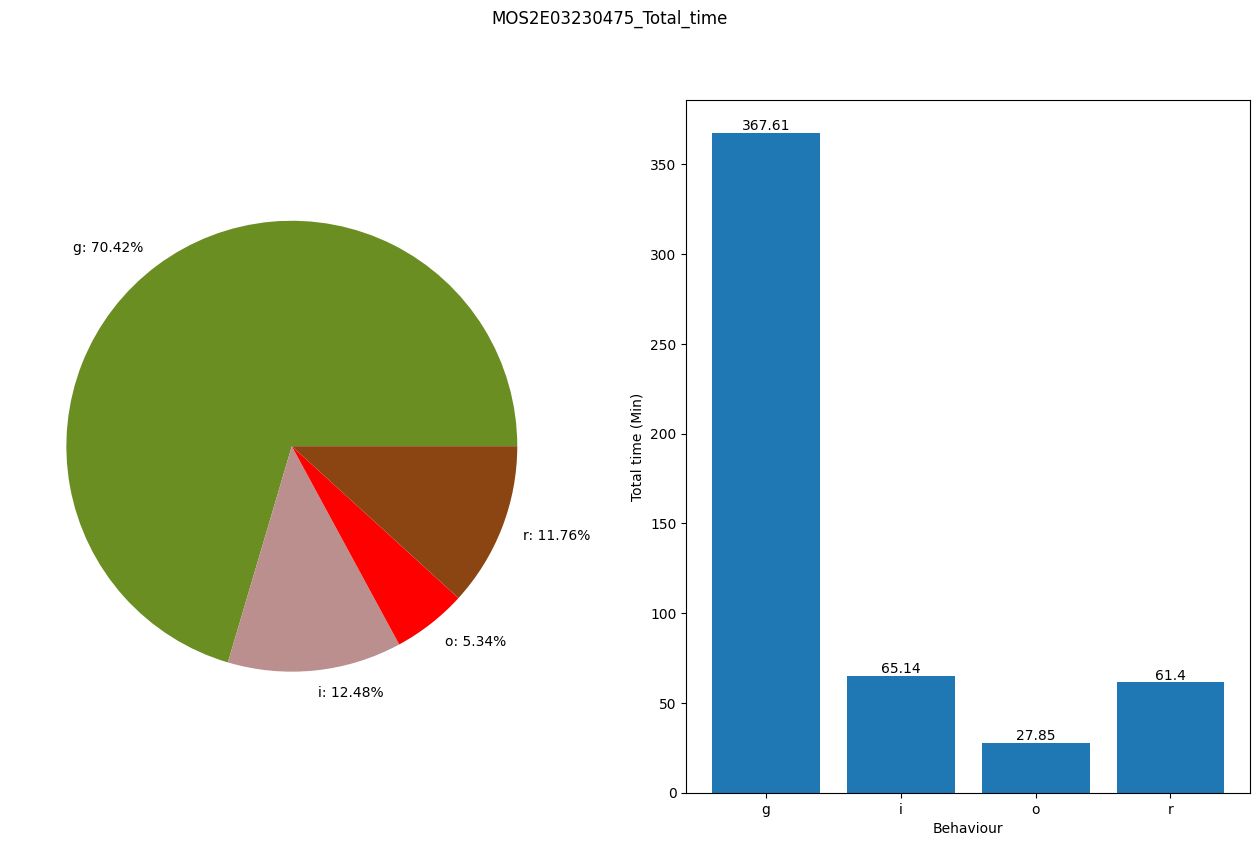

plotted


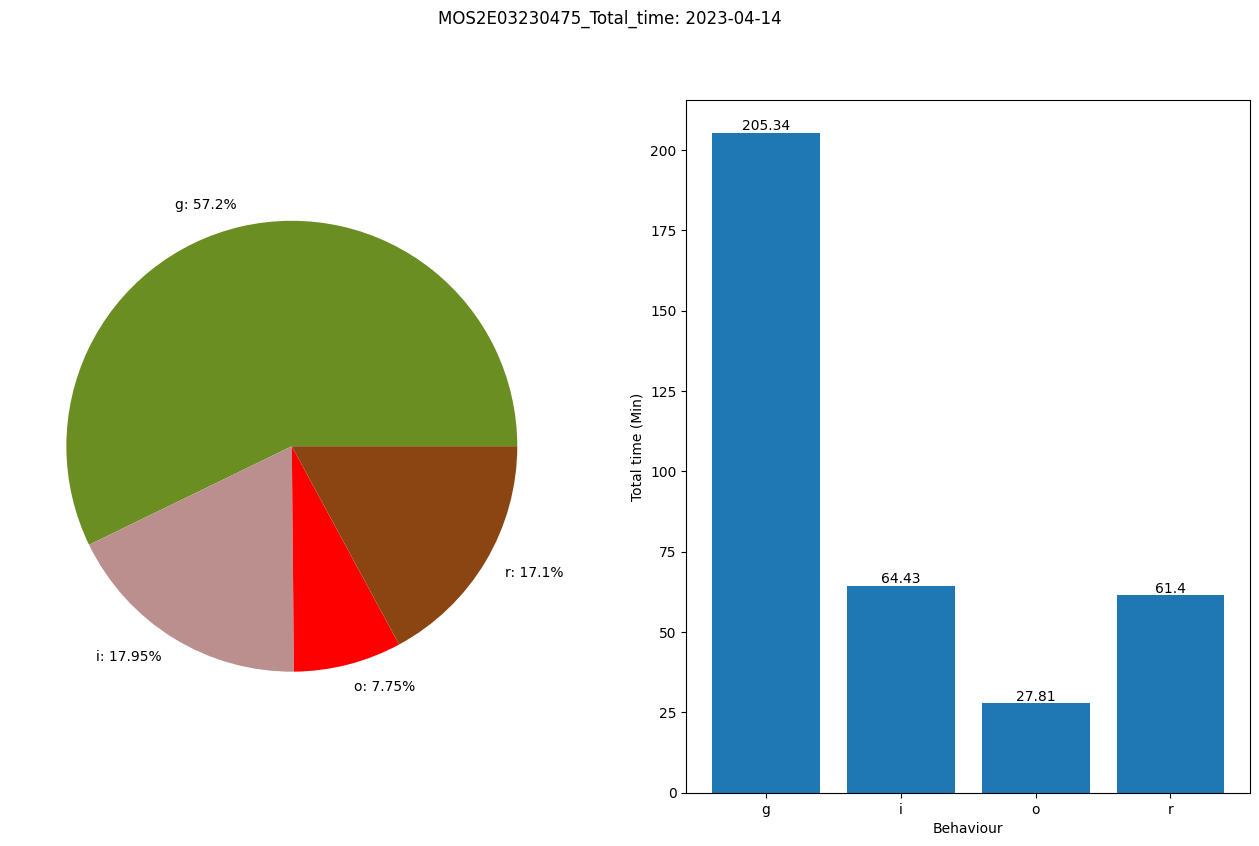

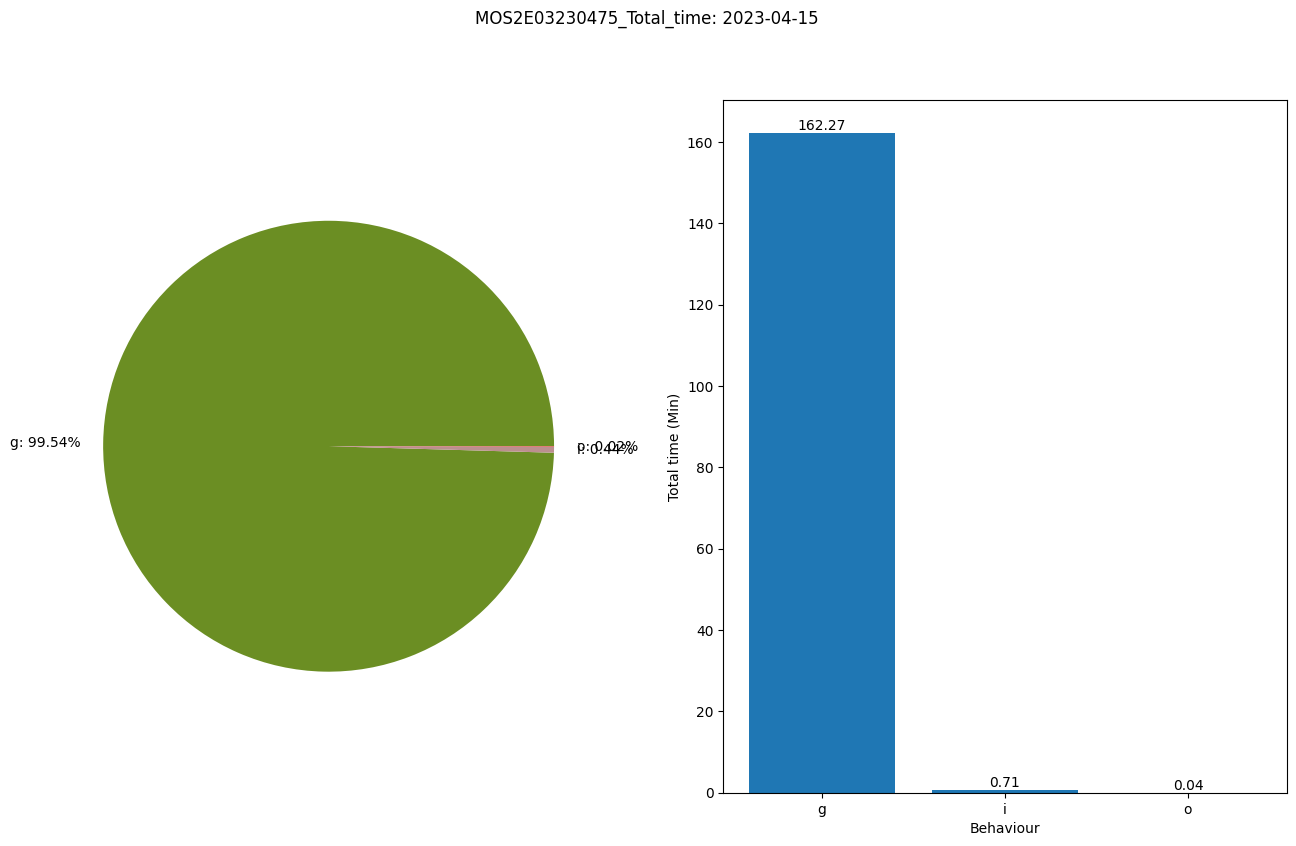

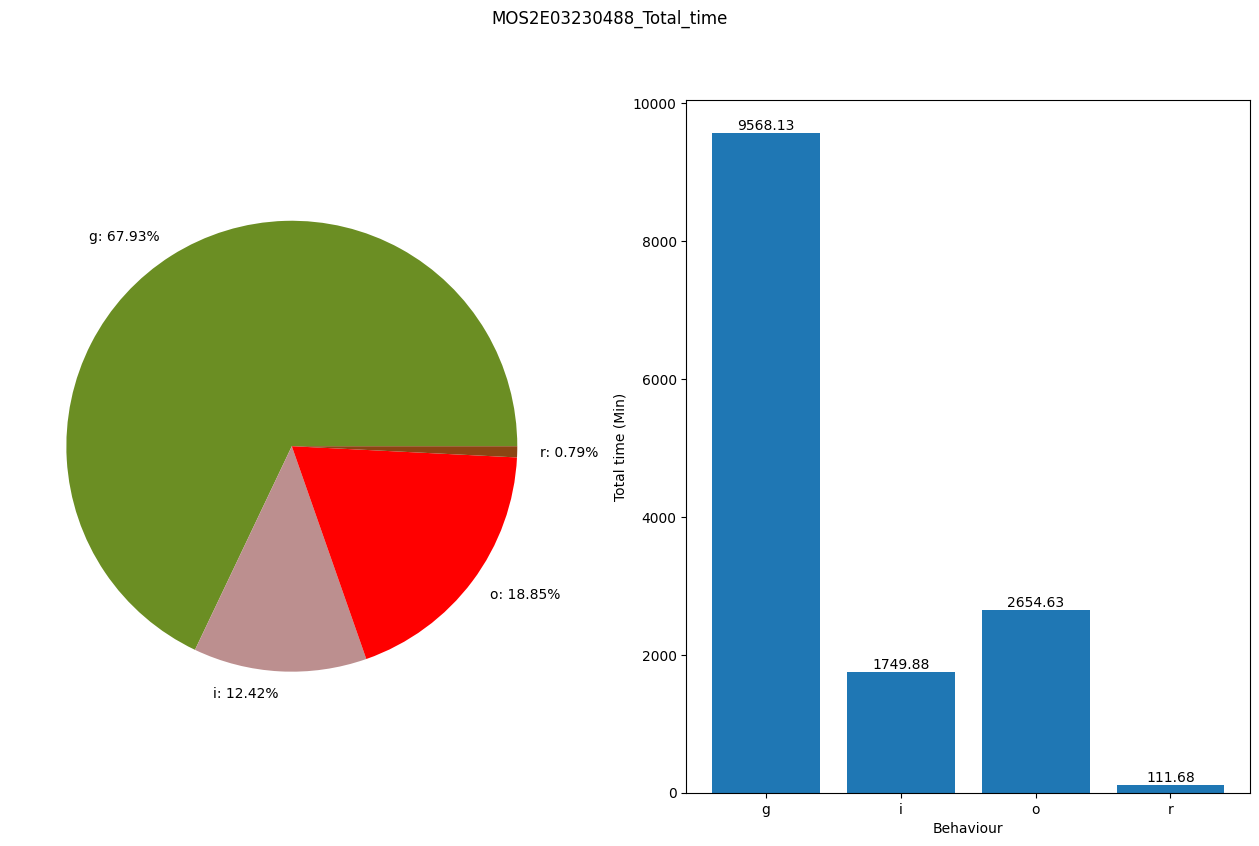

plotted


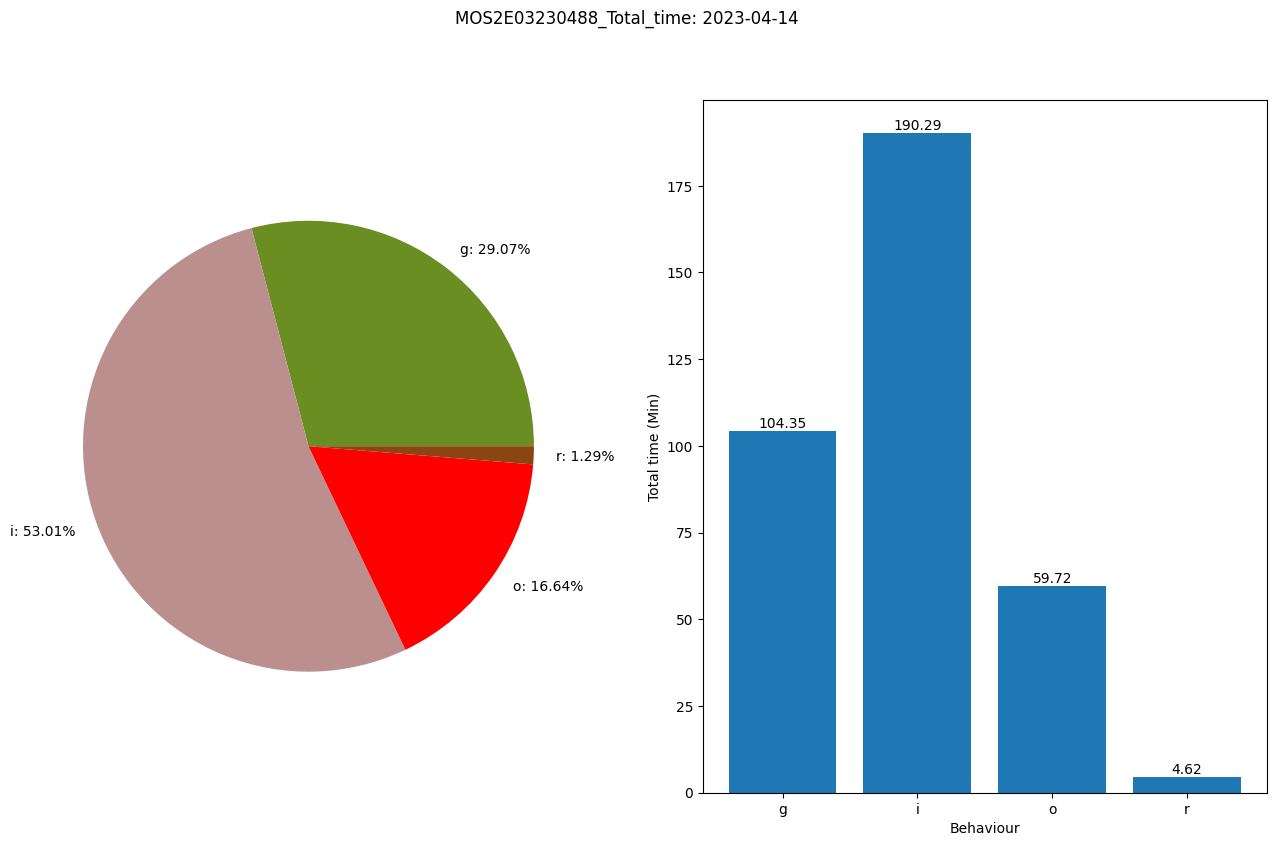

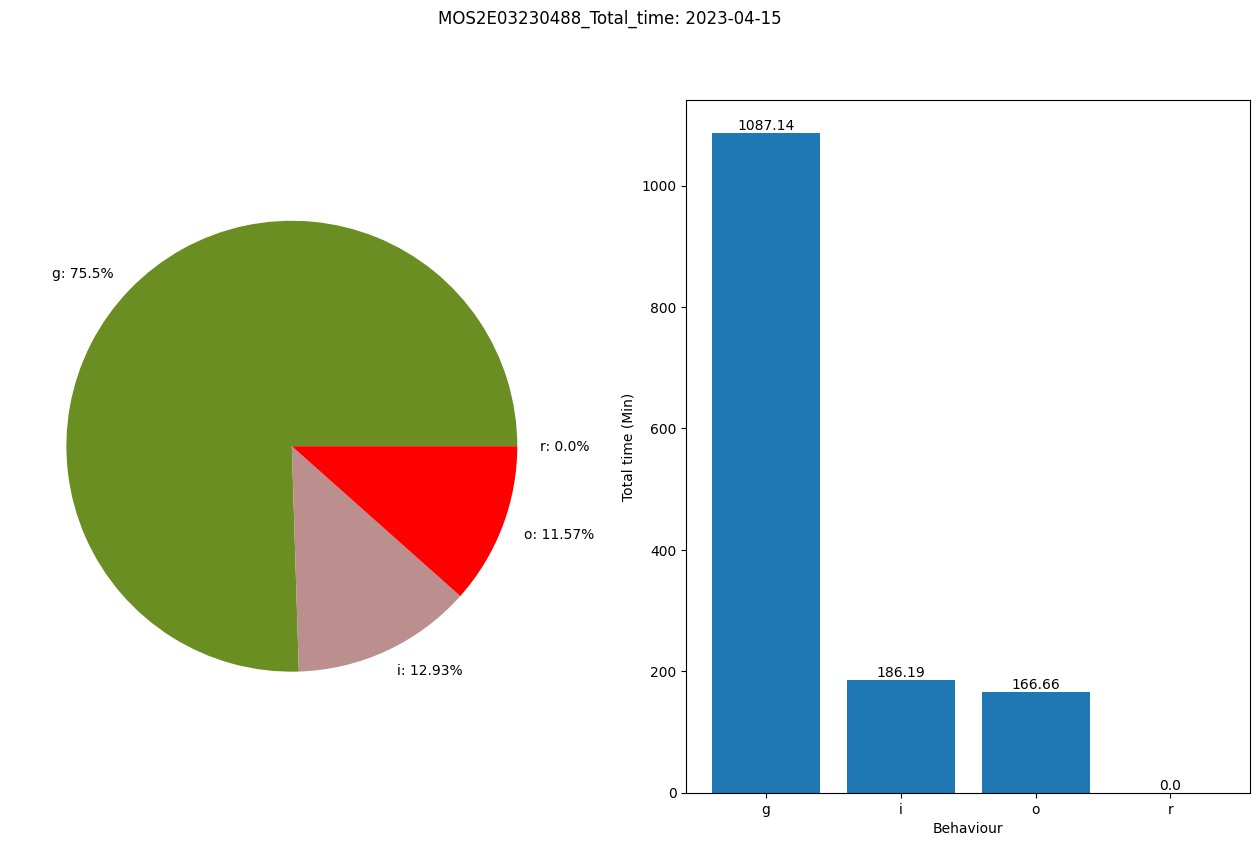

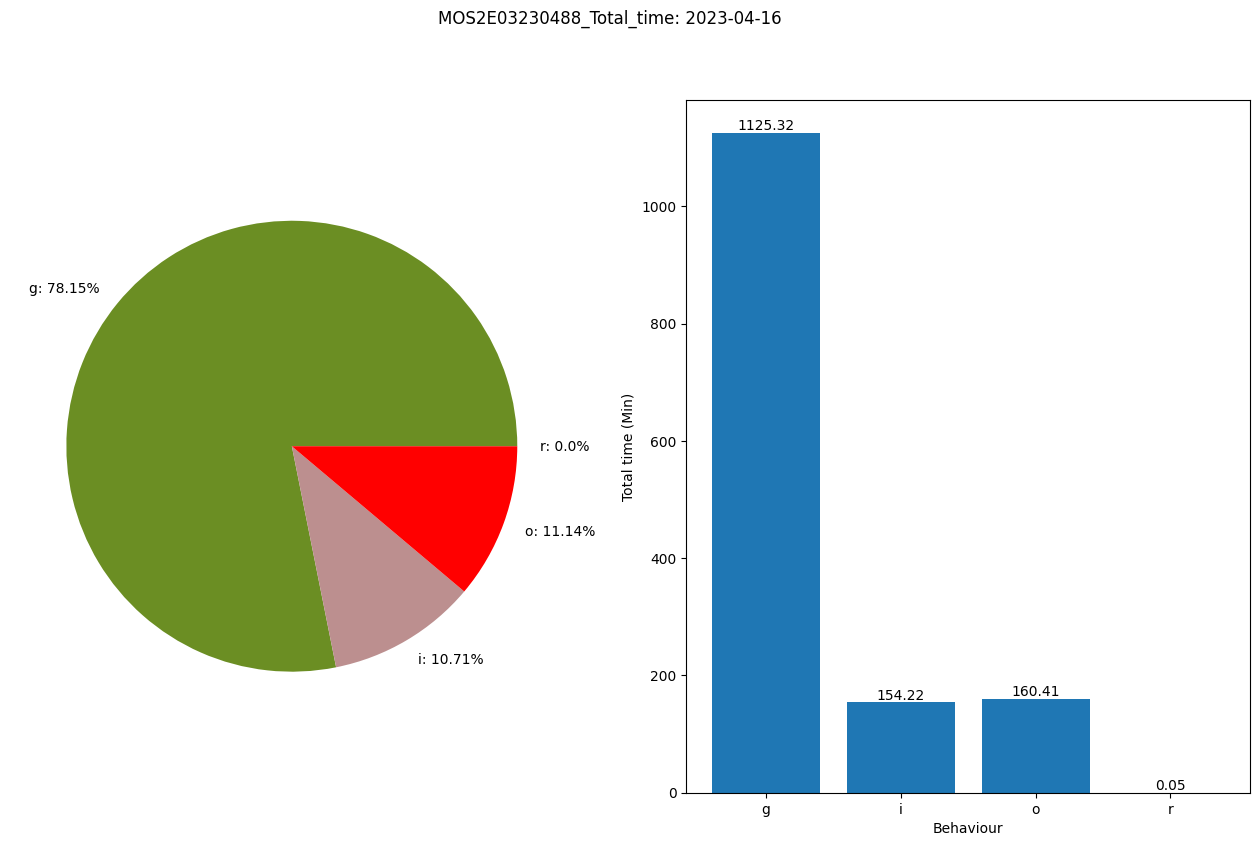

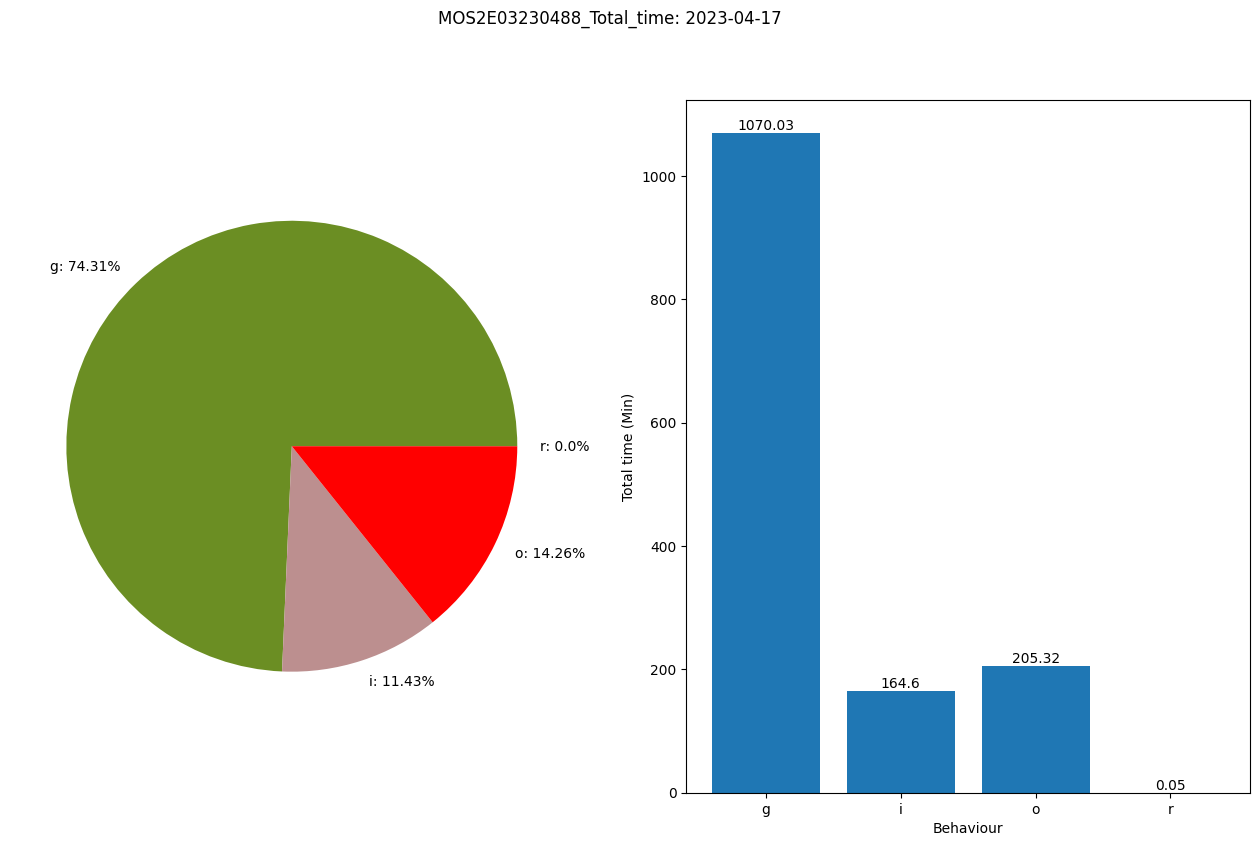

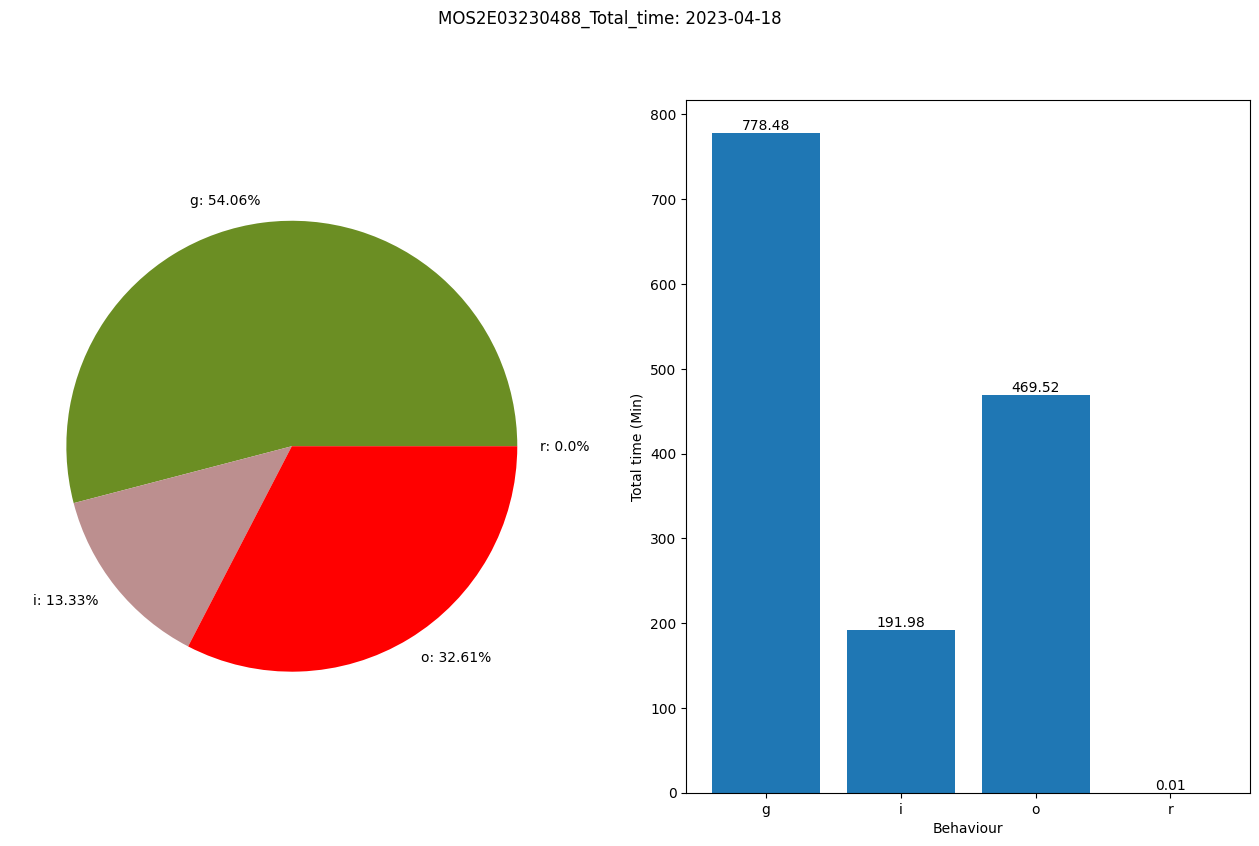

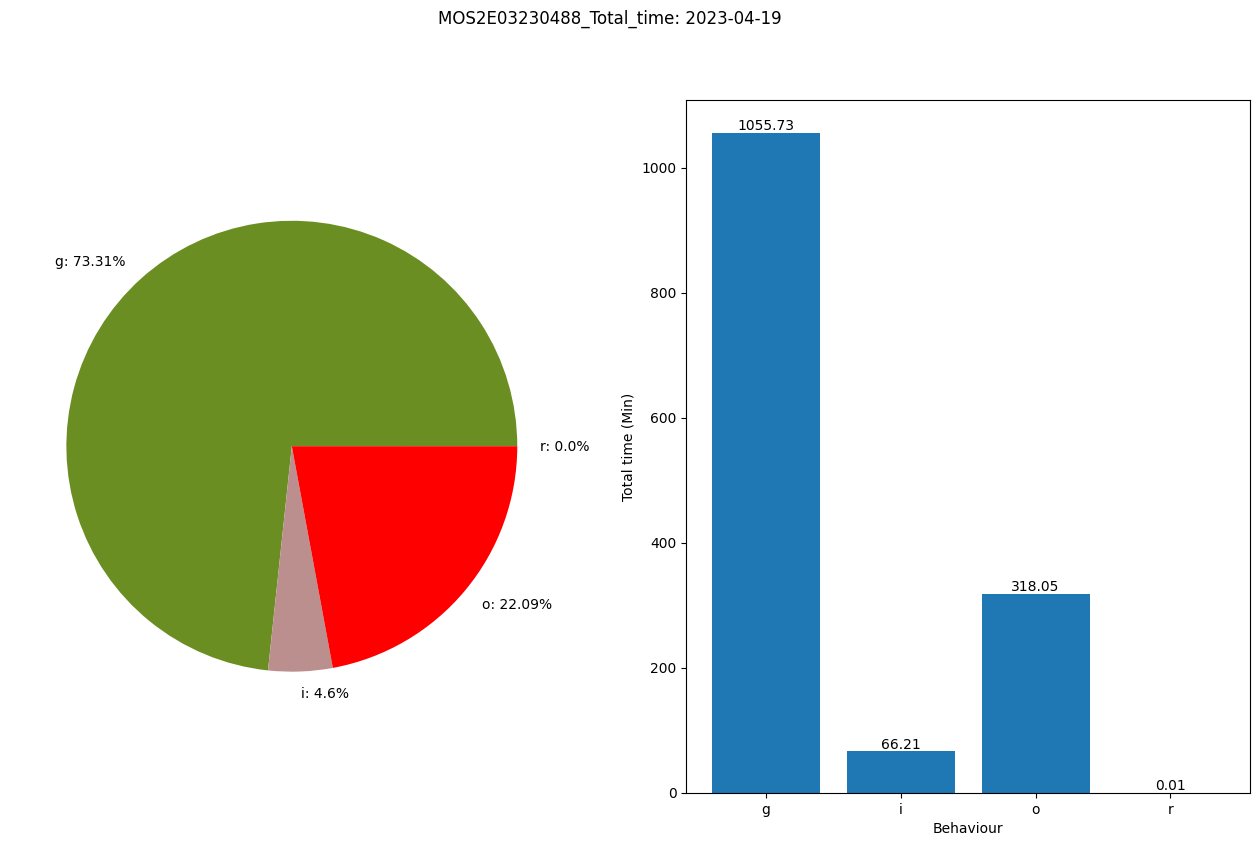

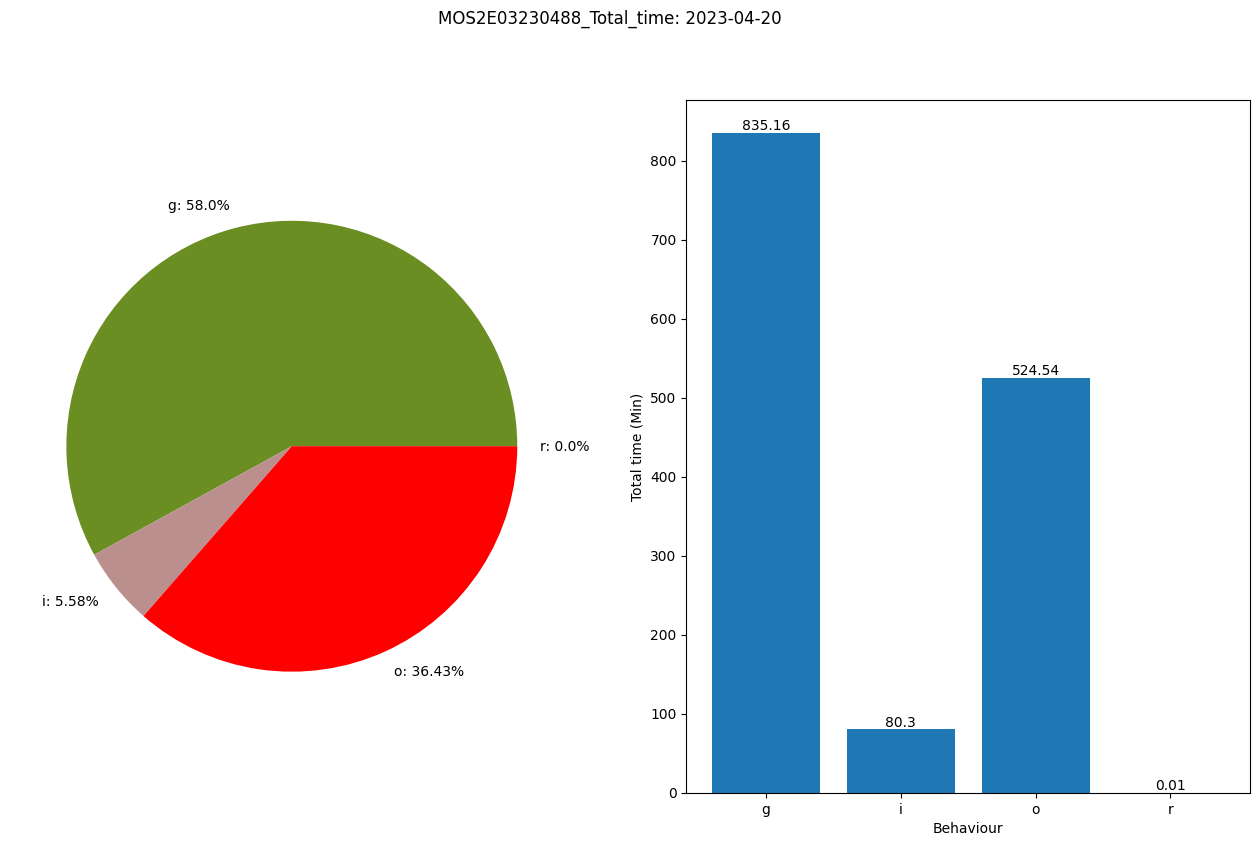

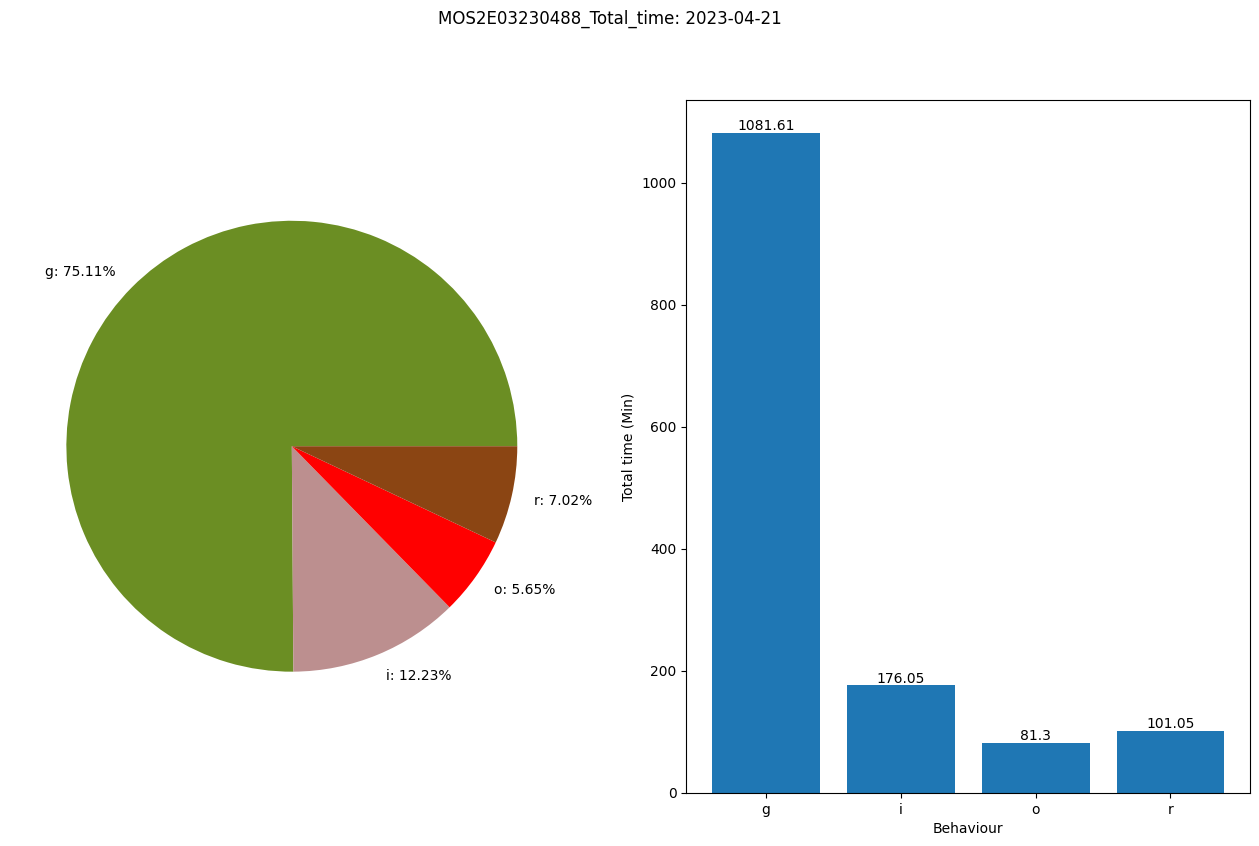

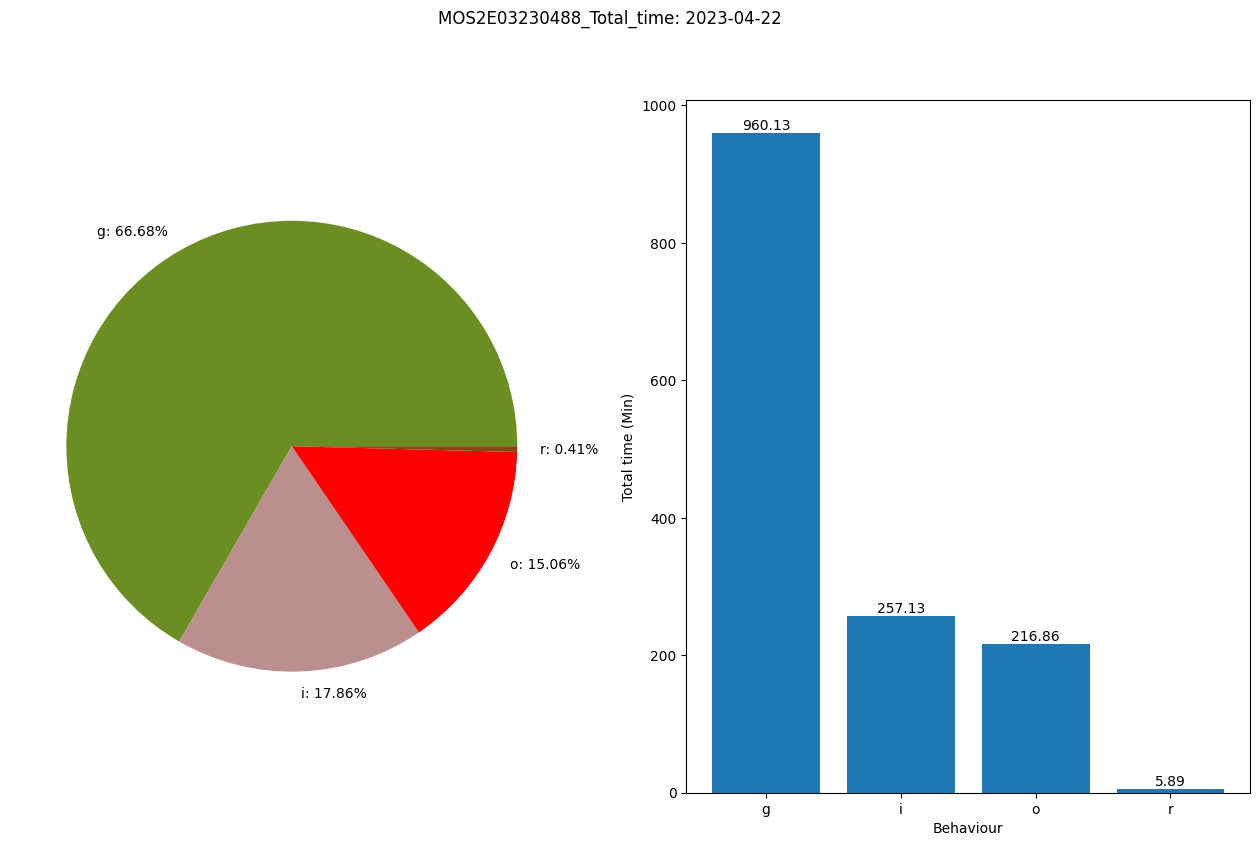

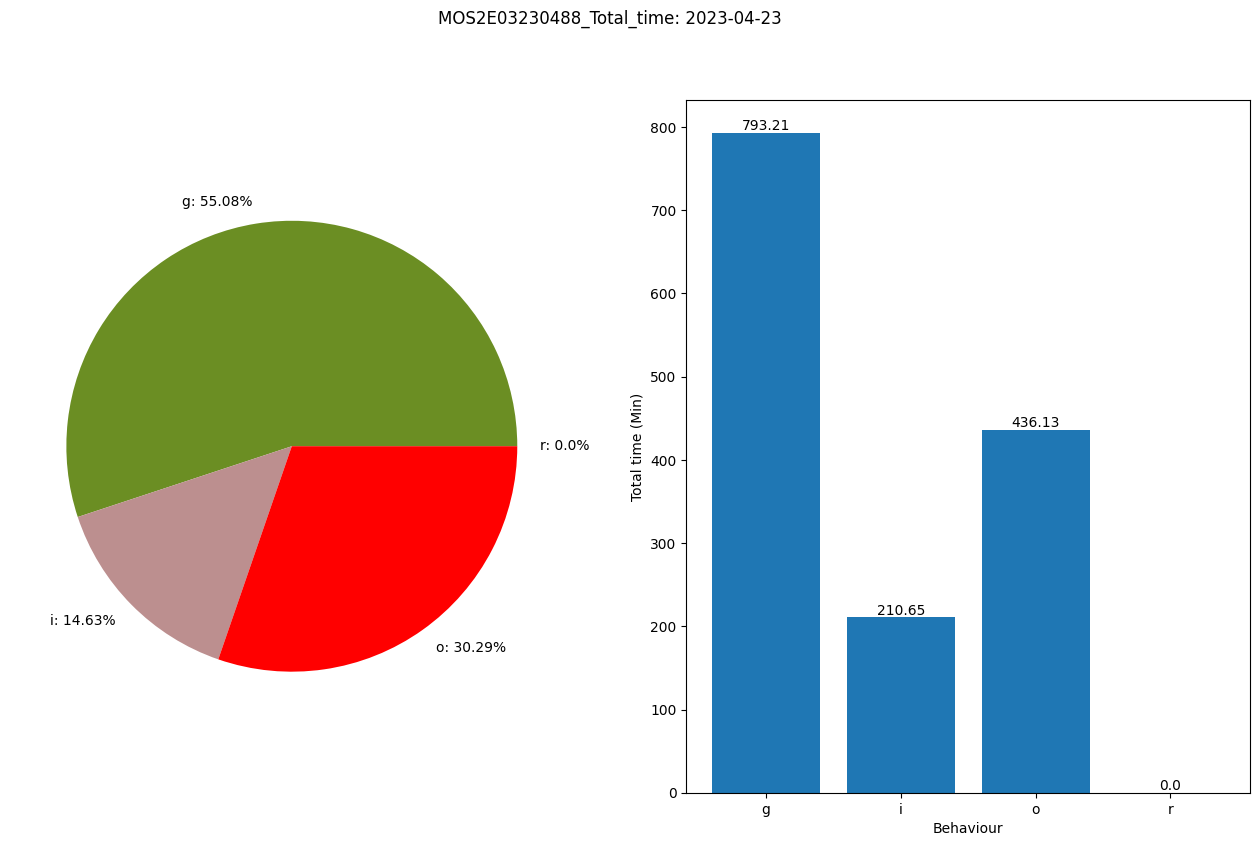

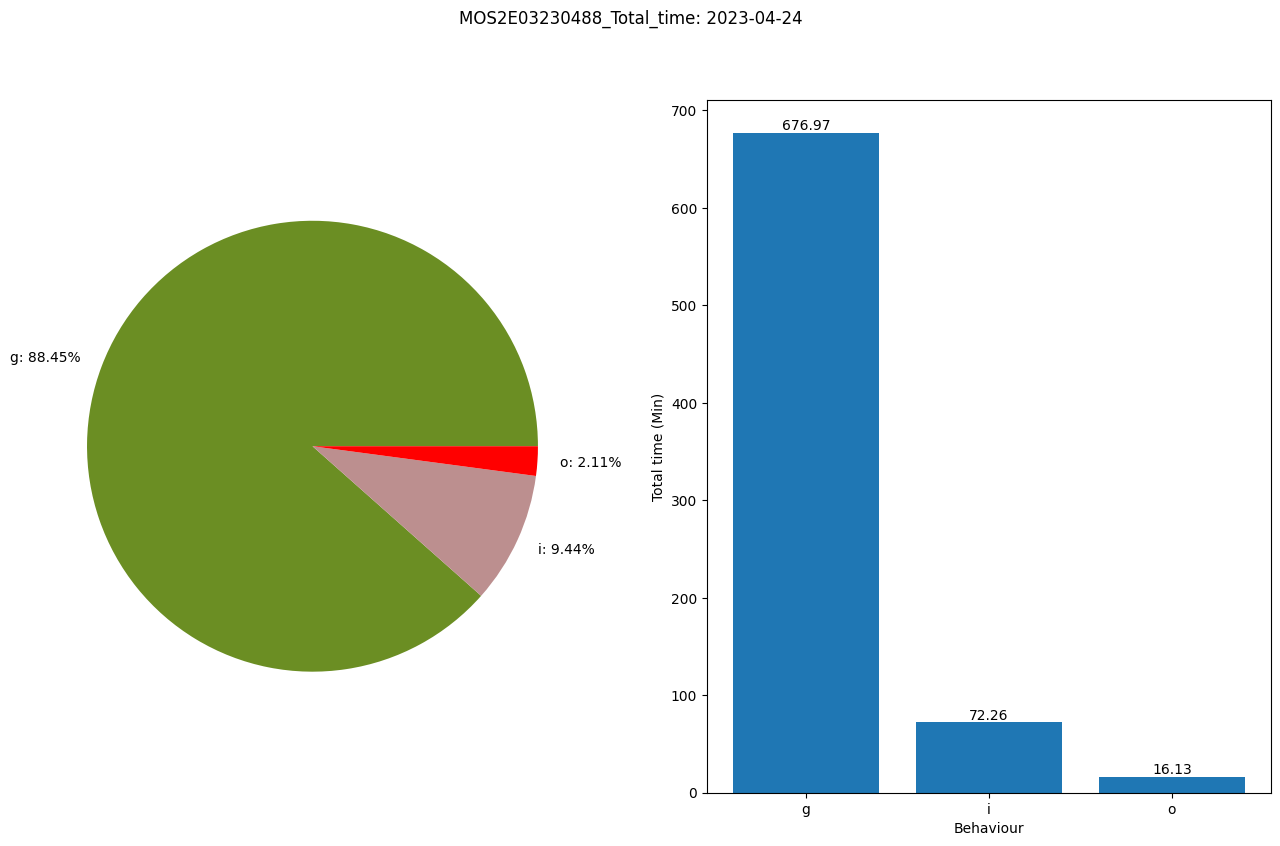

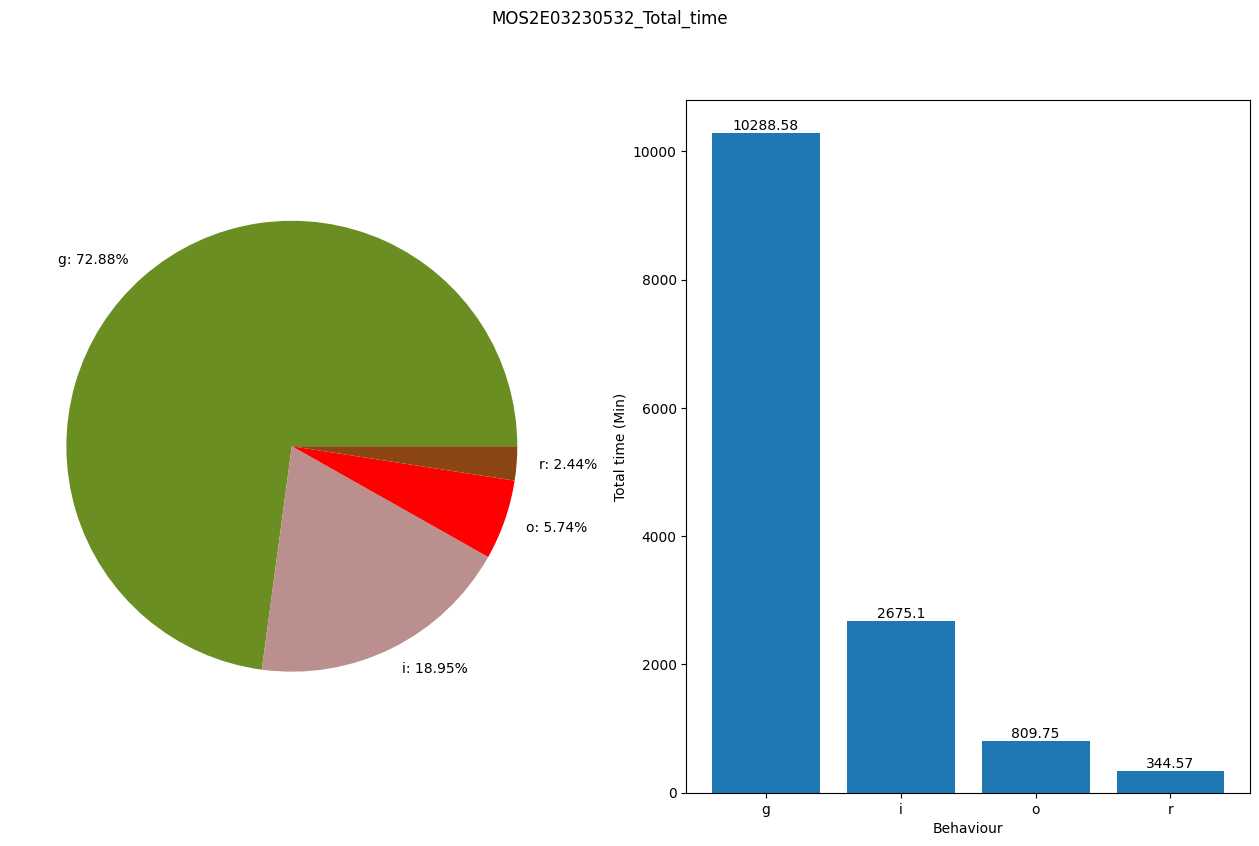

plotted


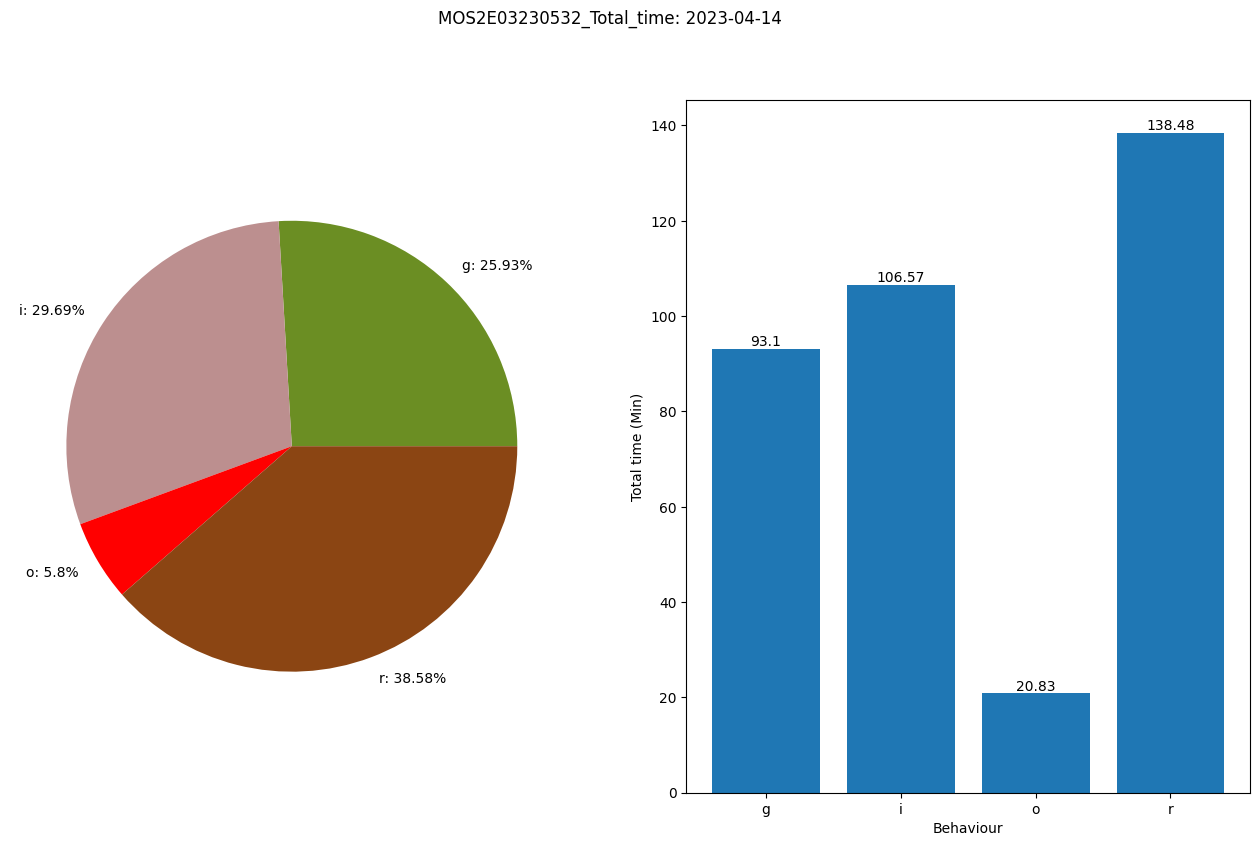

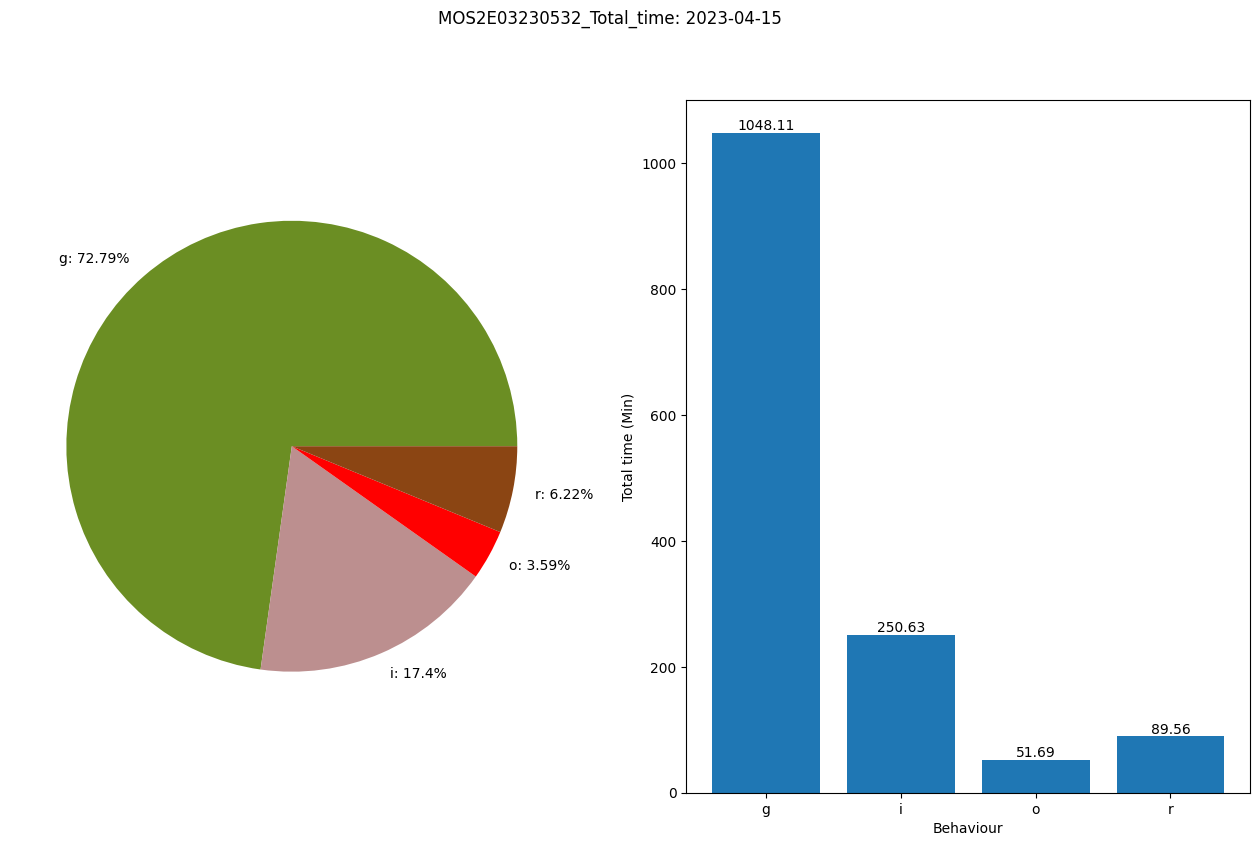

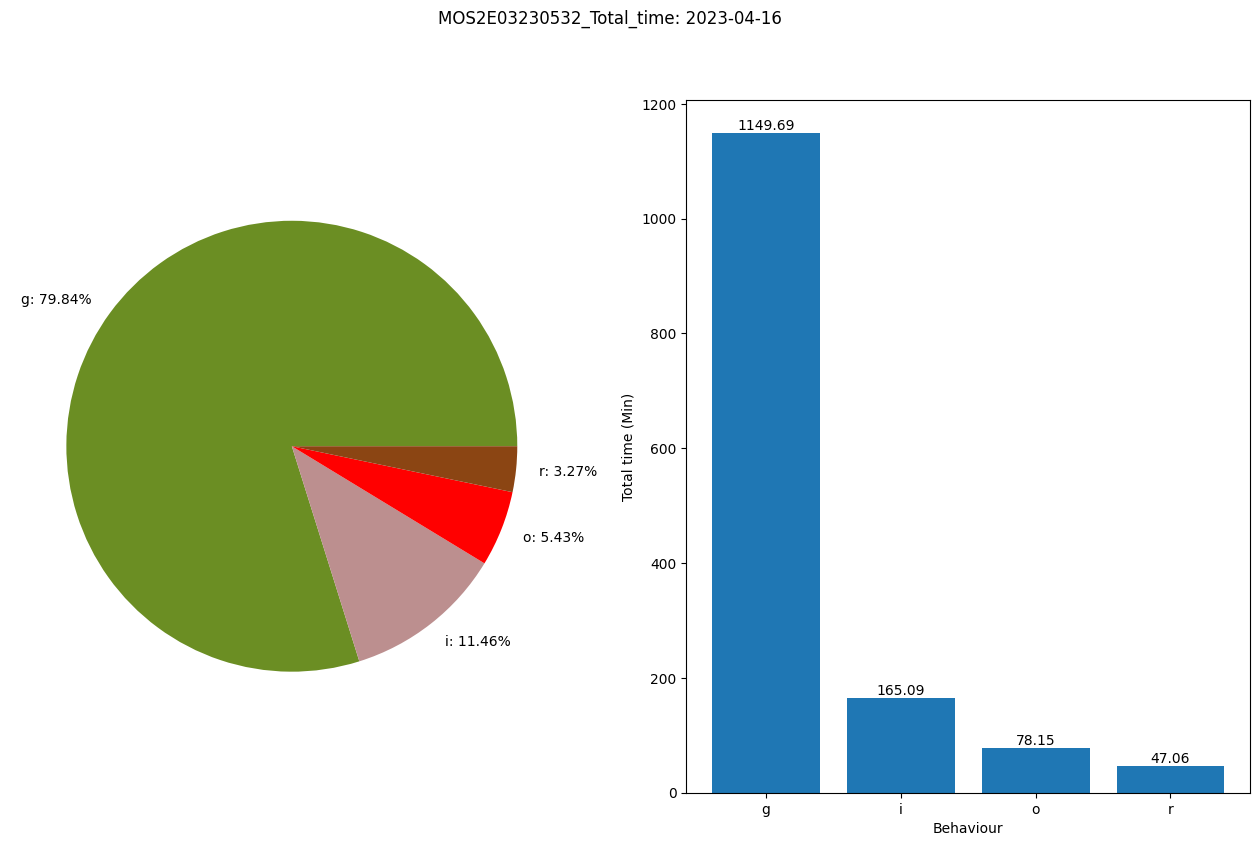

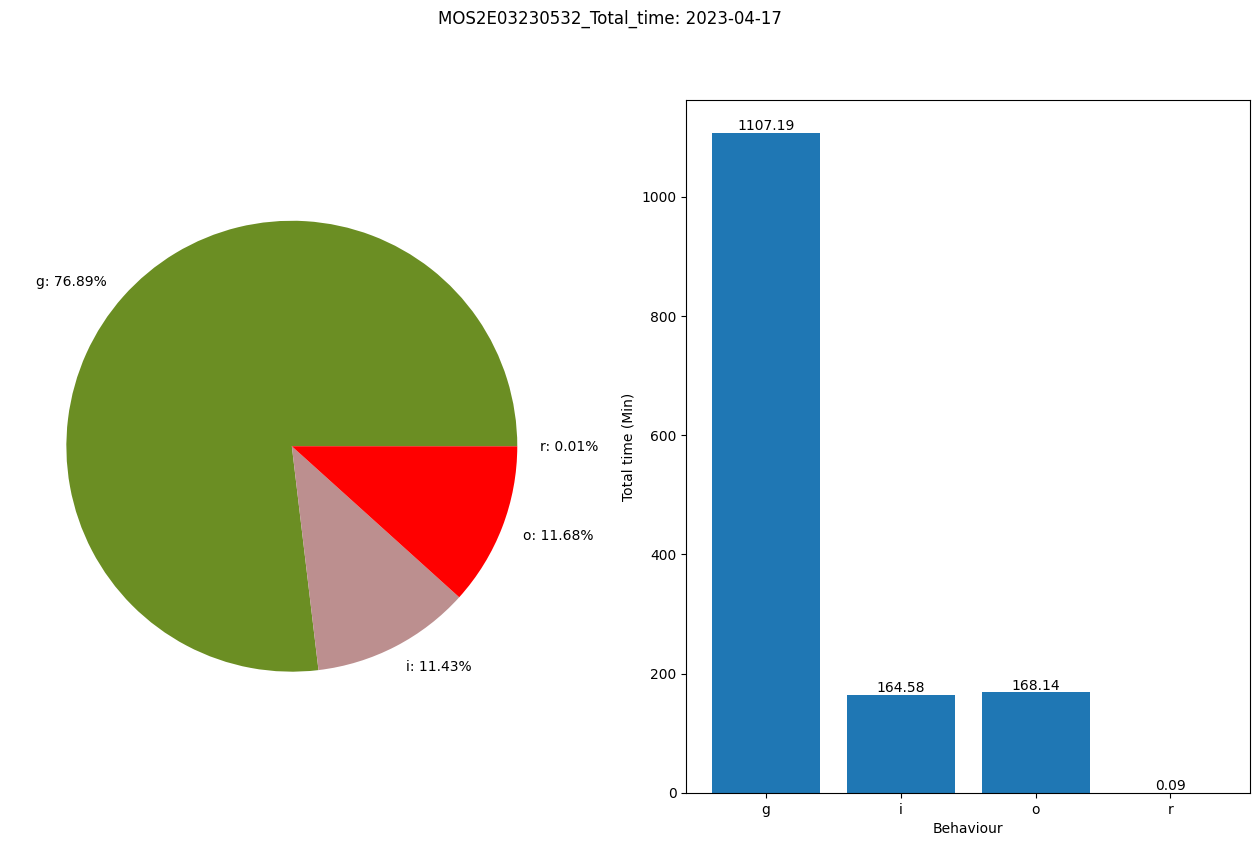

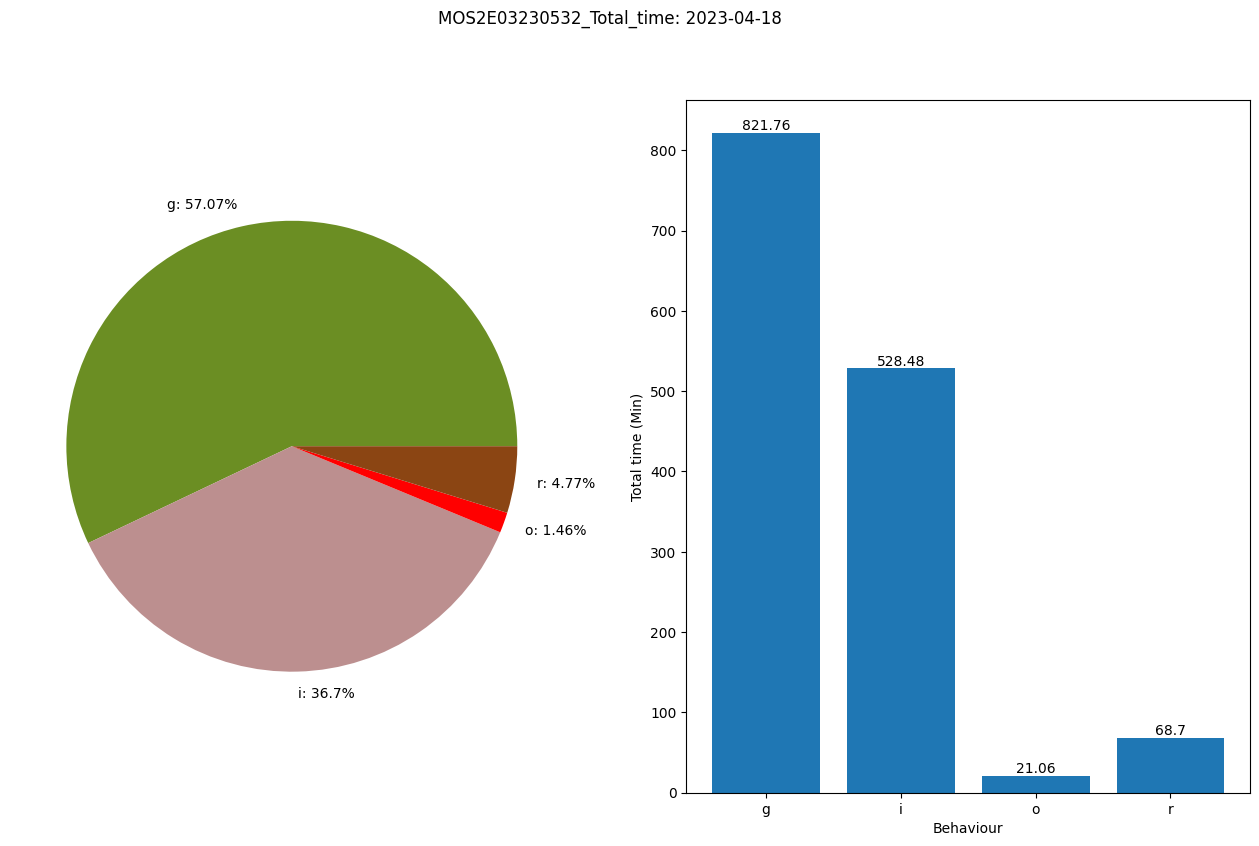

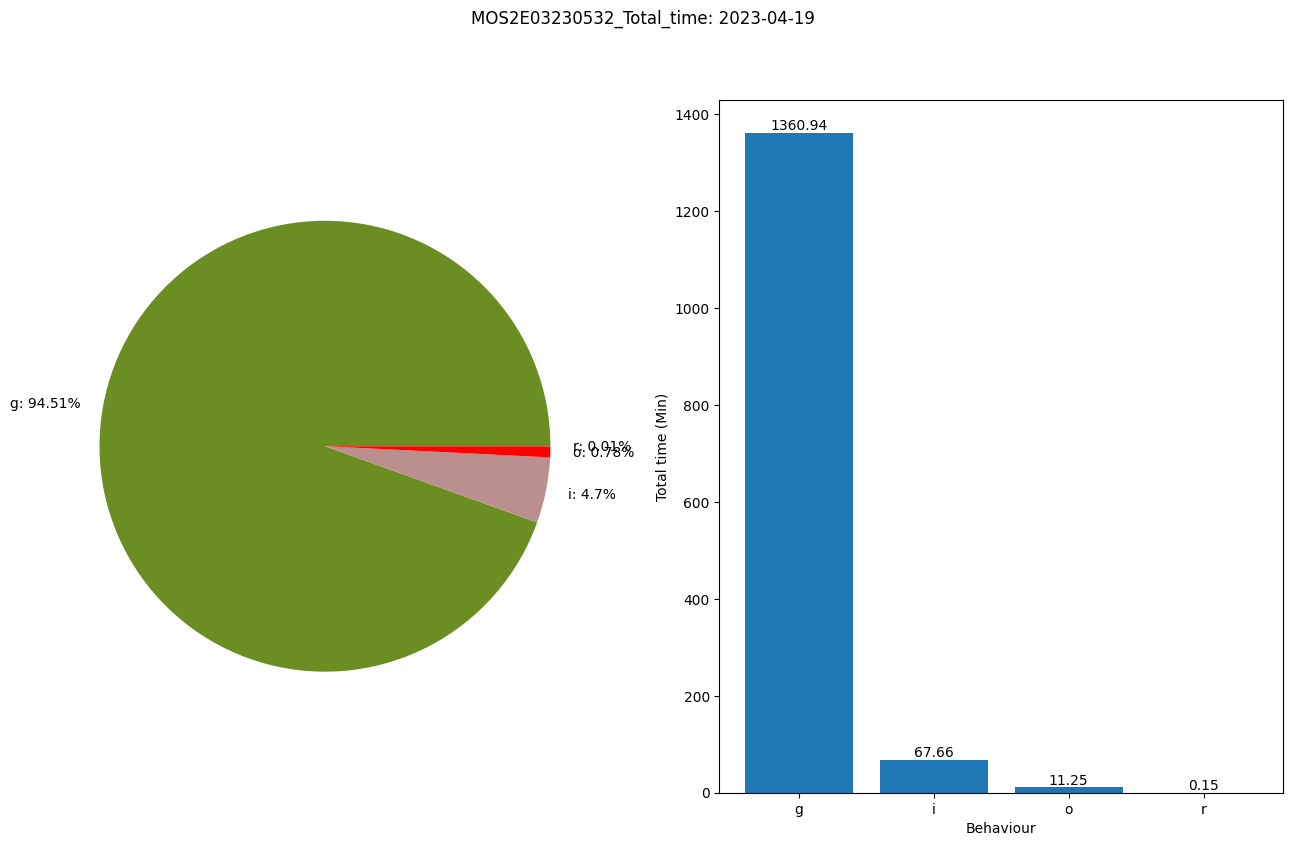

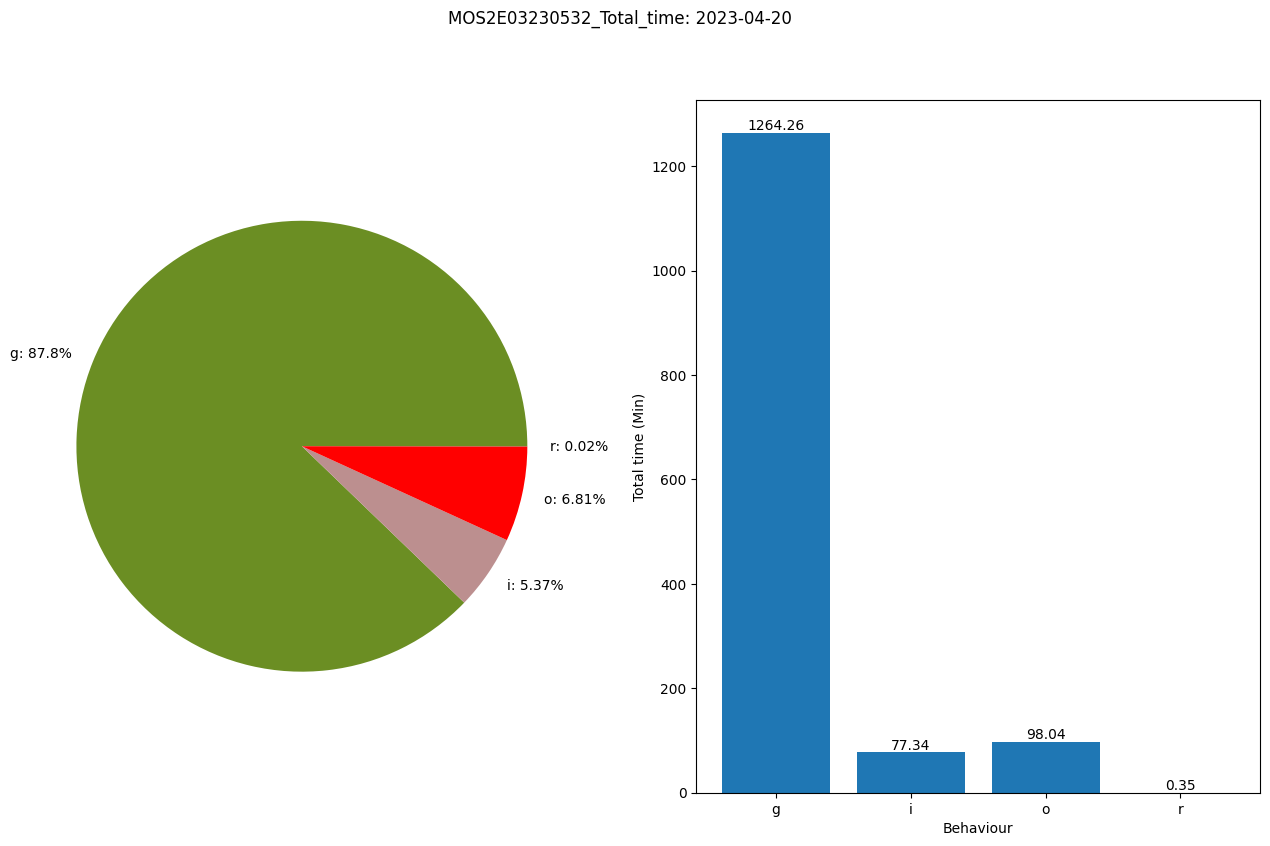

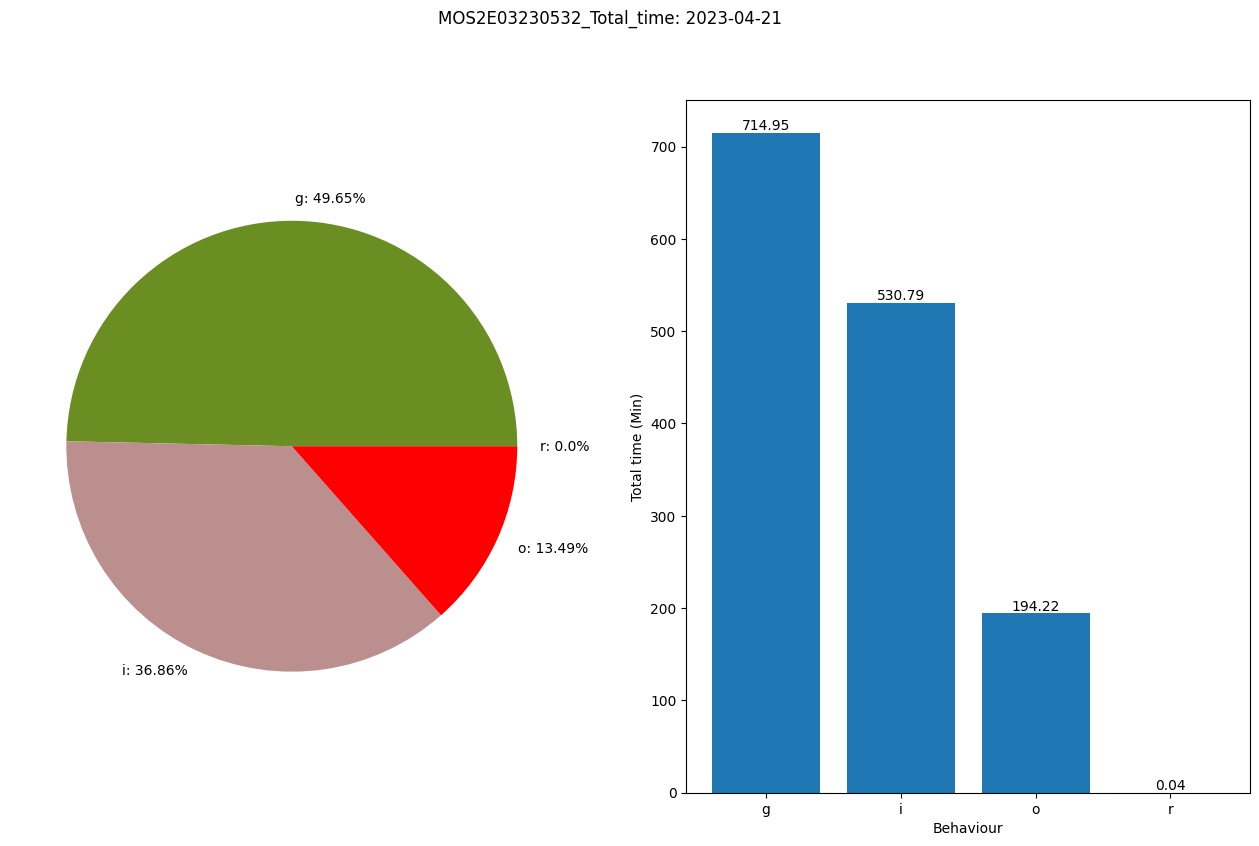

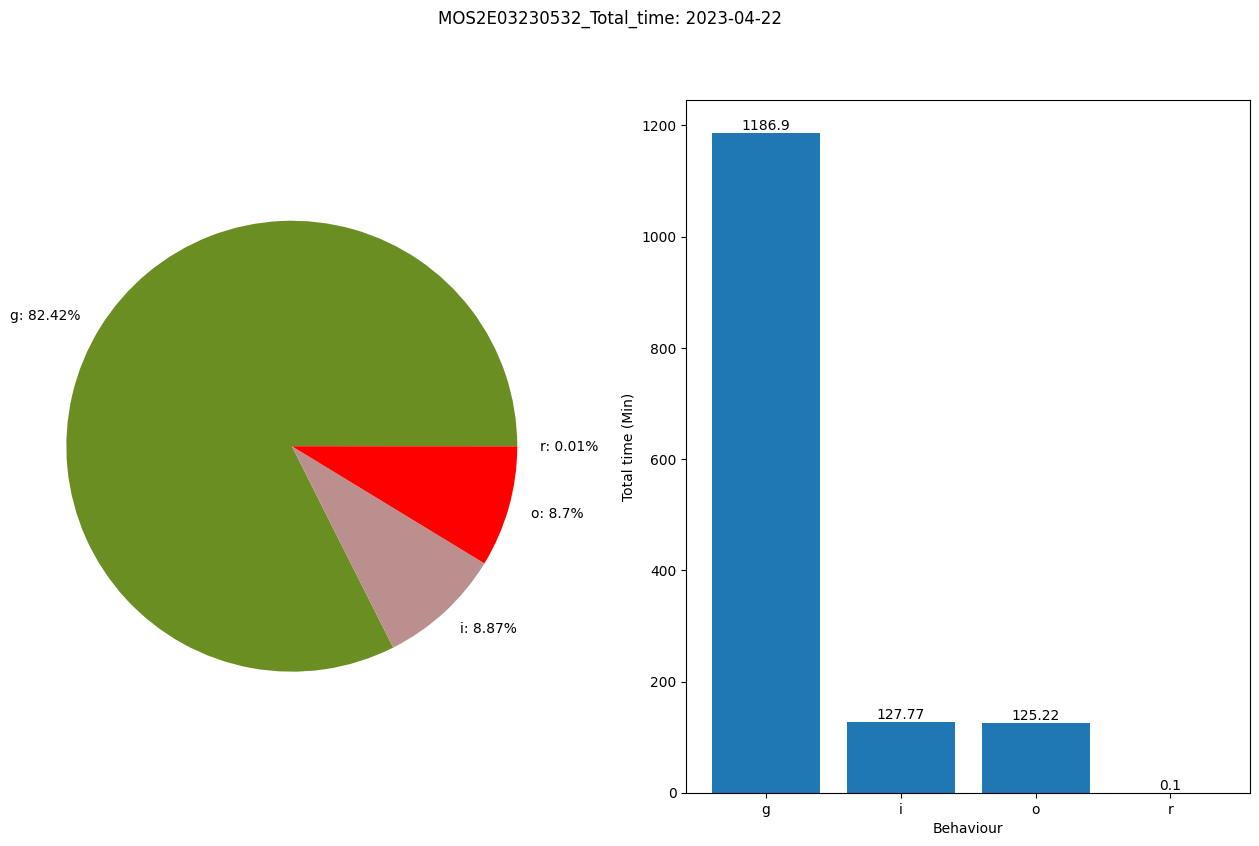

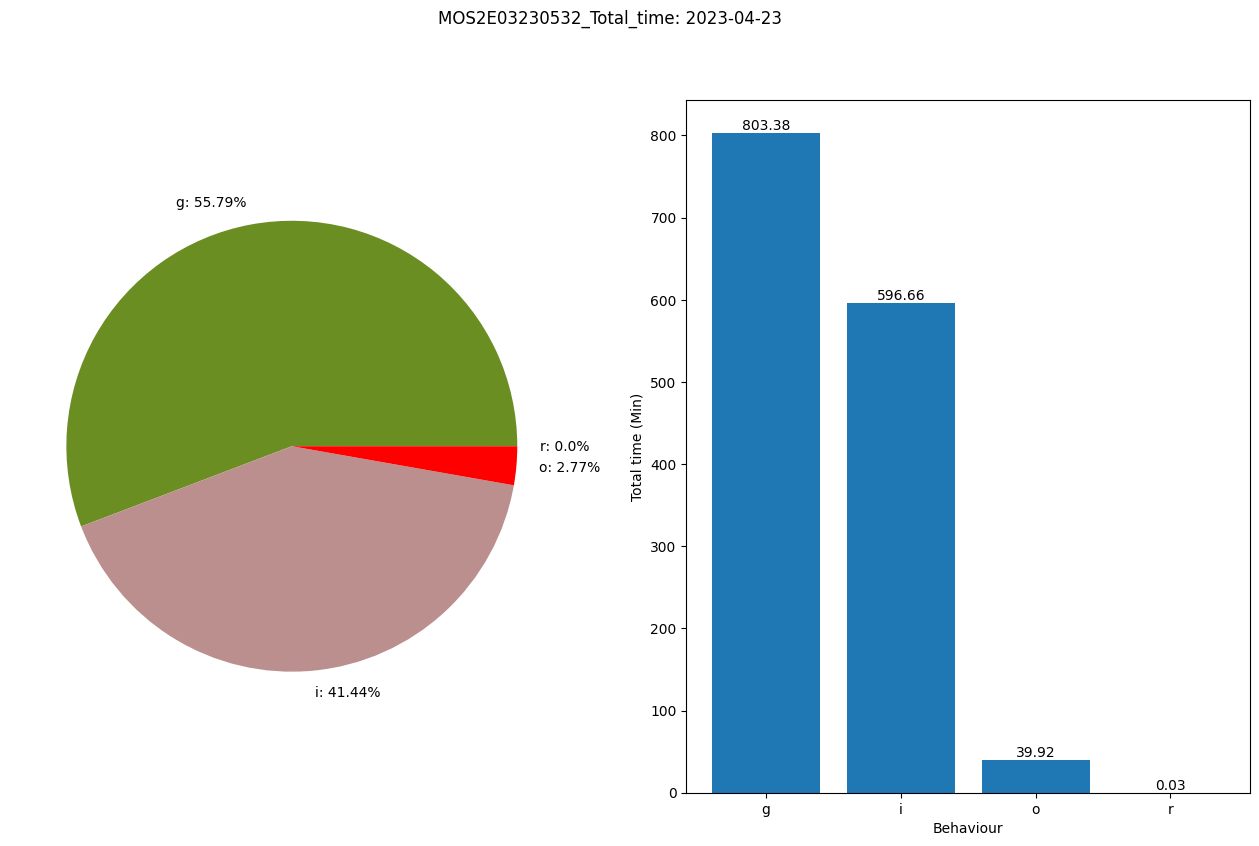

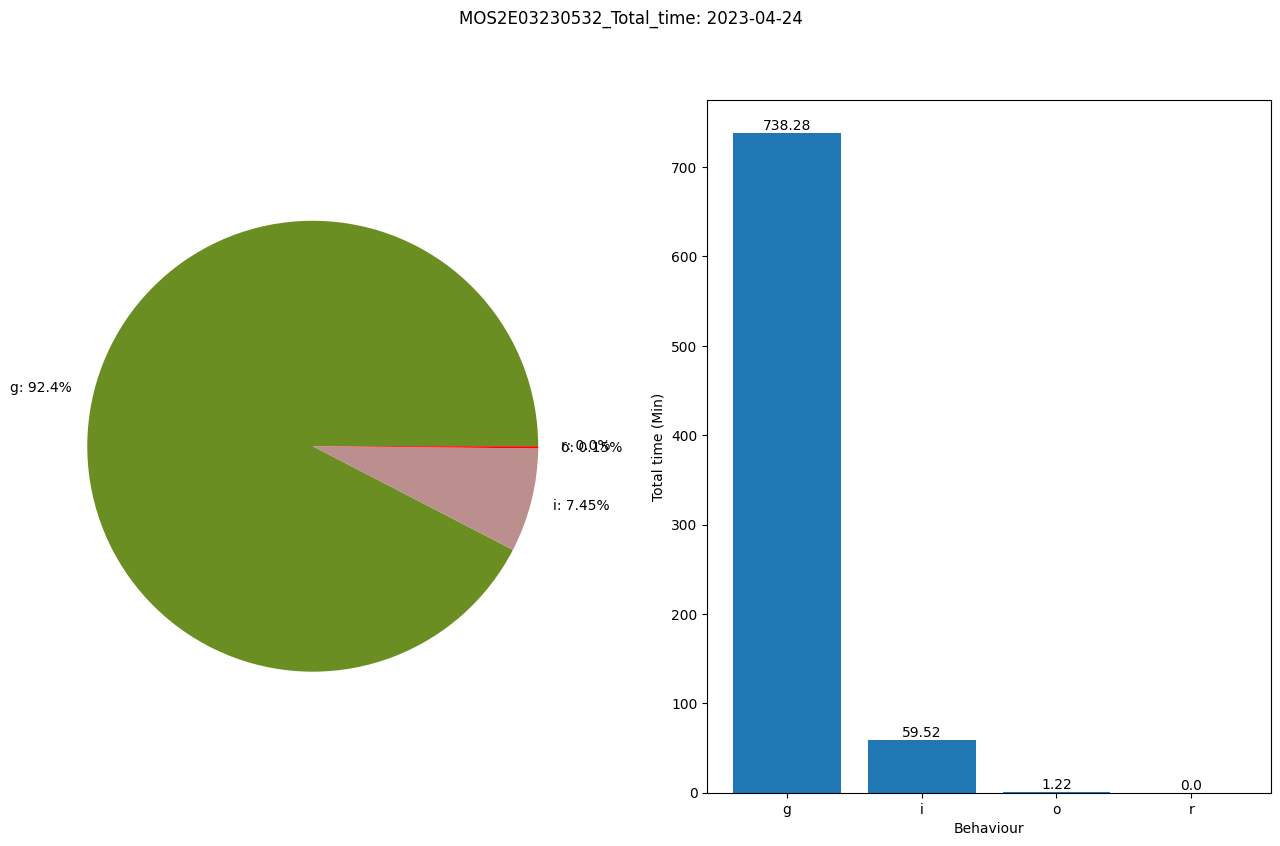

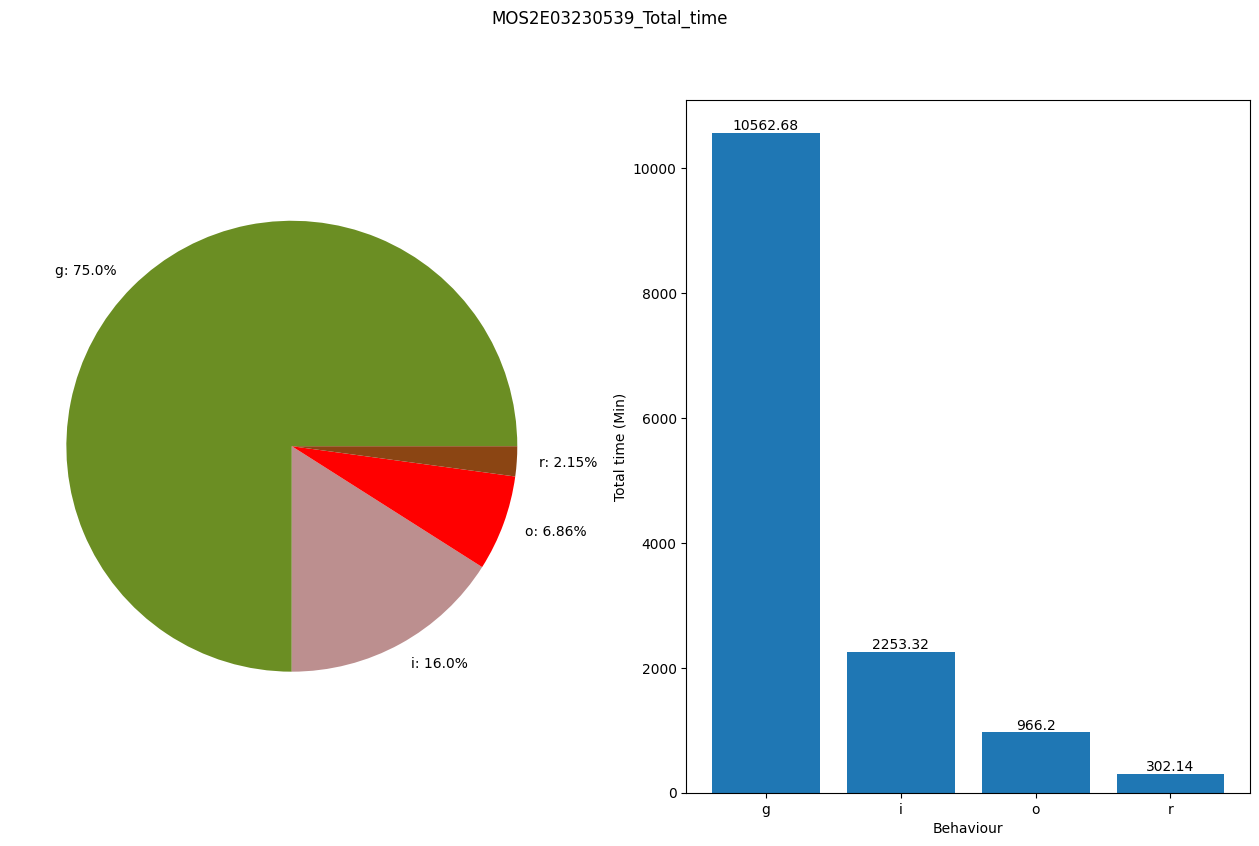

plotted


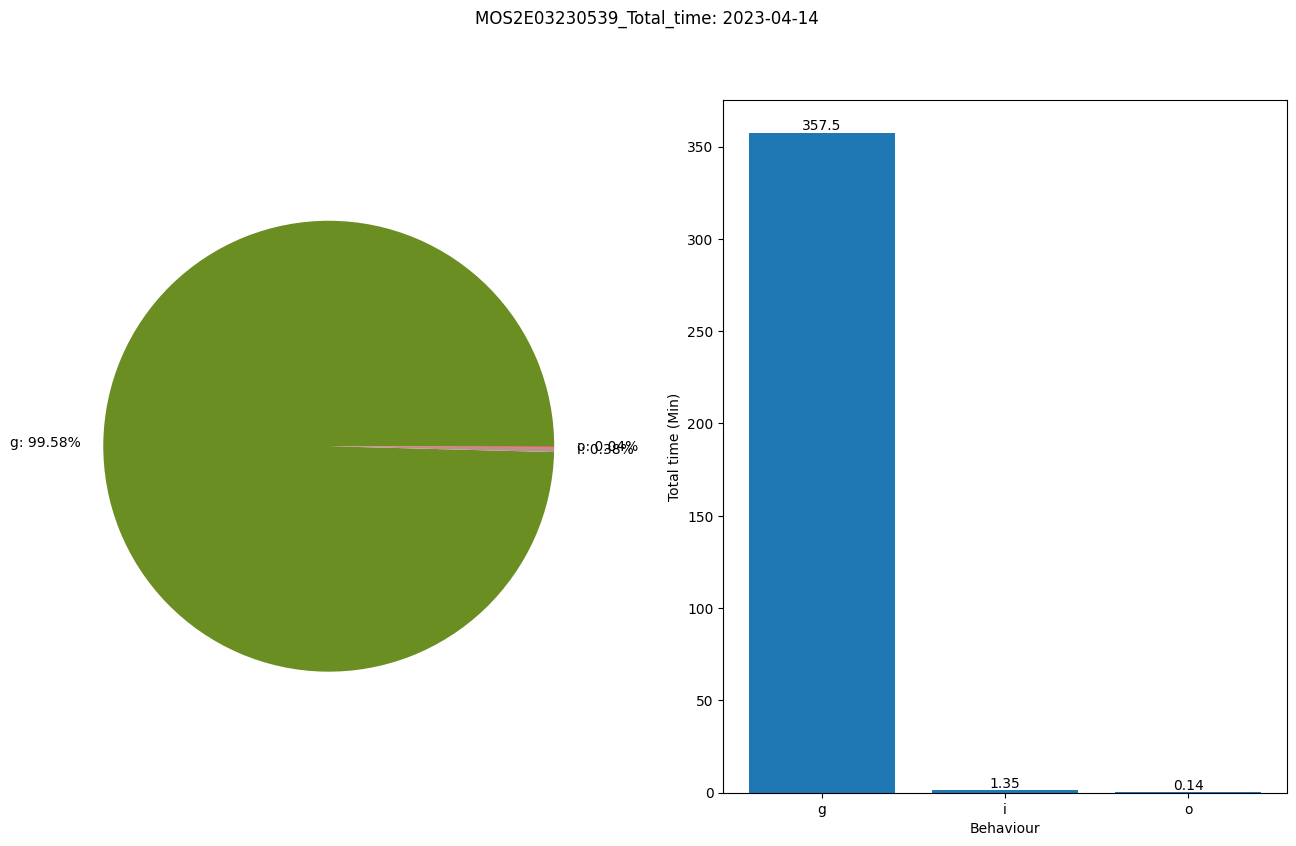

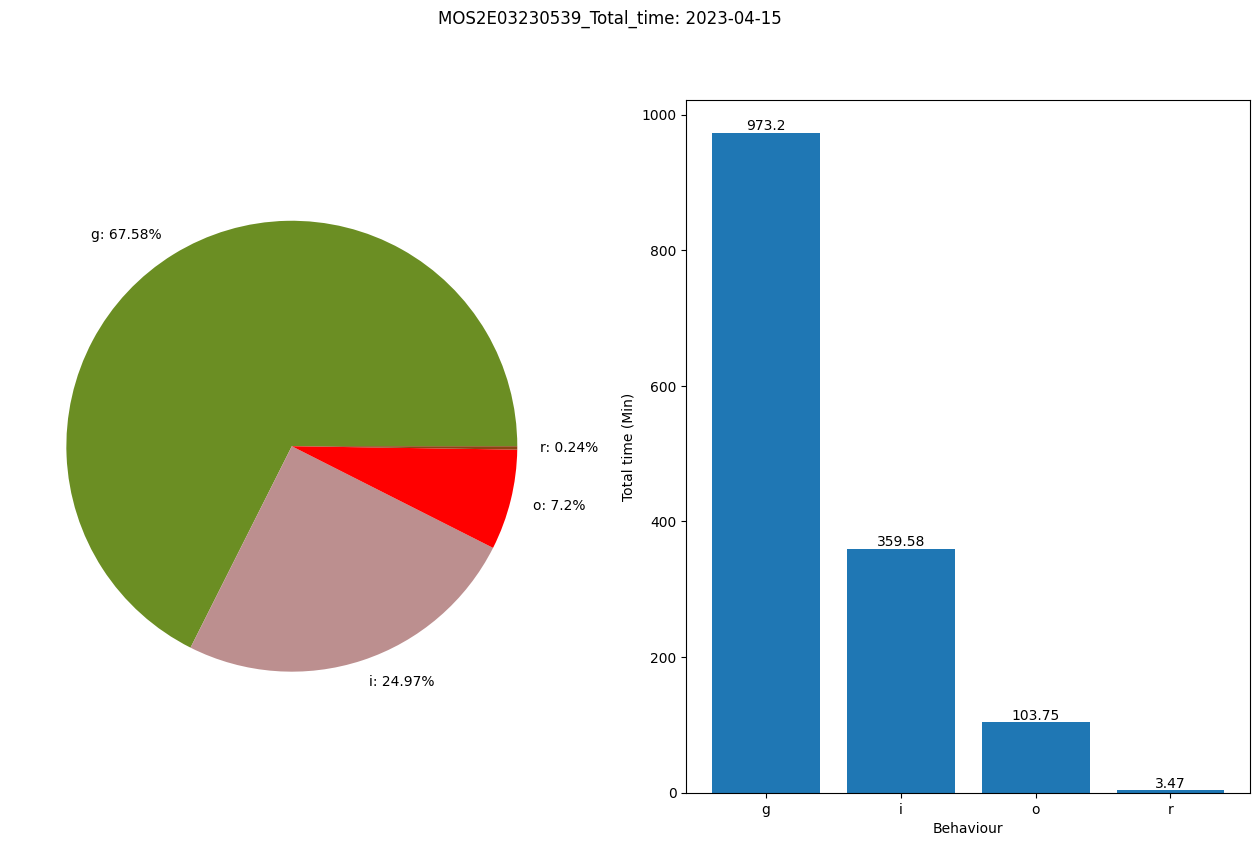

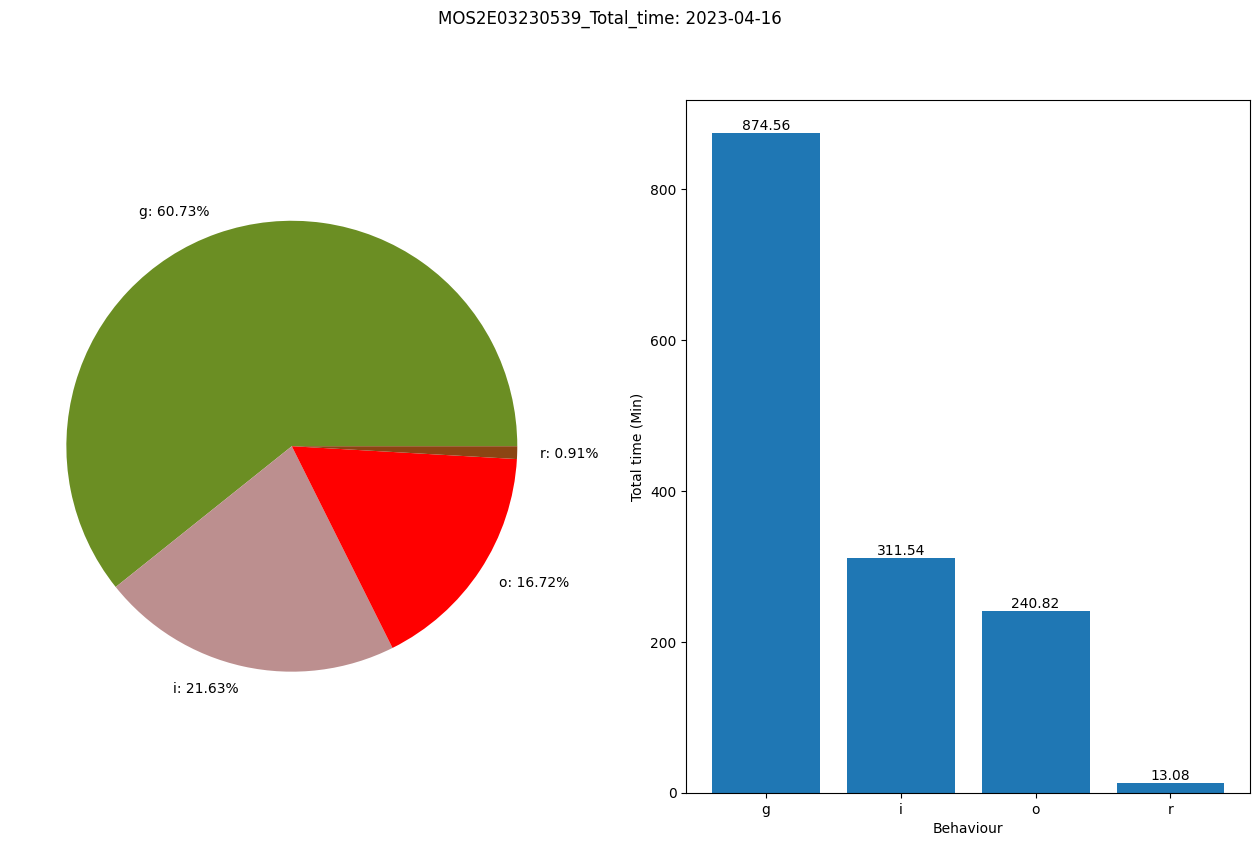

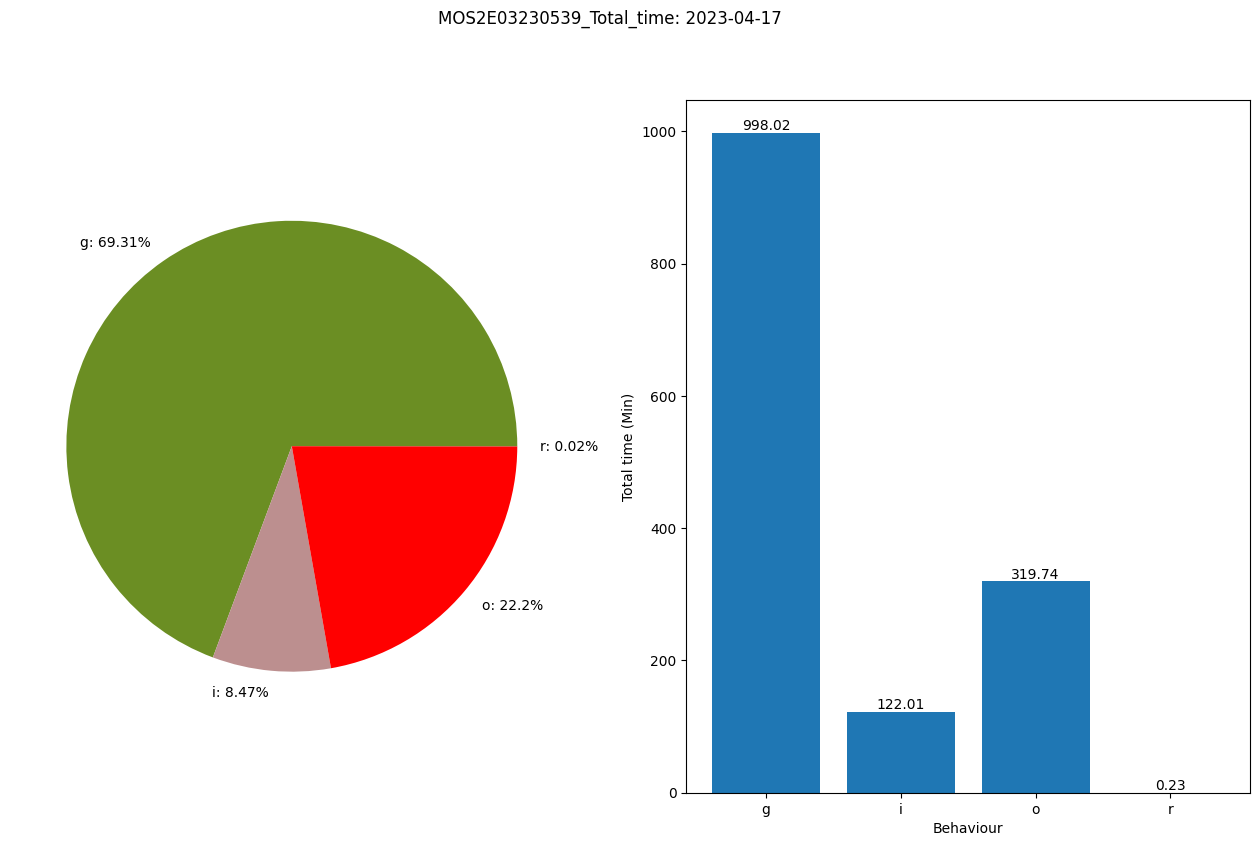

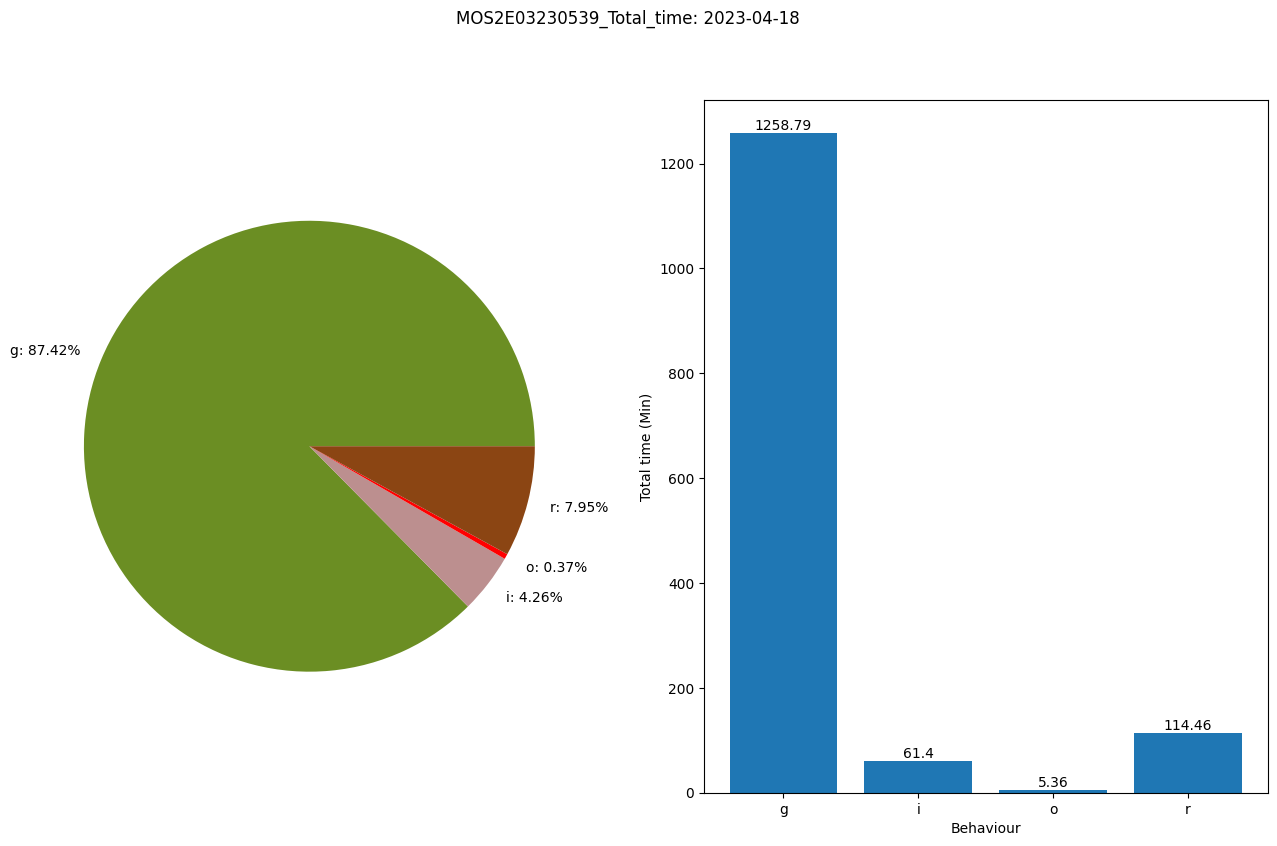

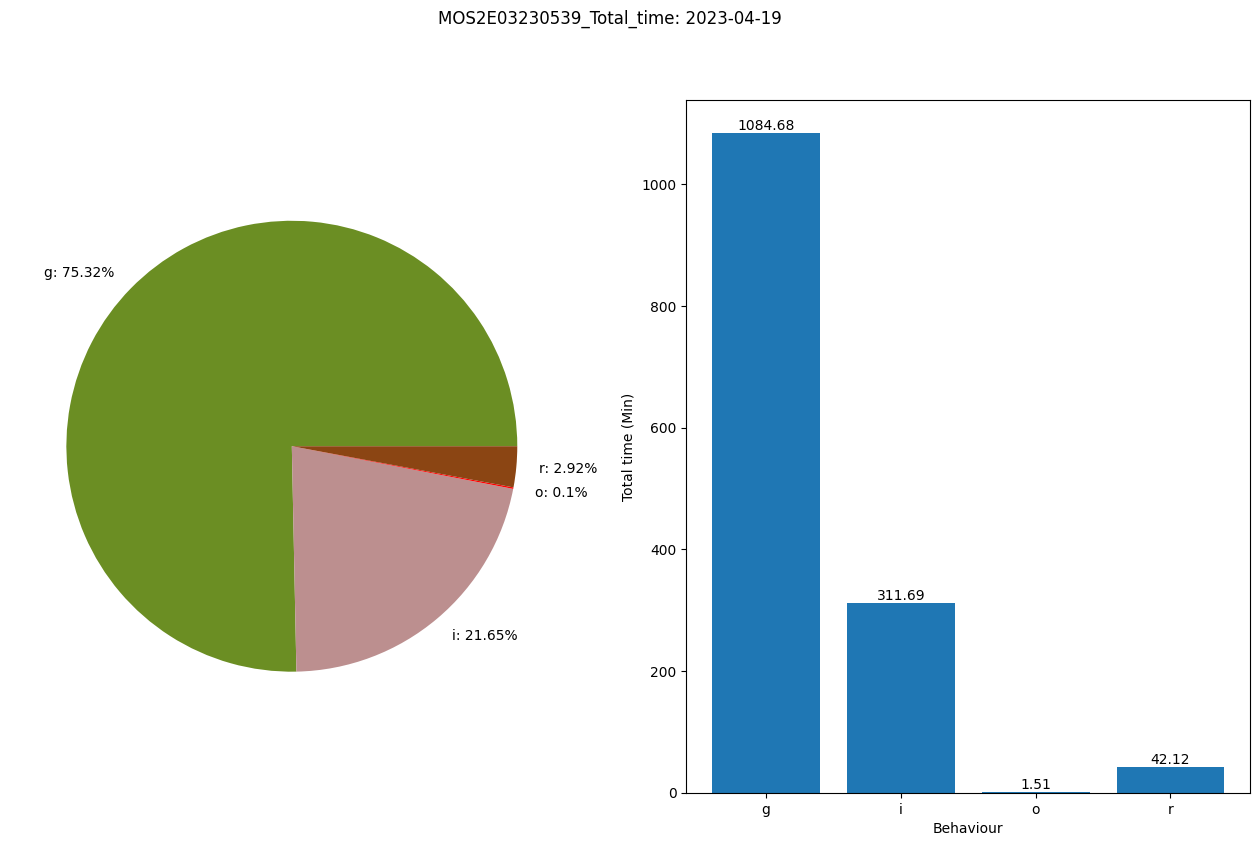

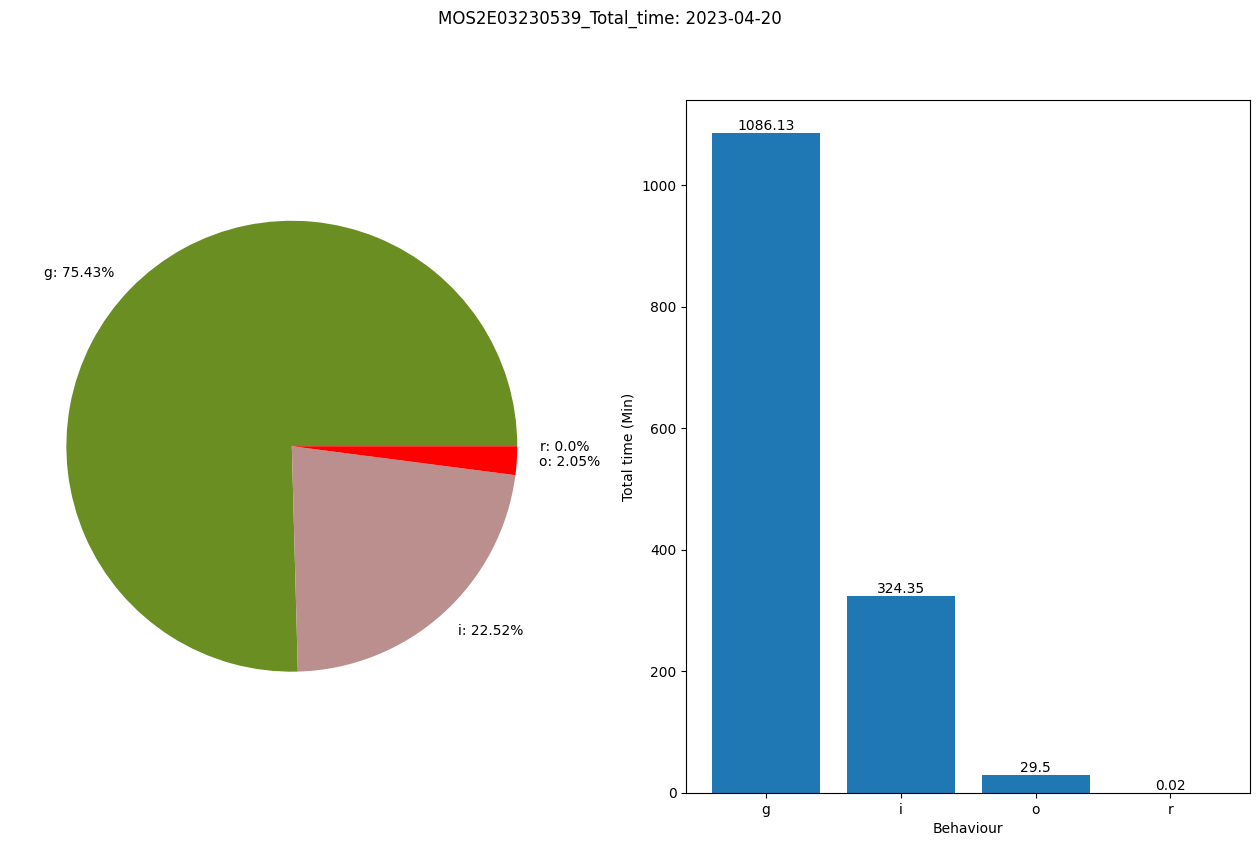

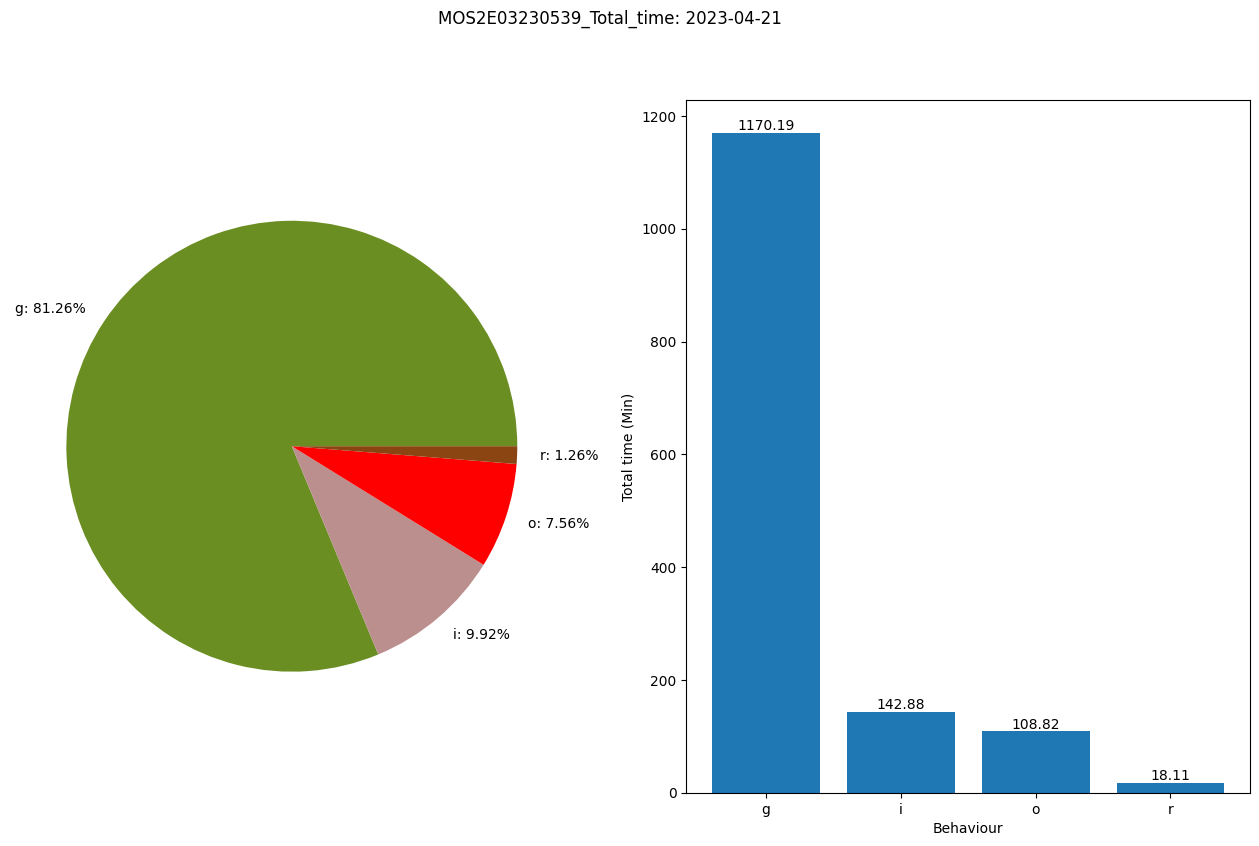

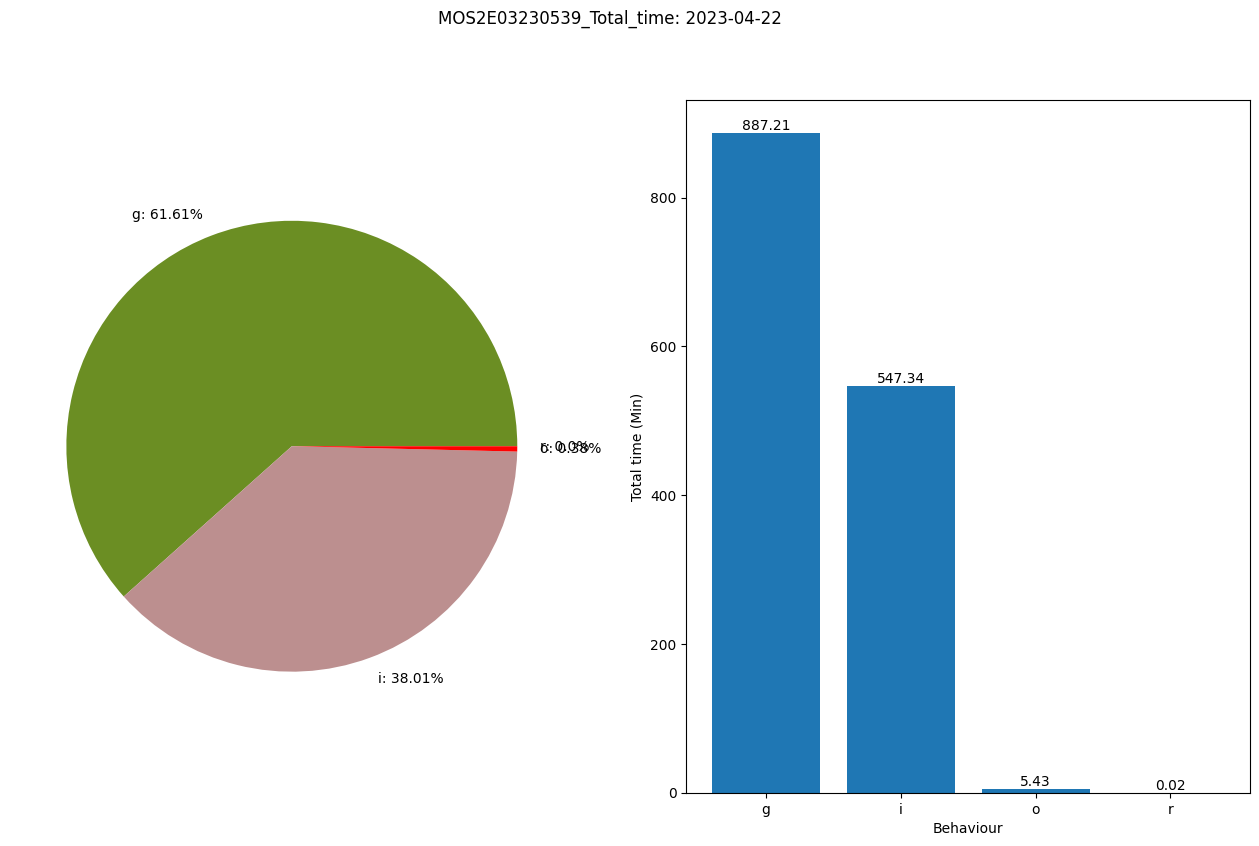

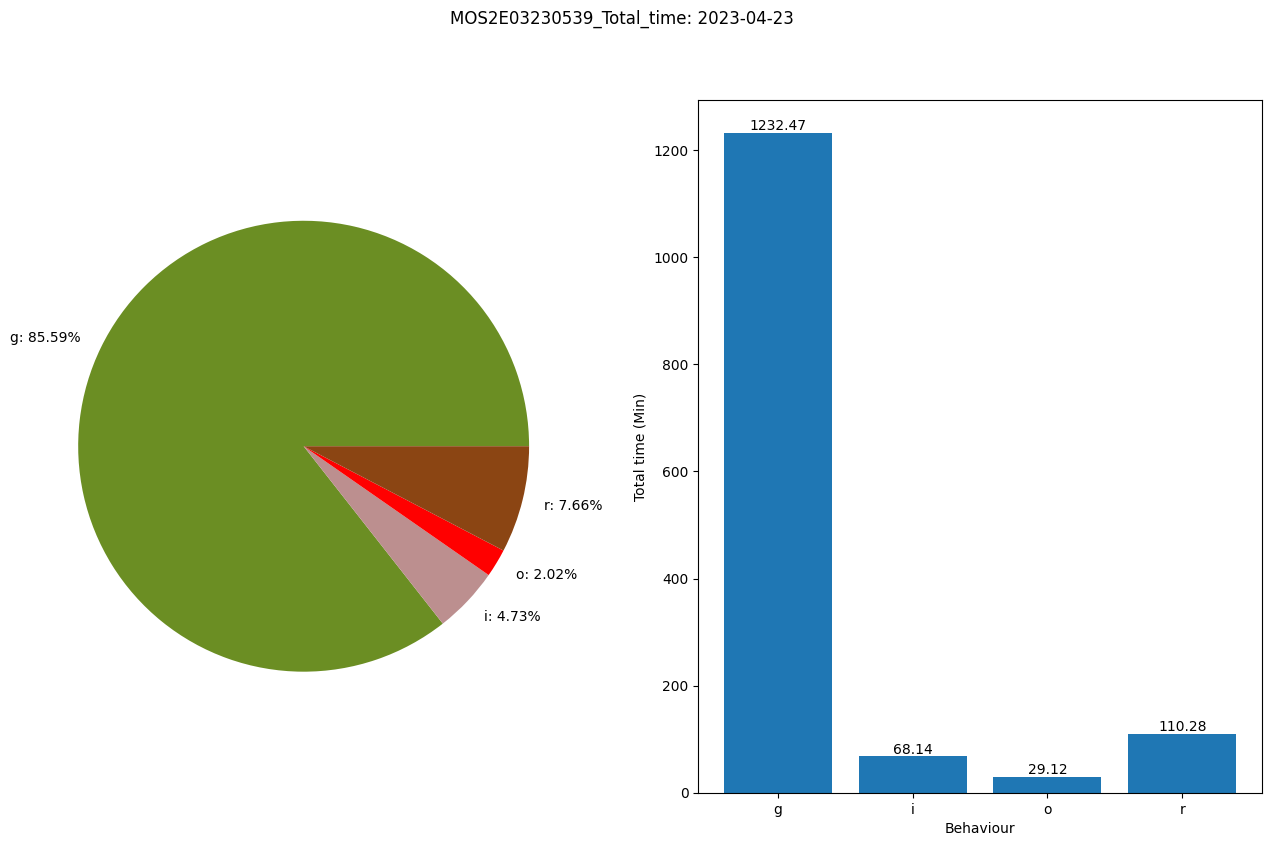

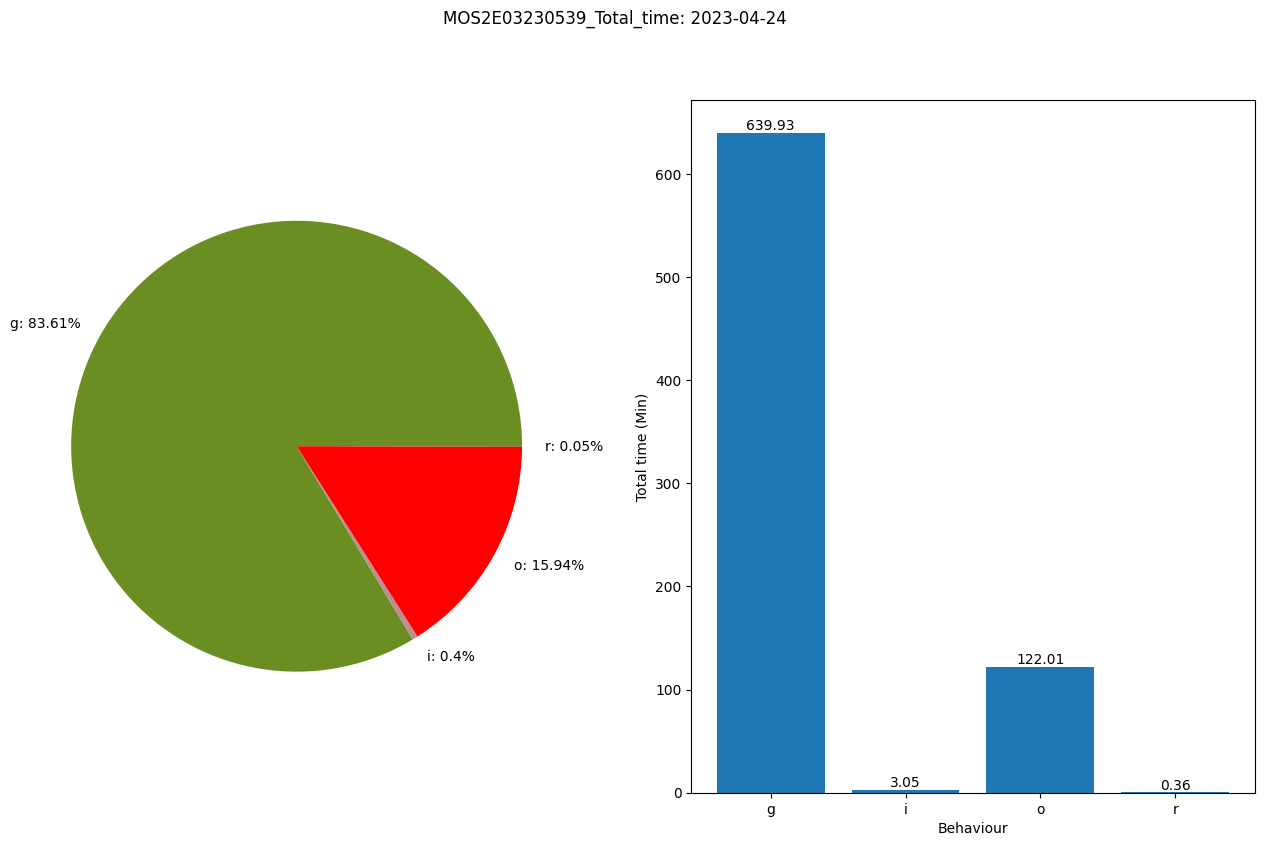

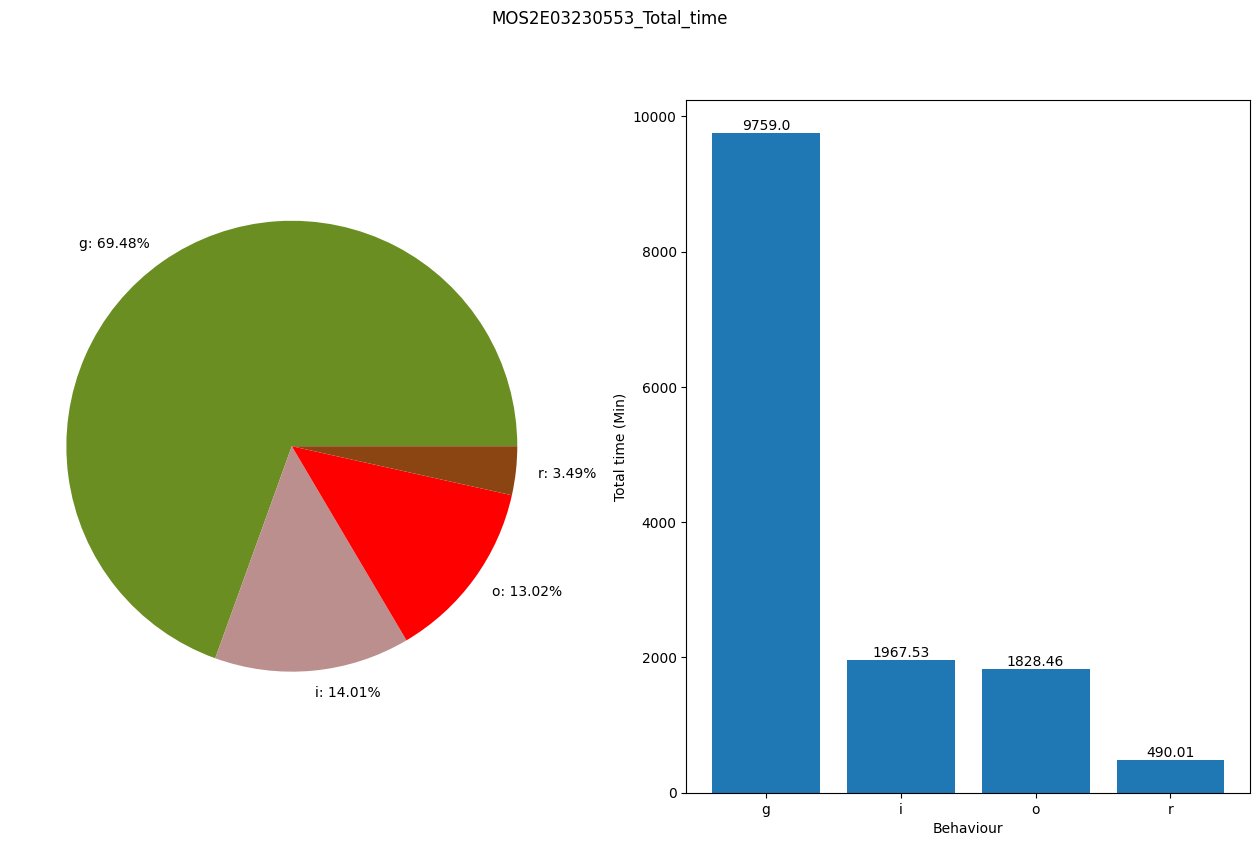

plotted


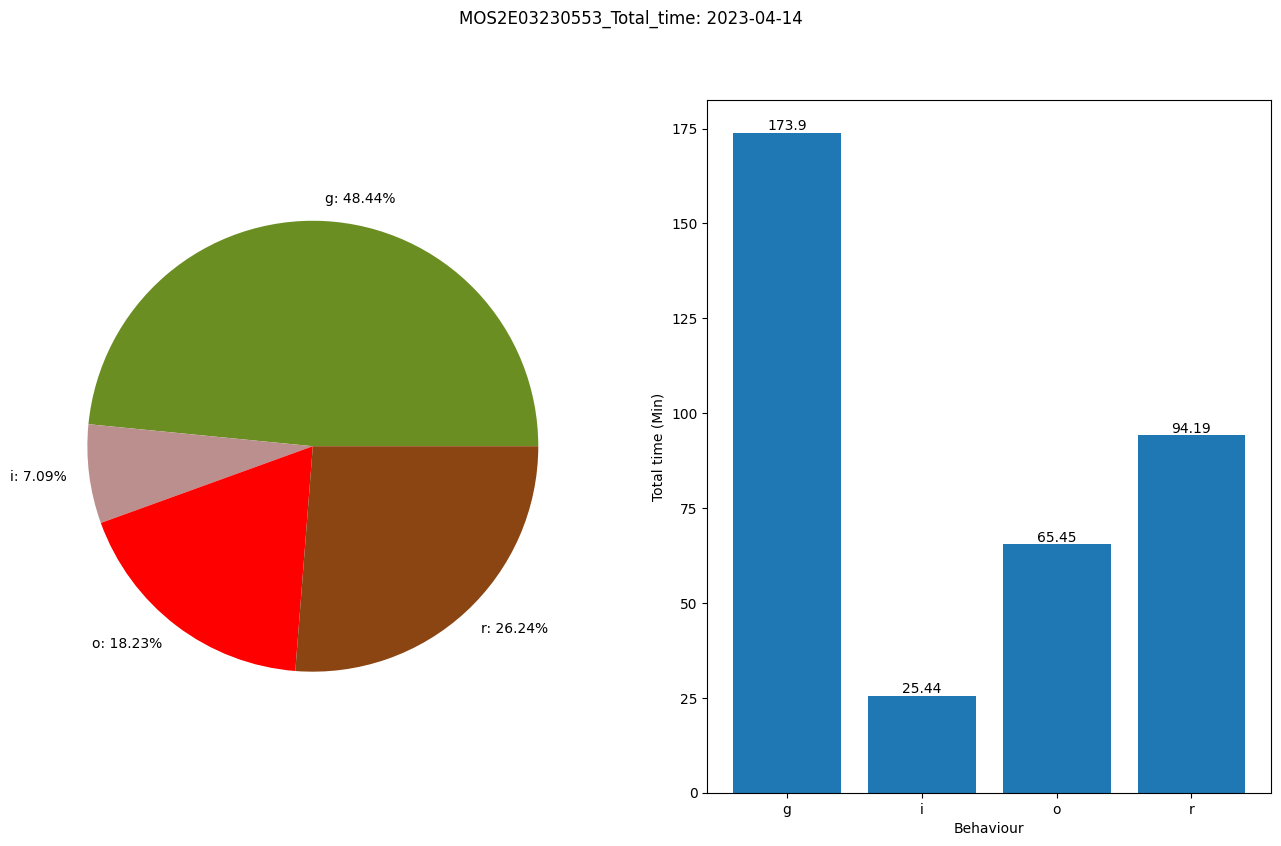

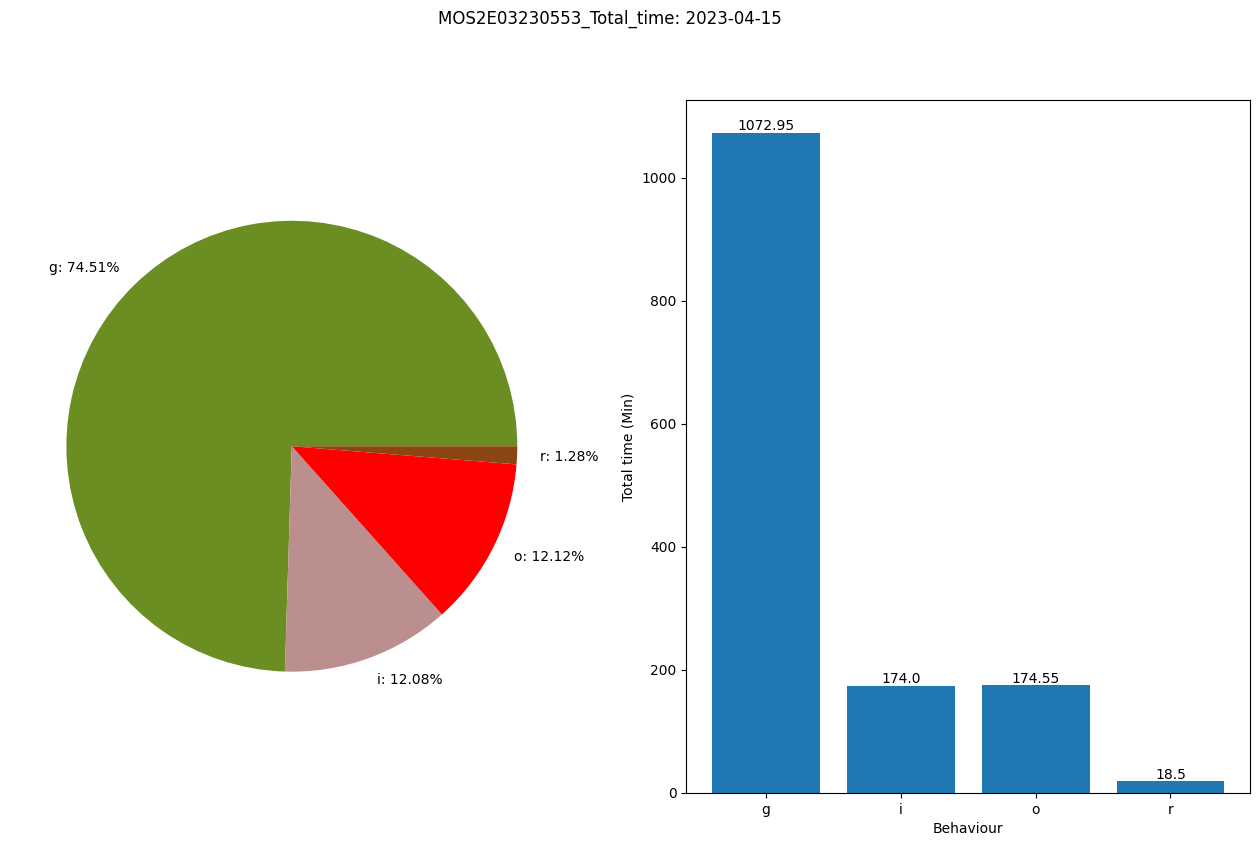

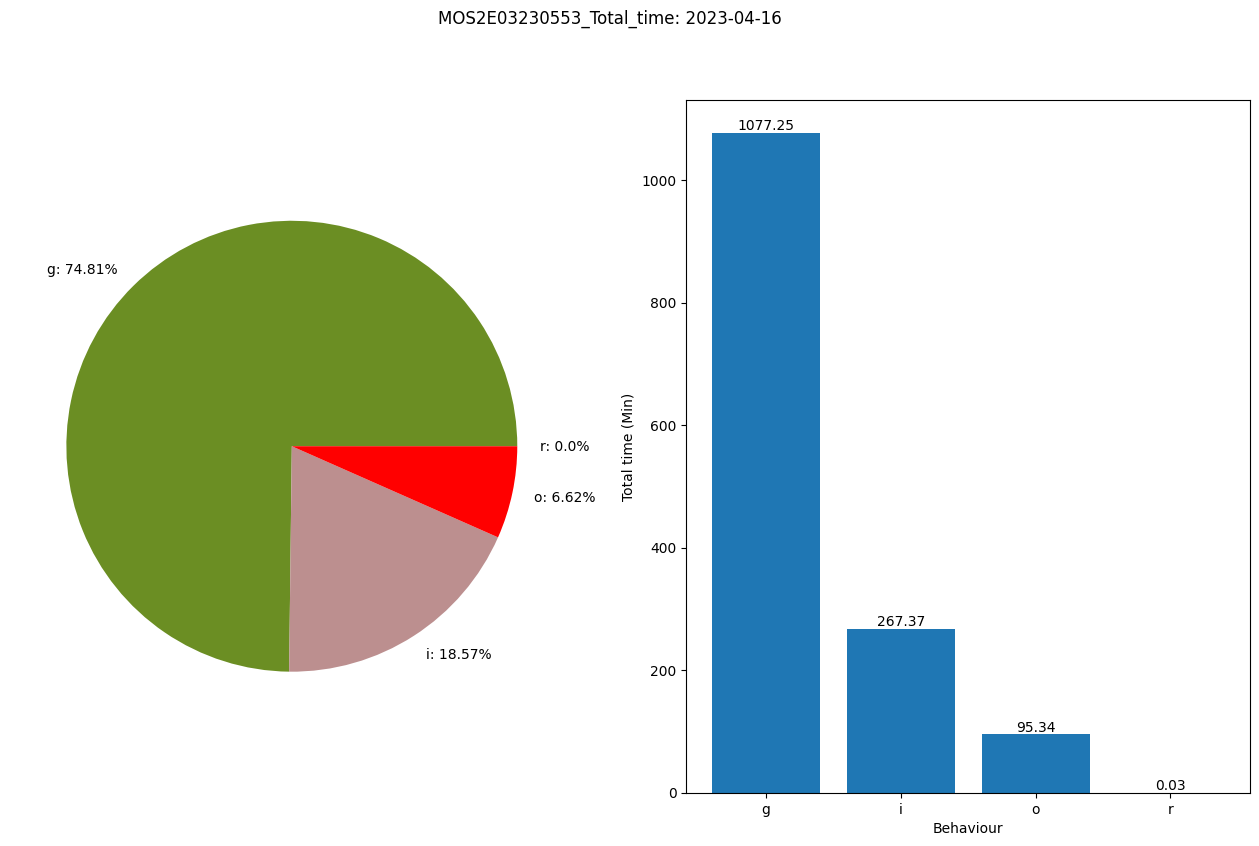

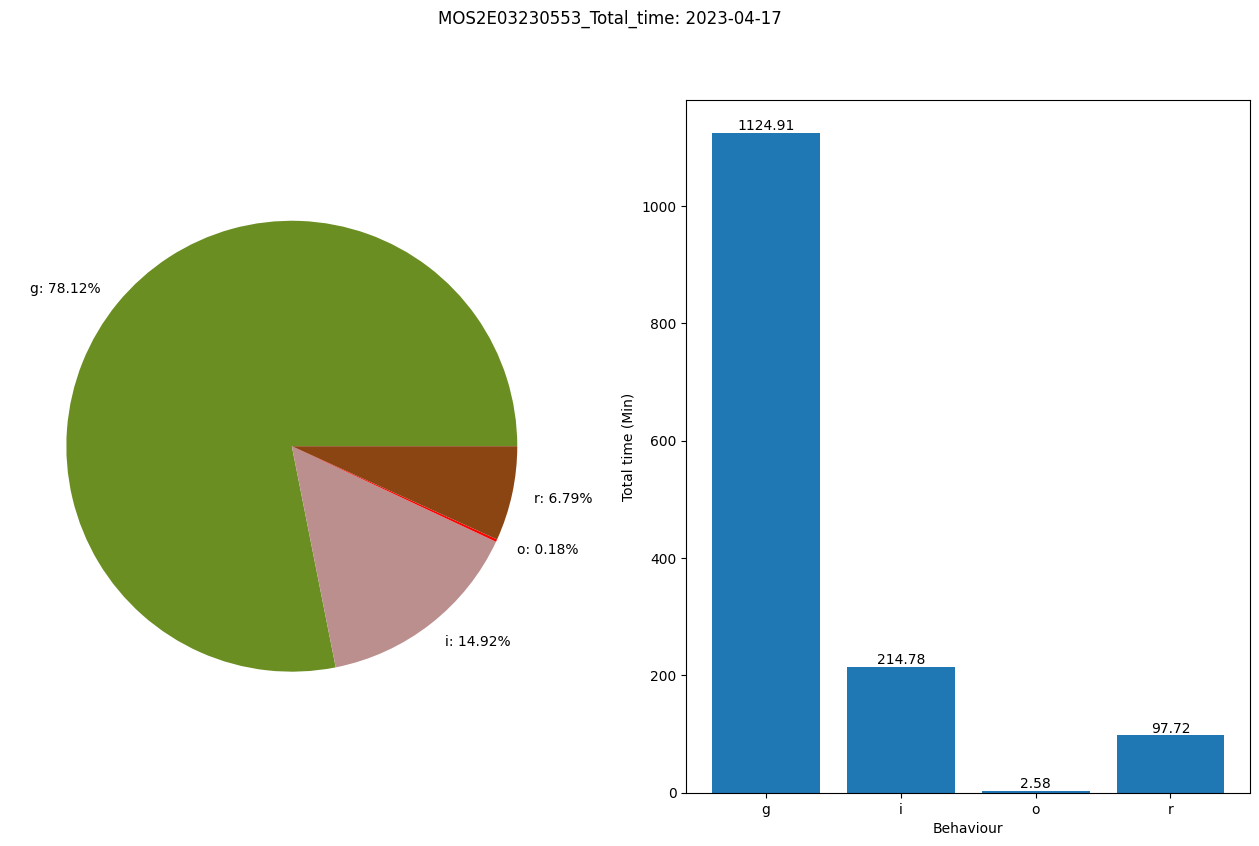

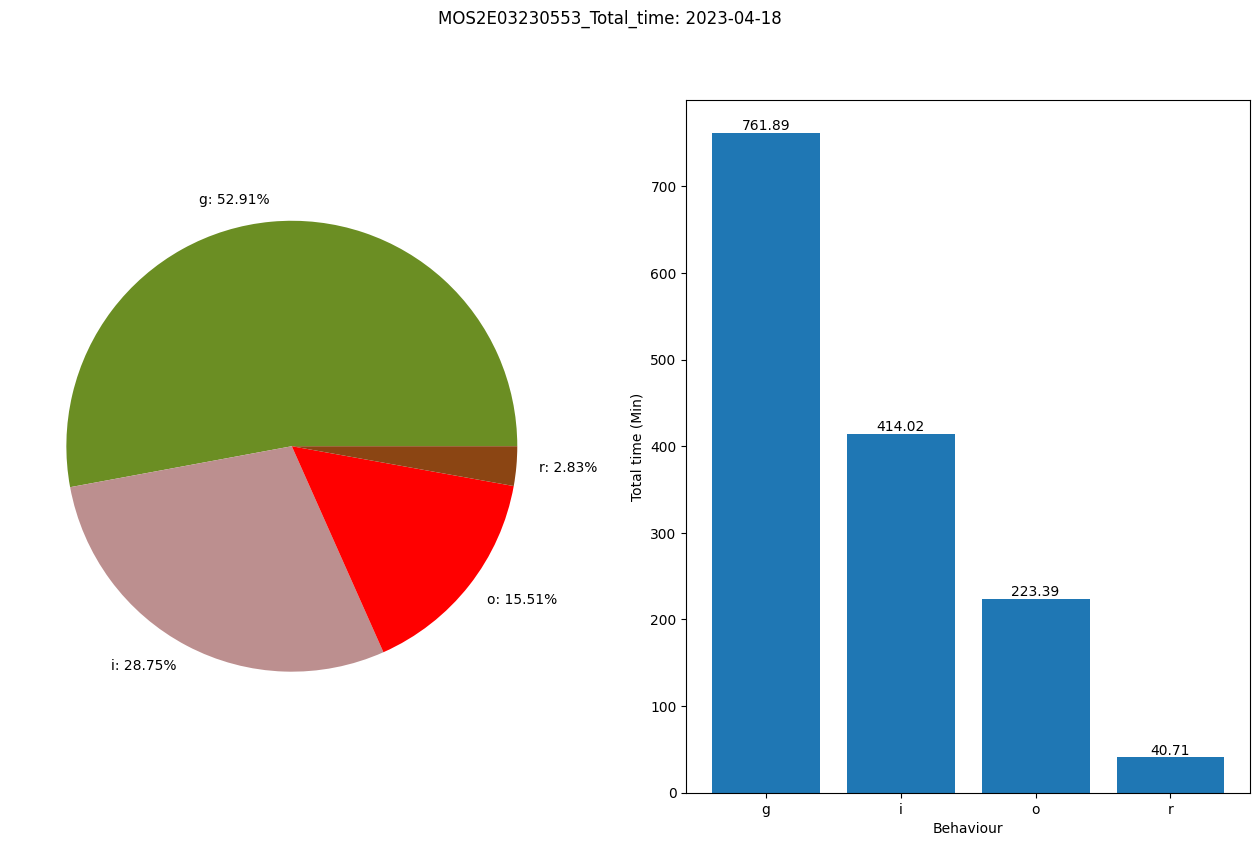

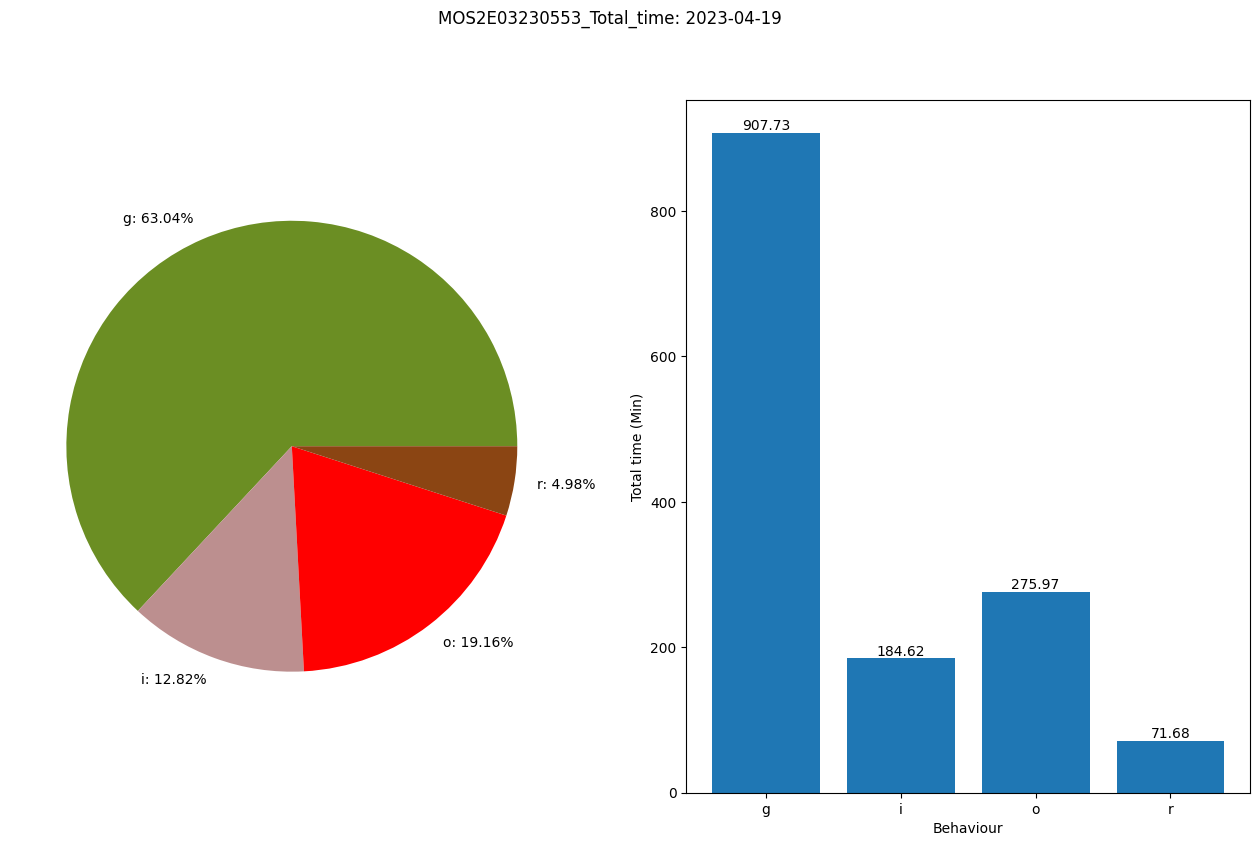

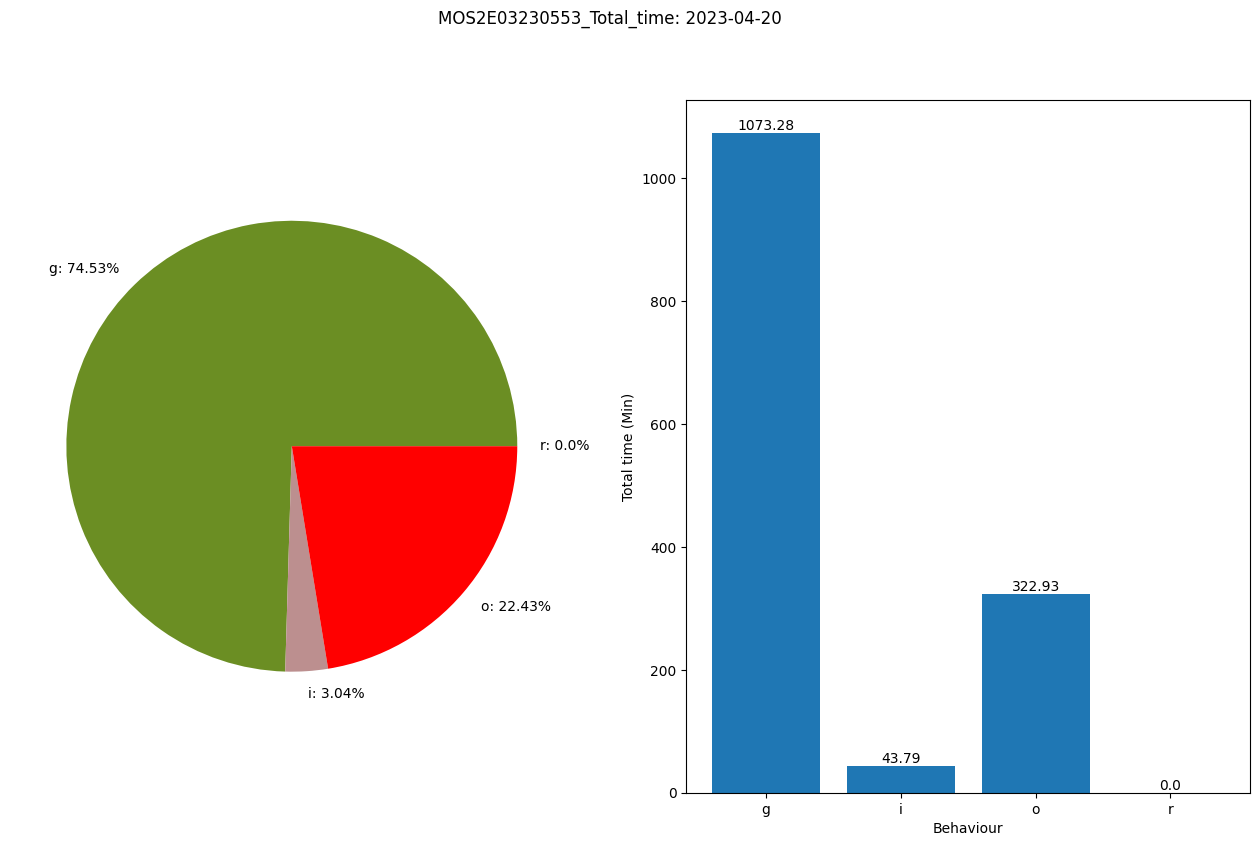

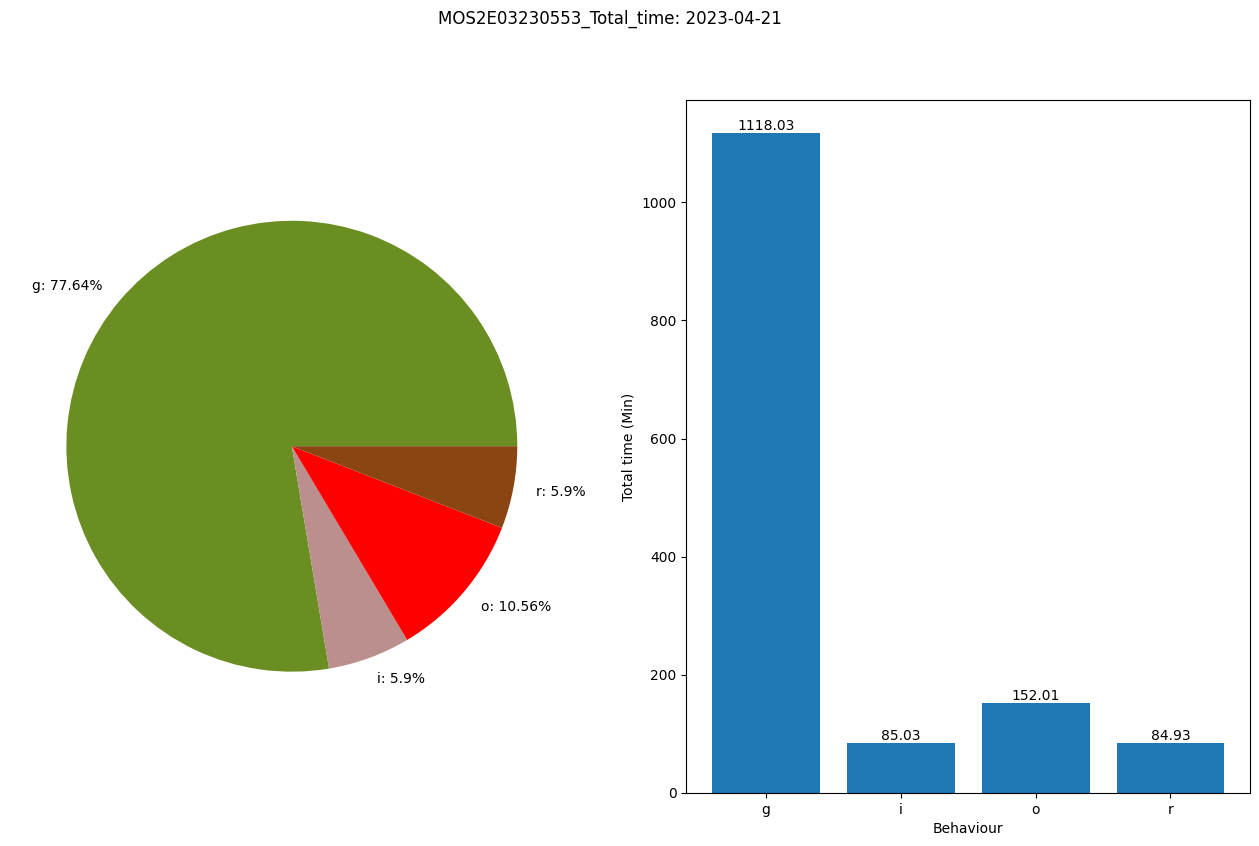

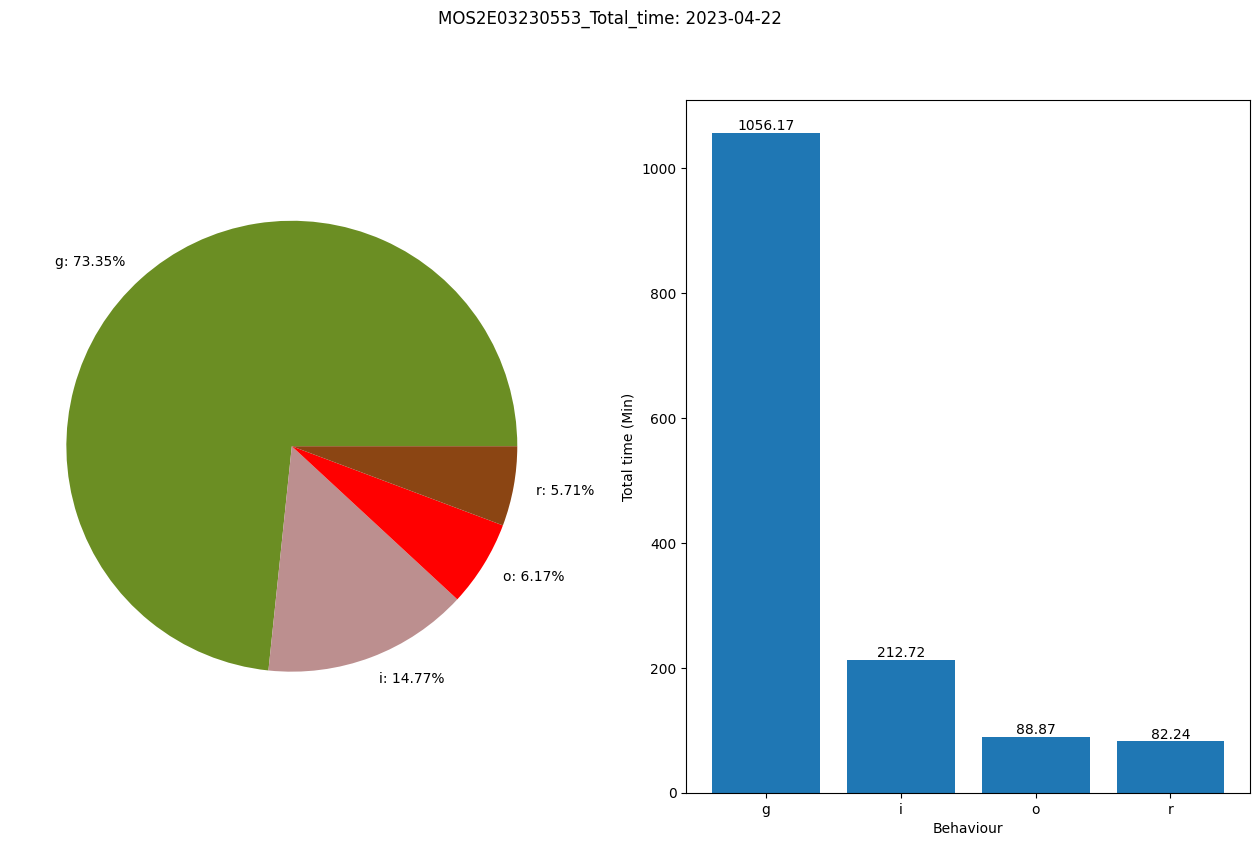

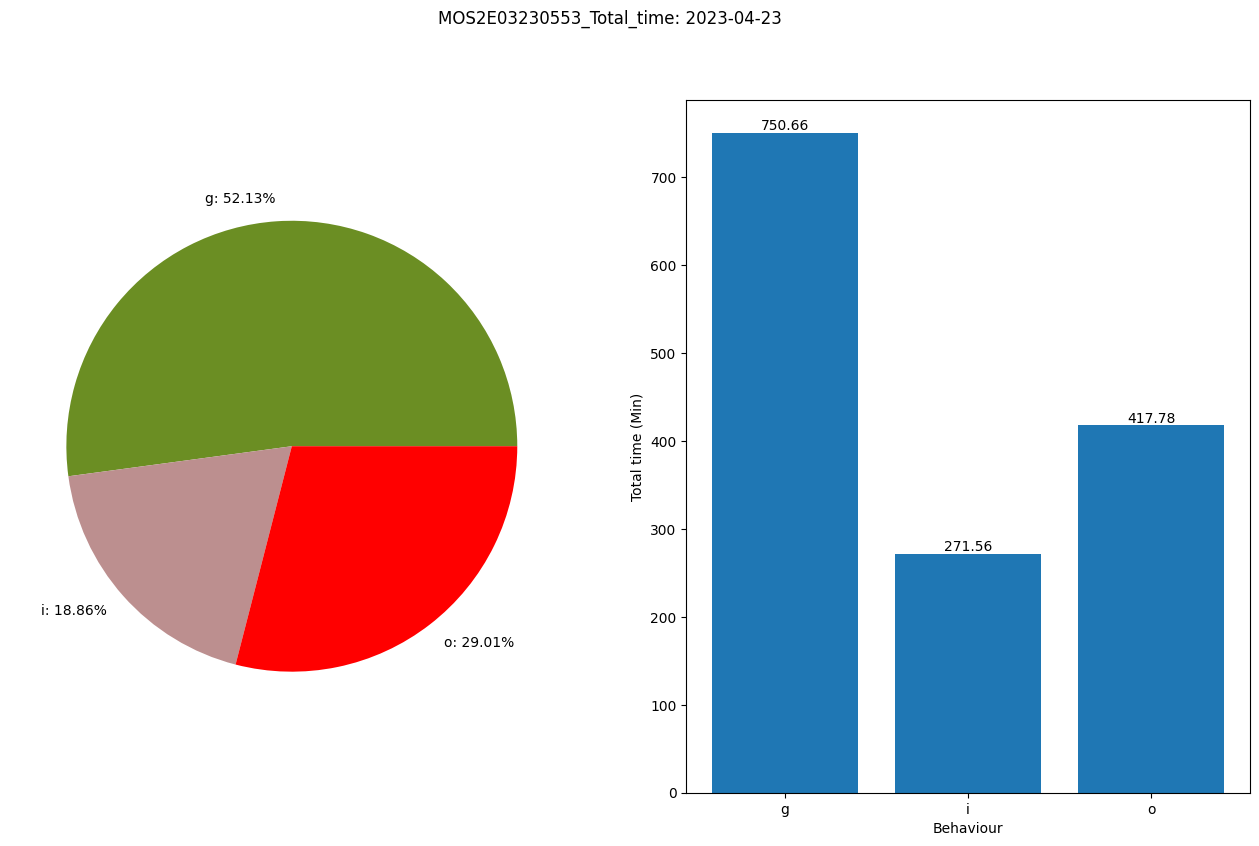

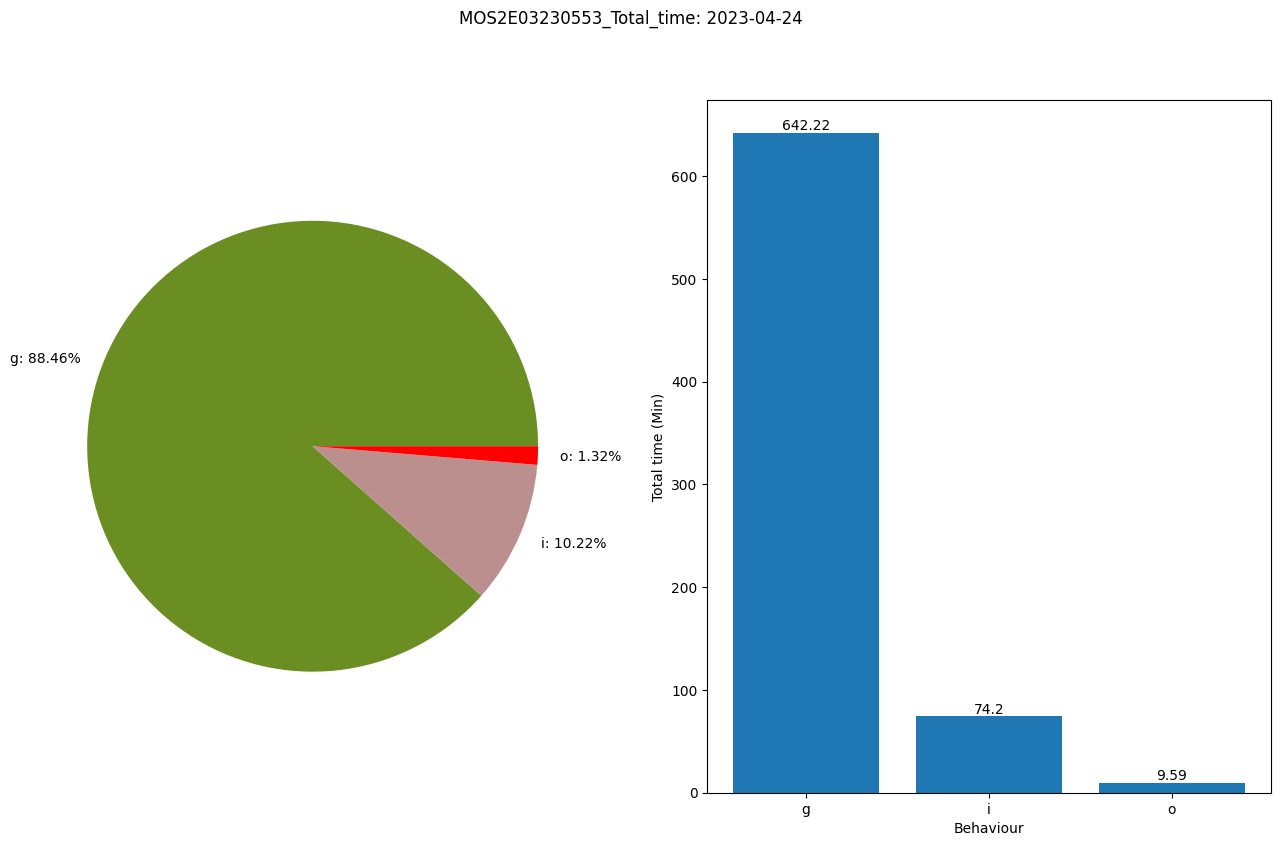

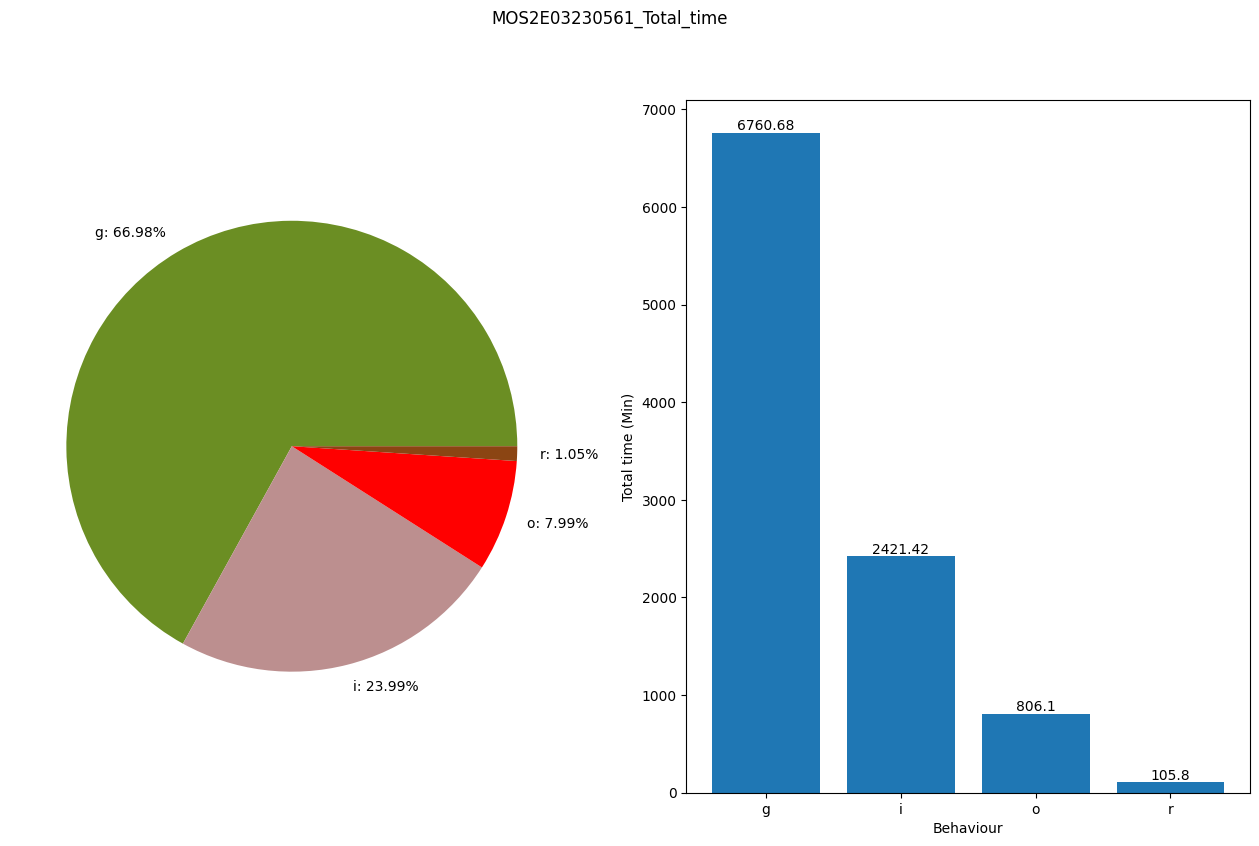

plotted


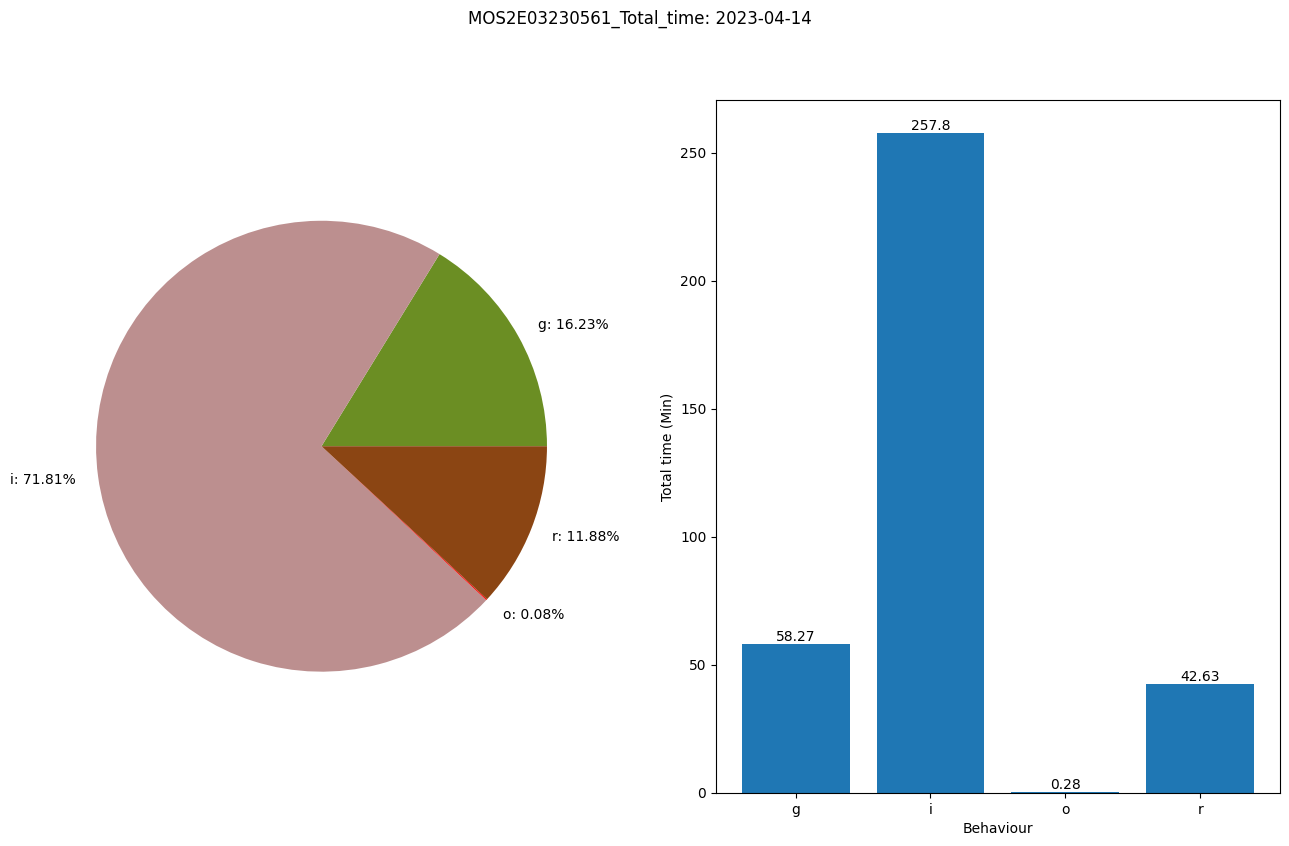

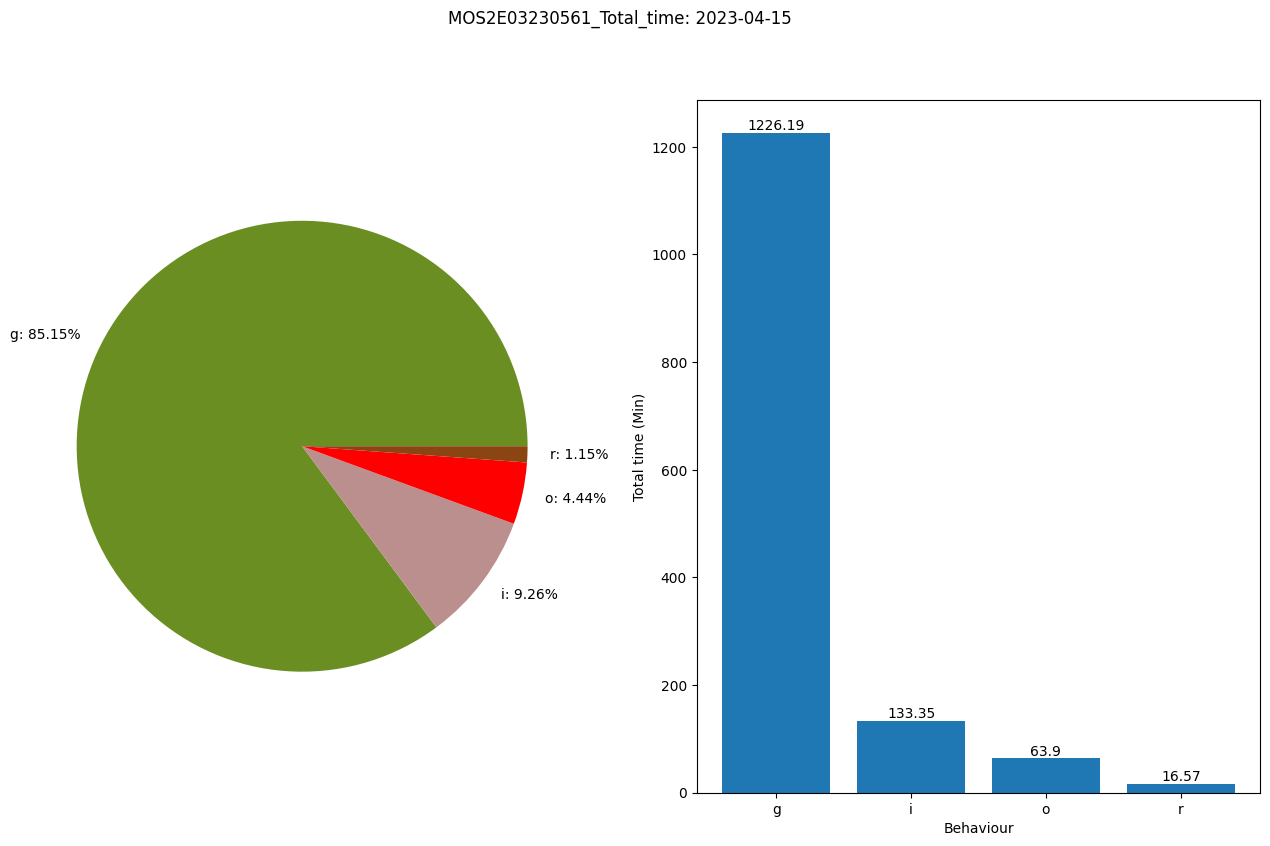

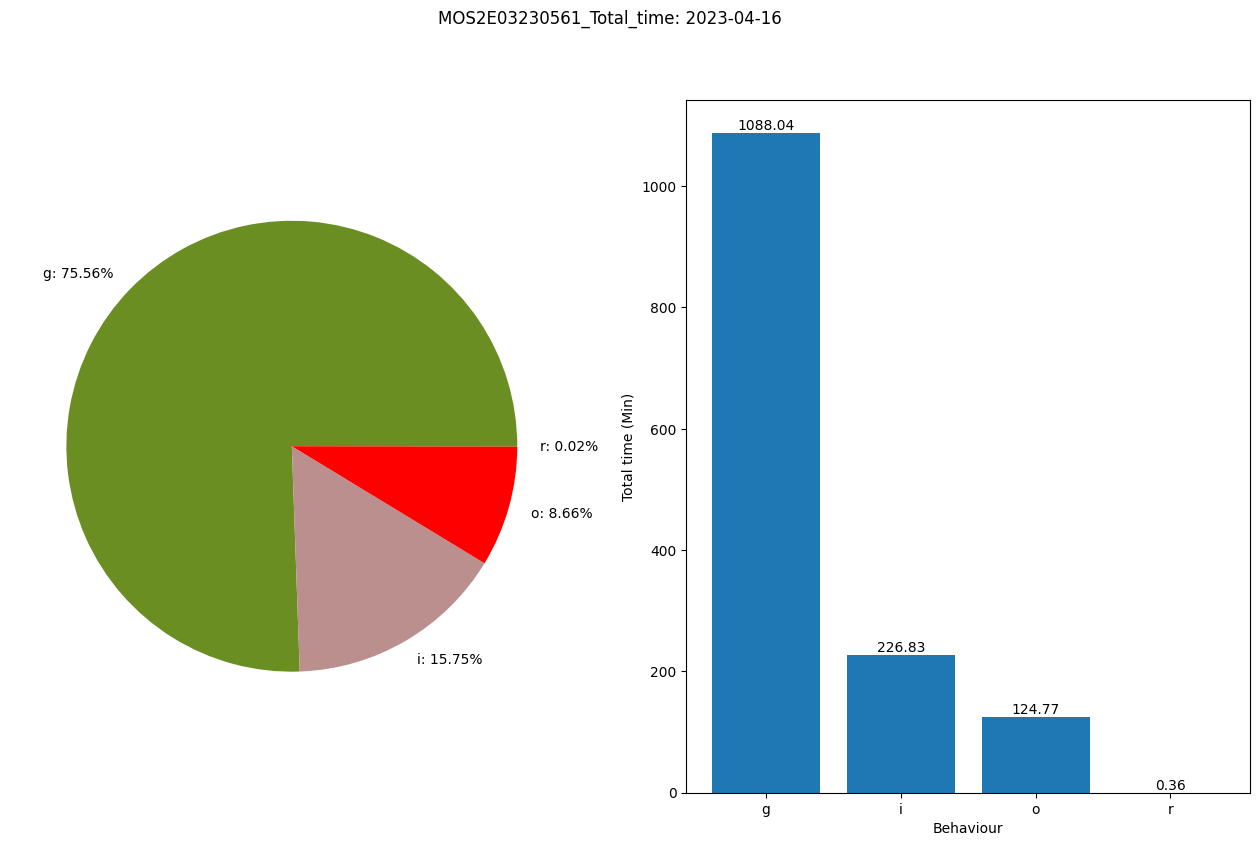

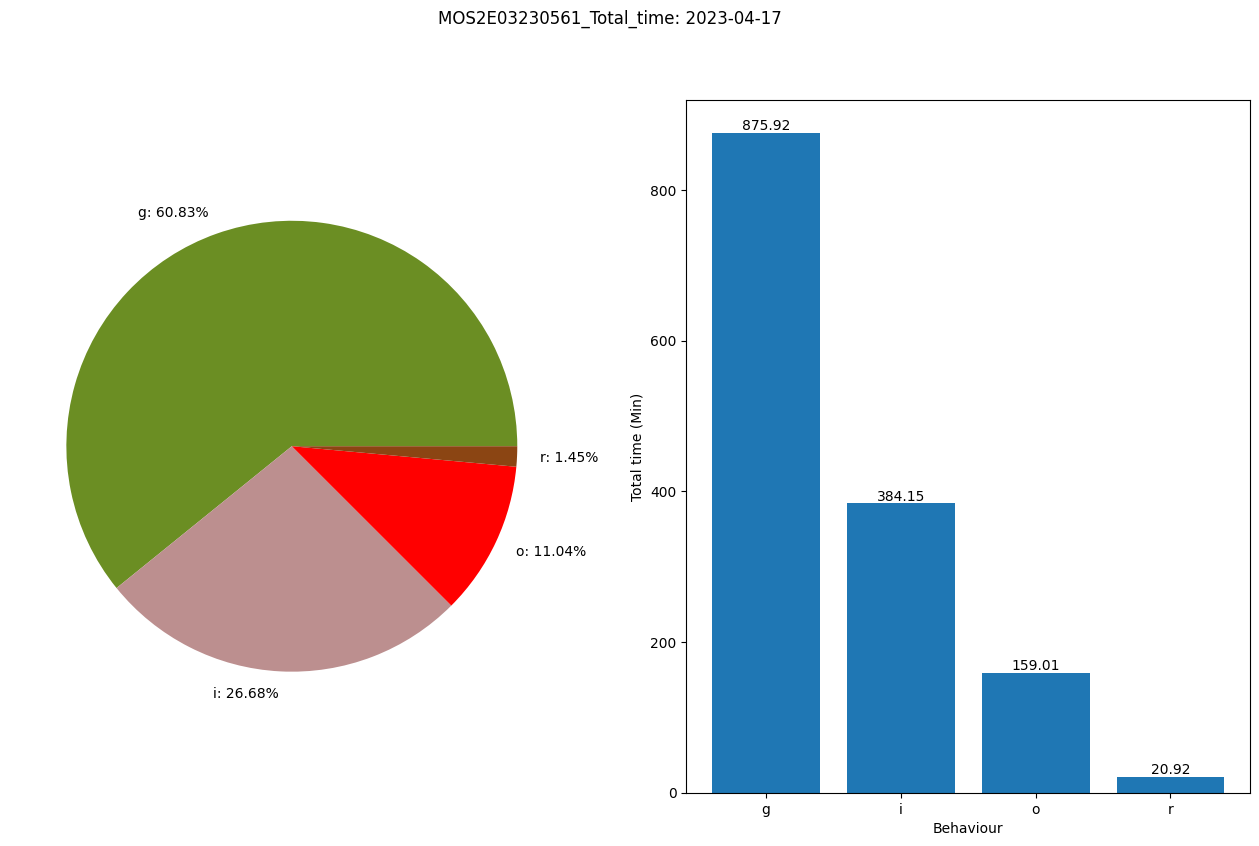

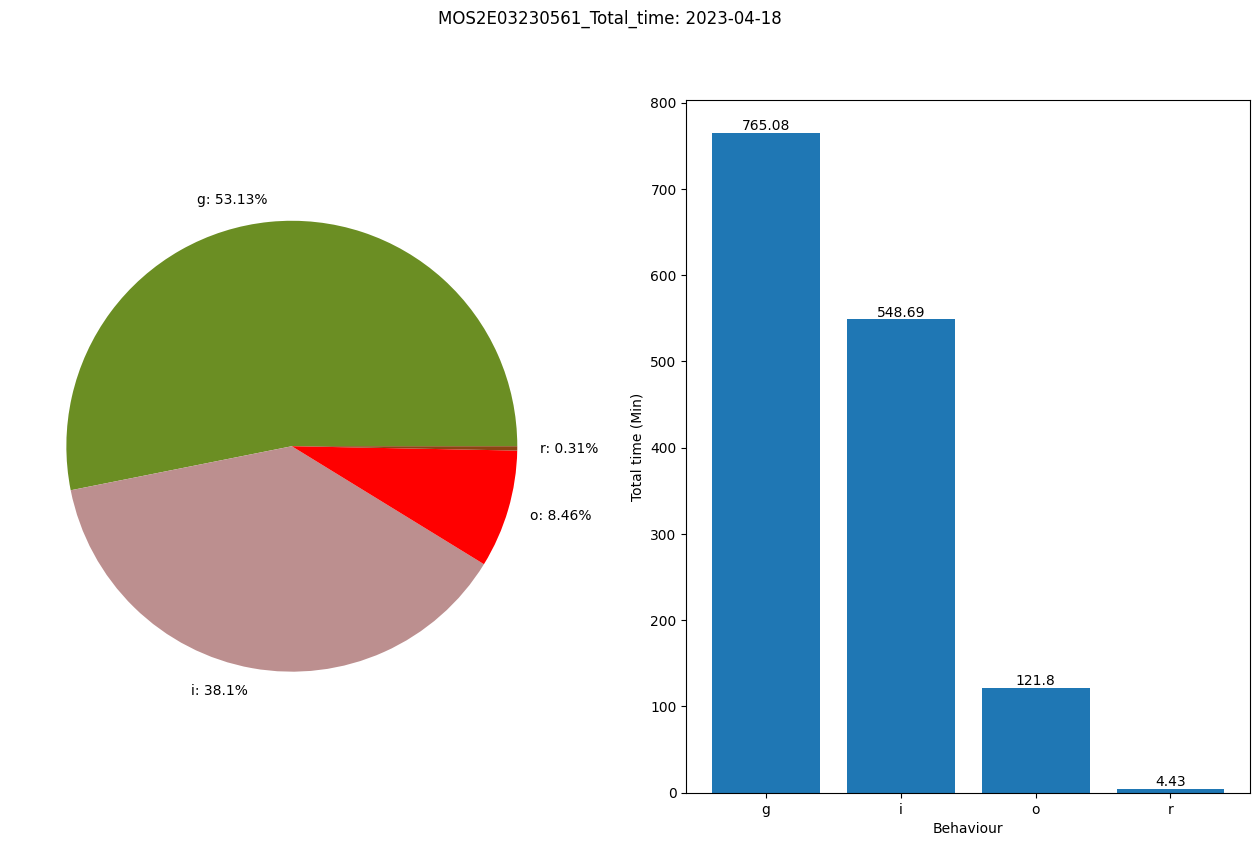

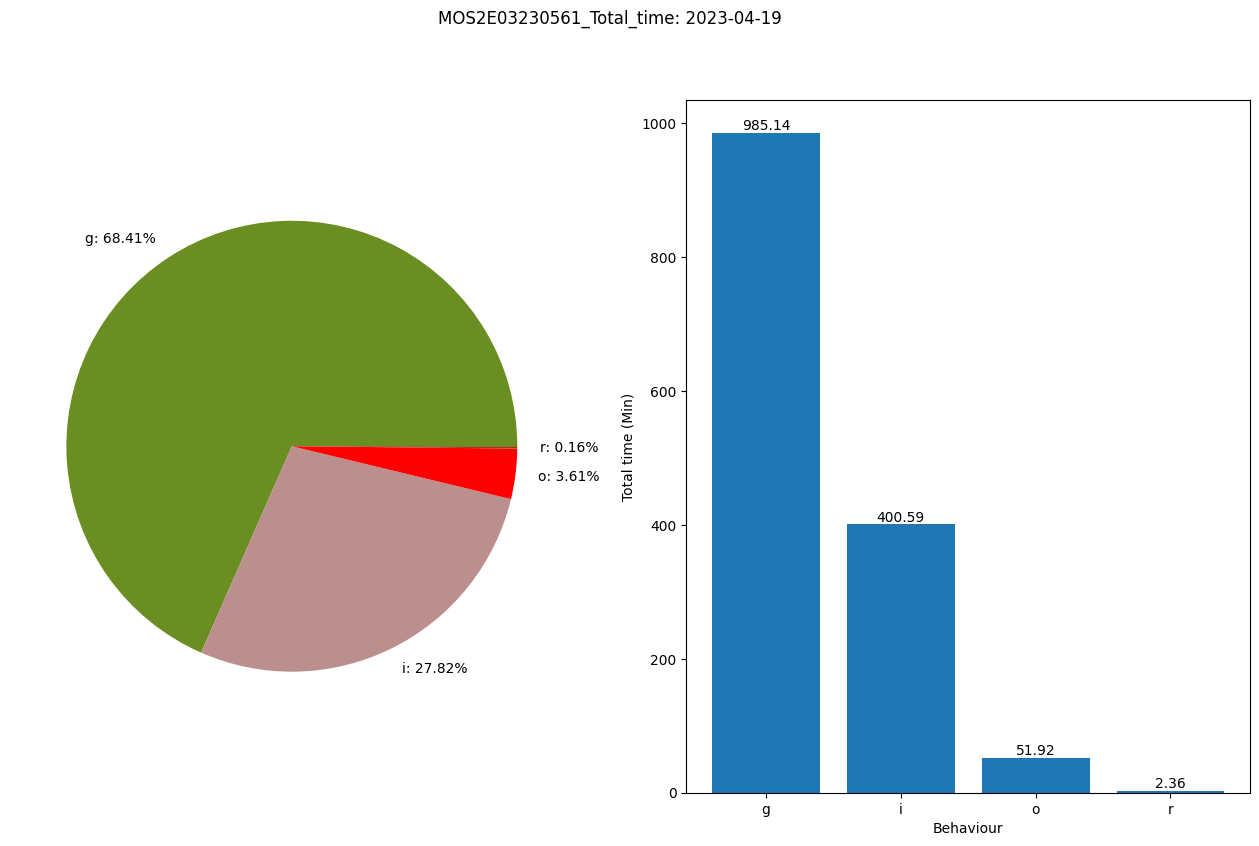

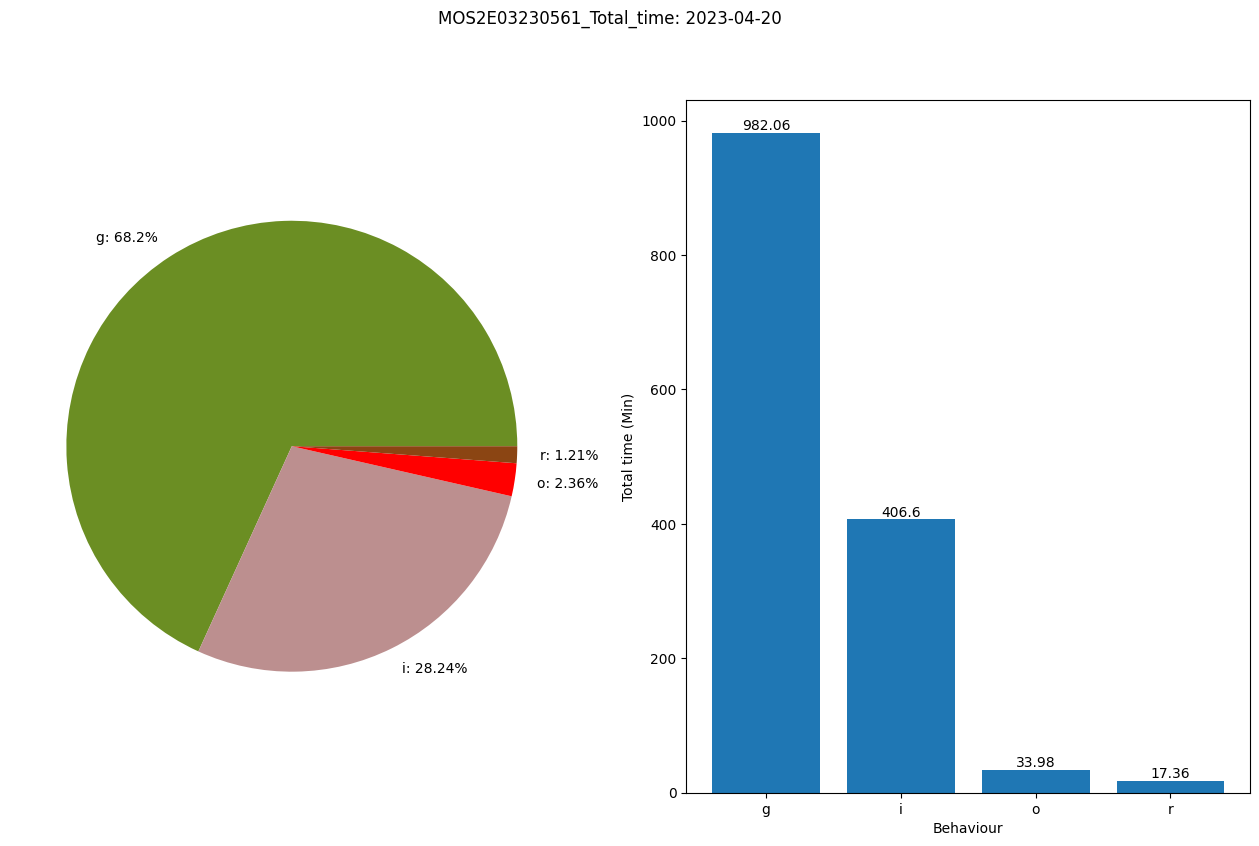

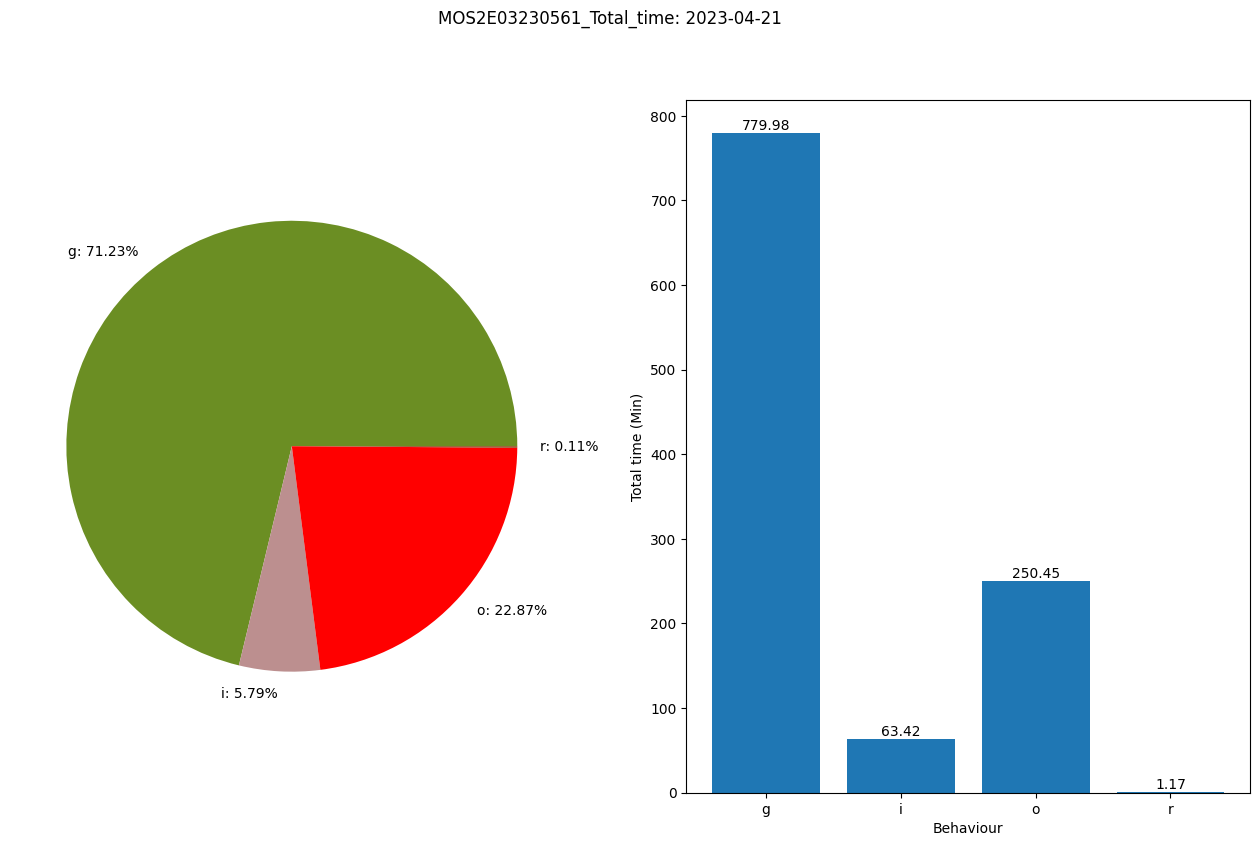

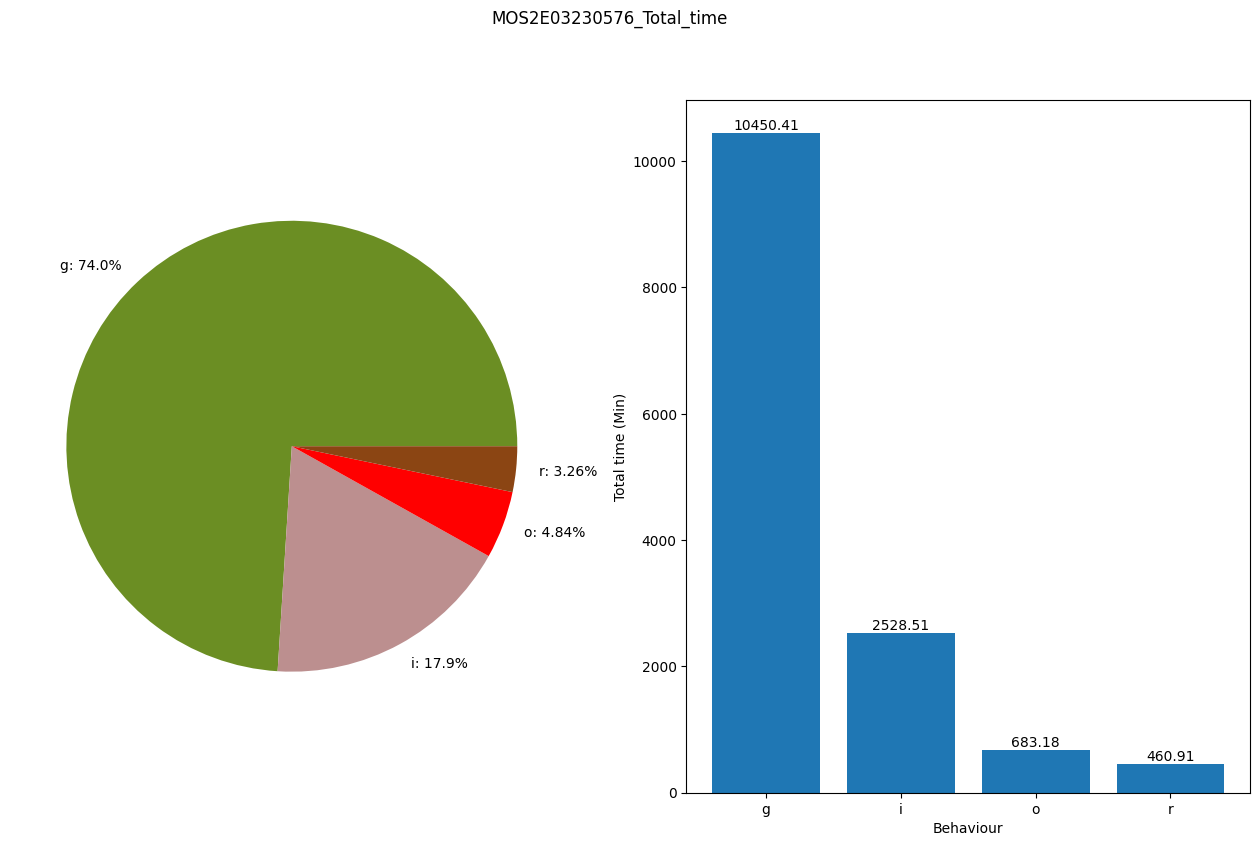

plotted


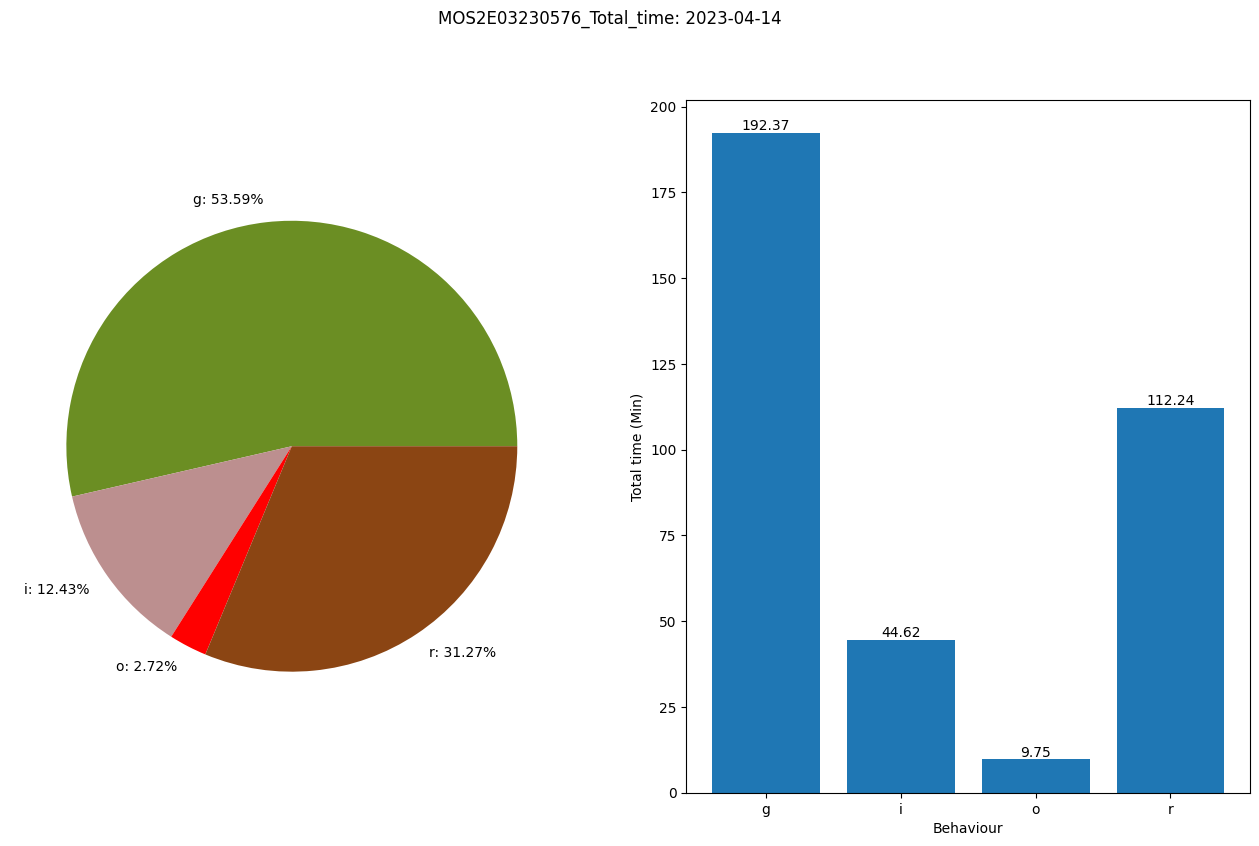

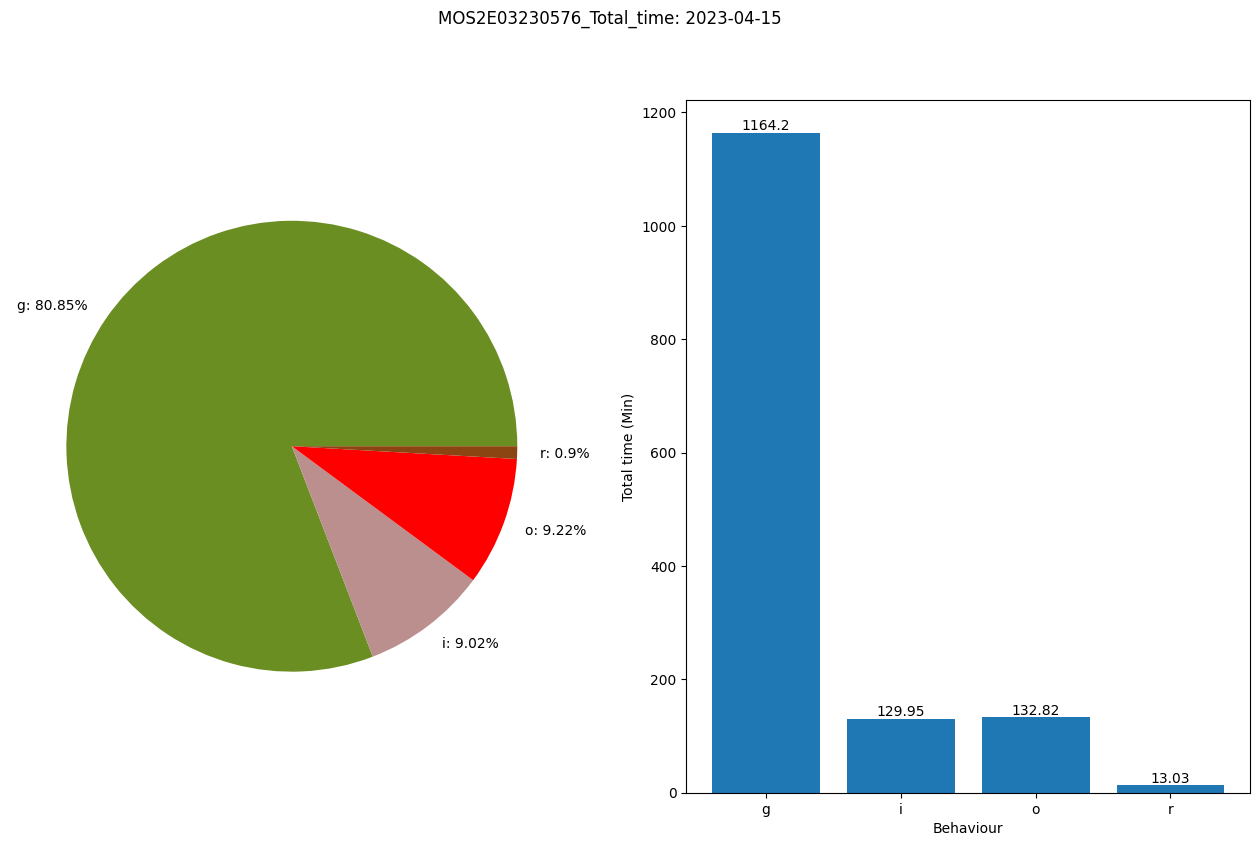

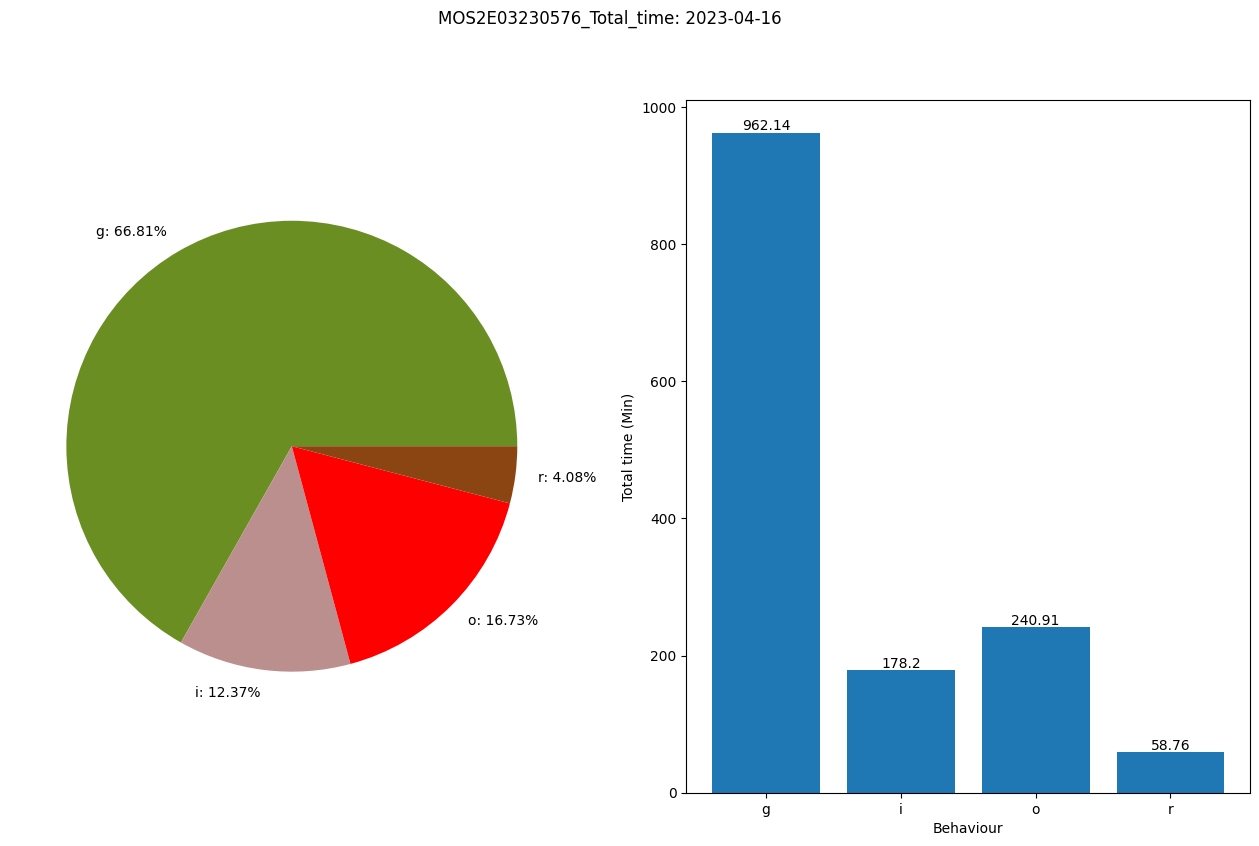

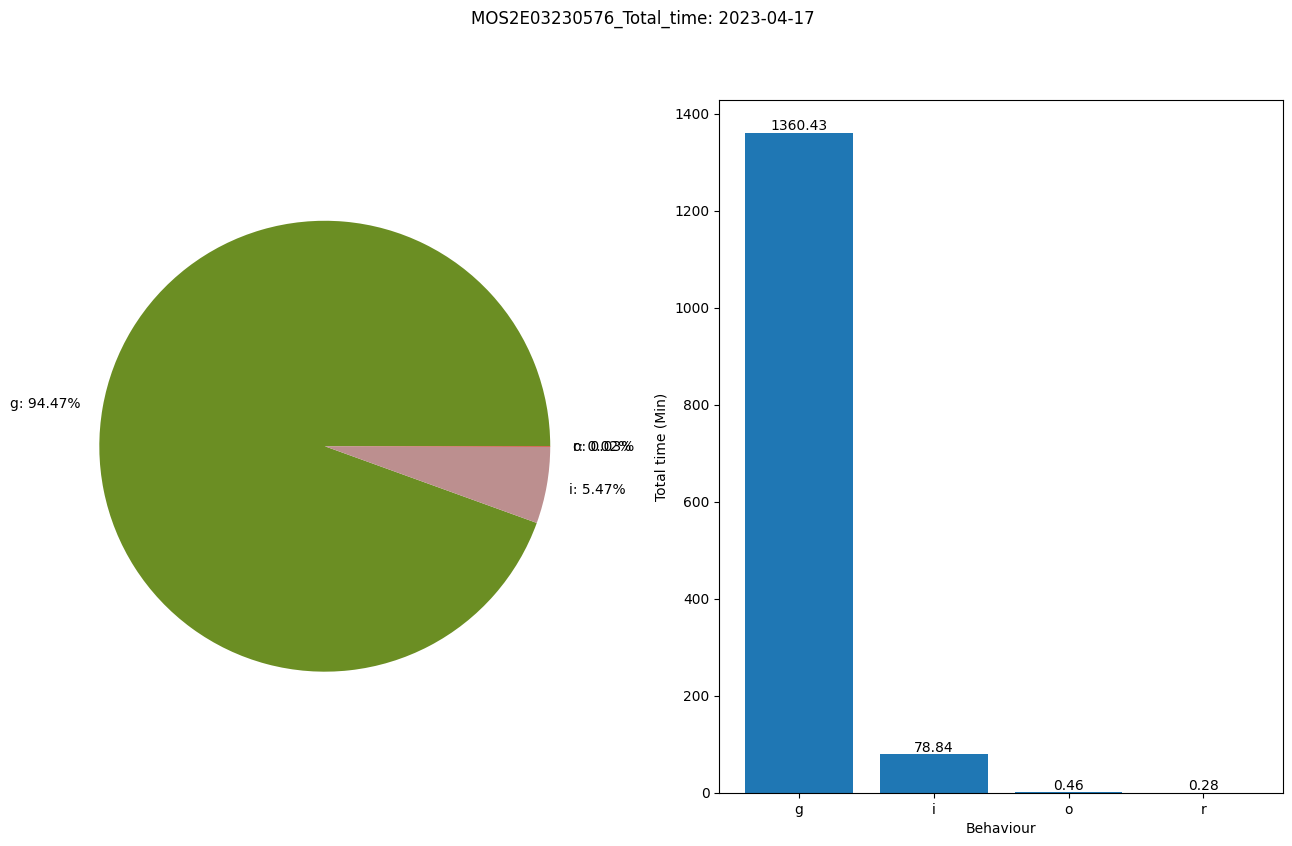

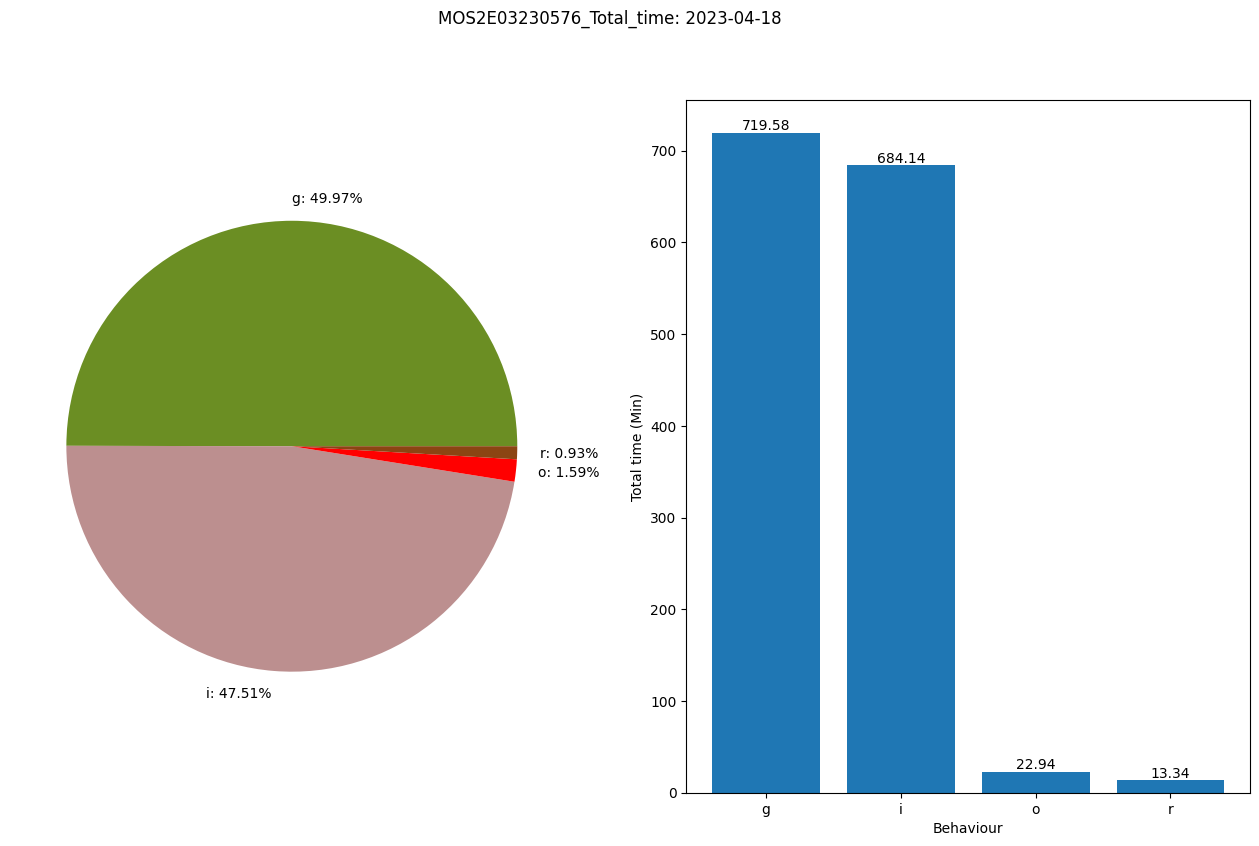

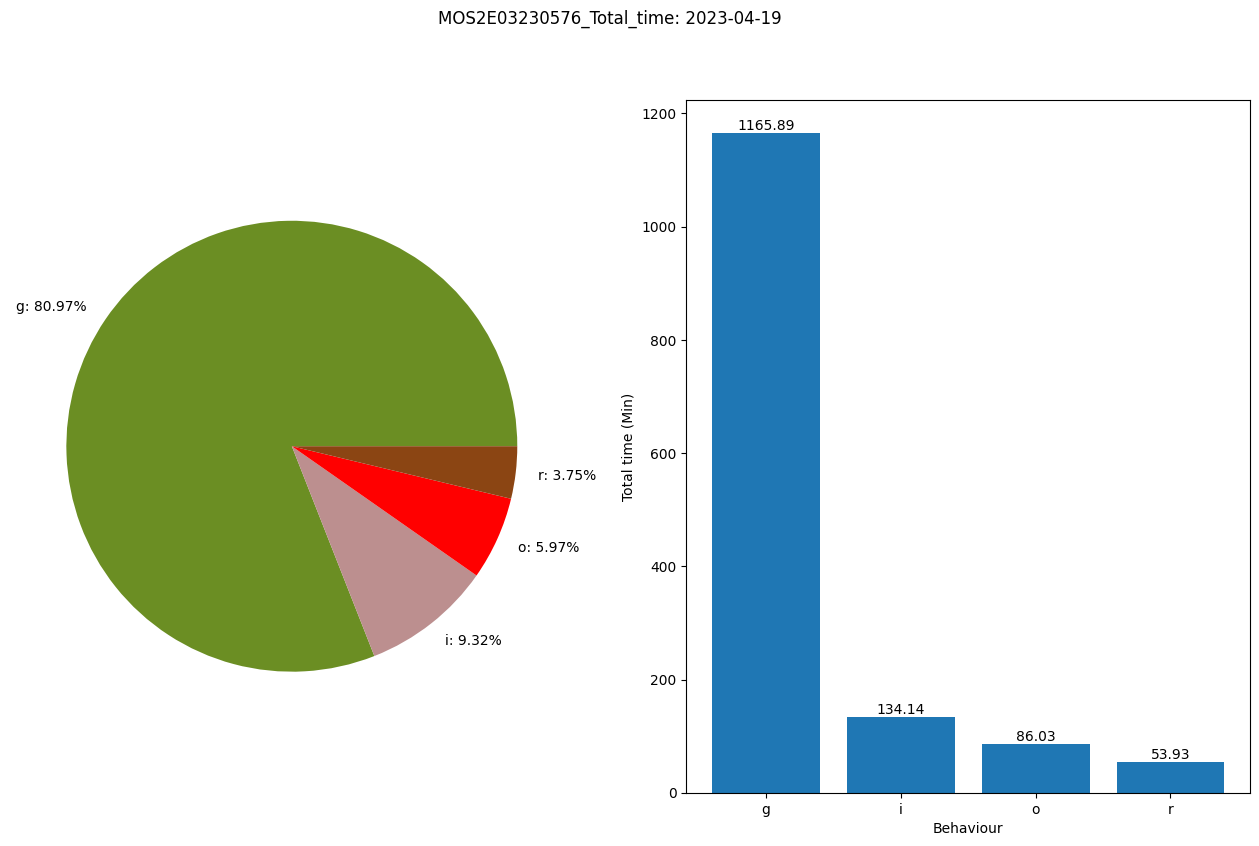

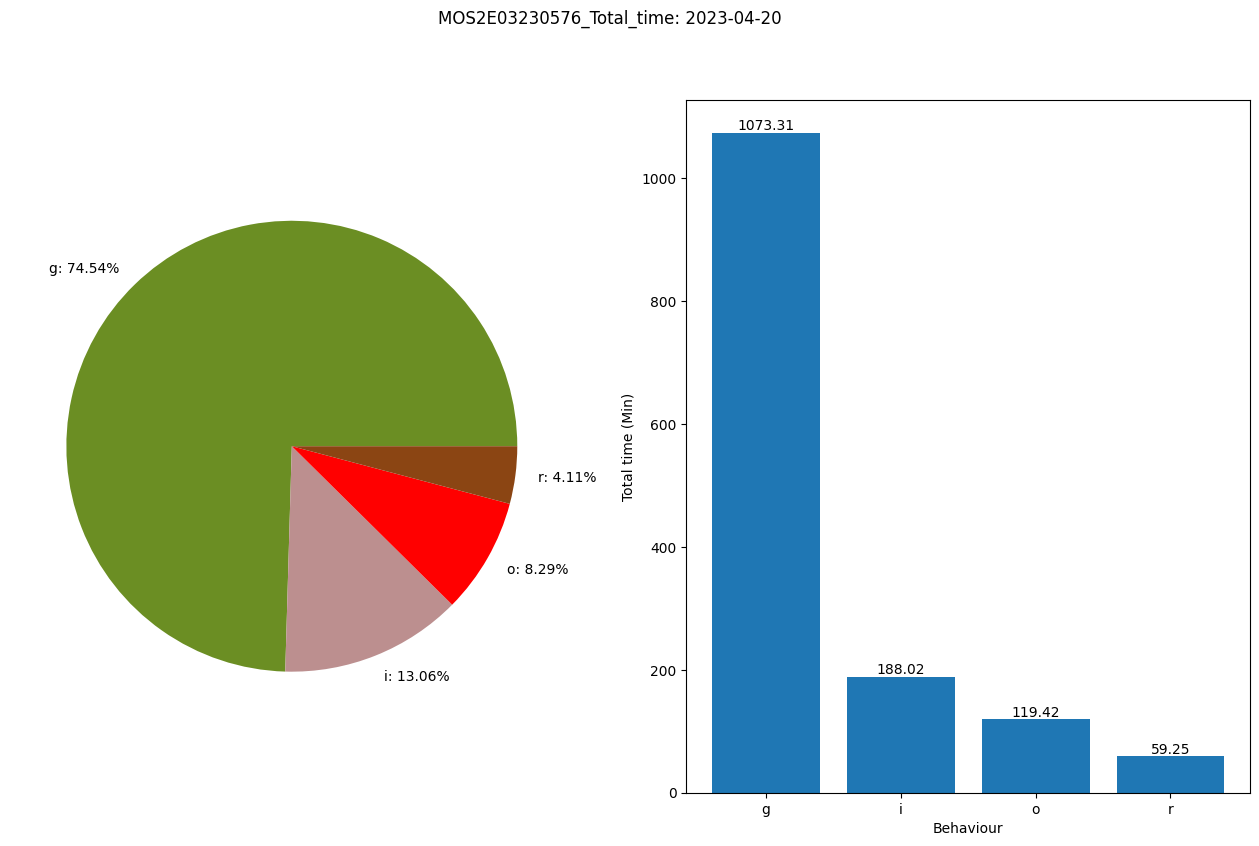

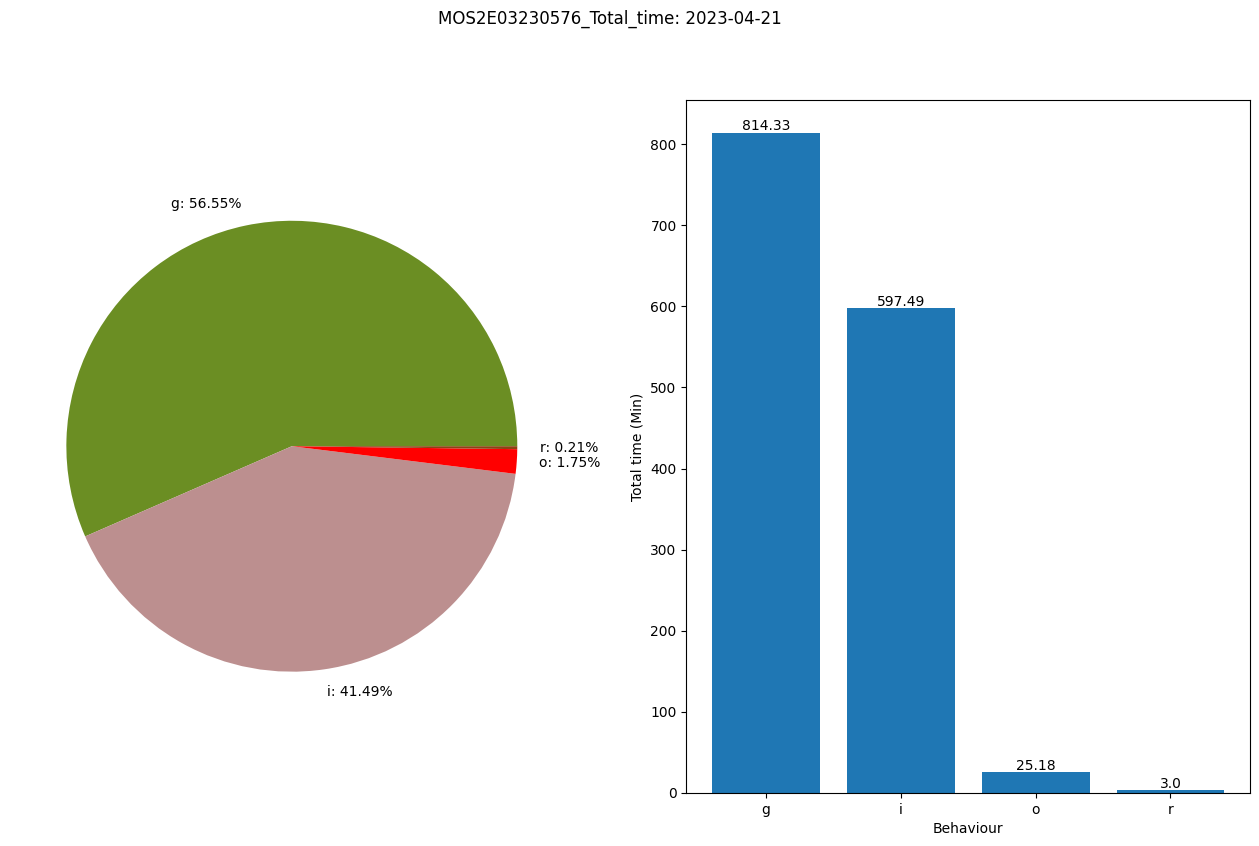

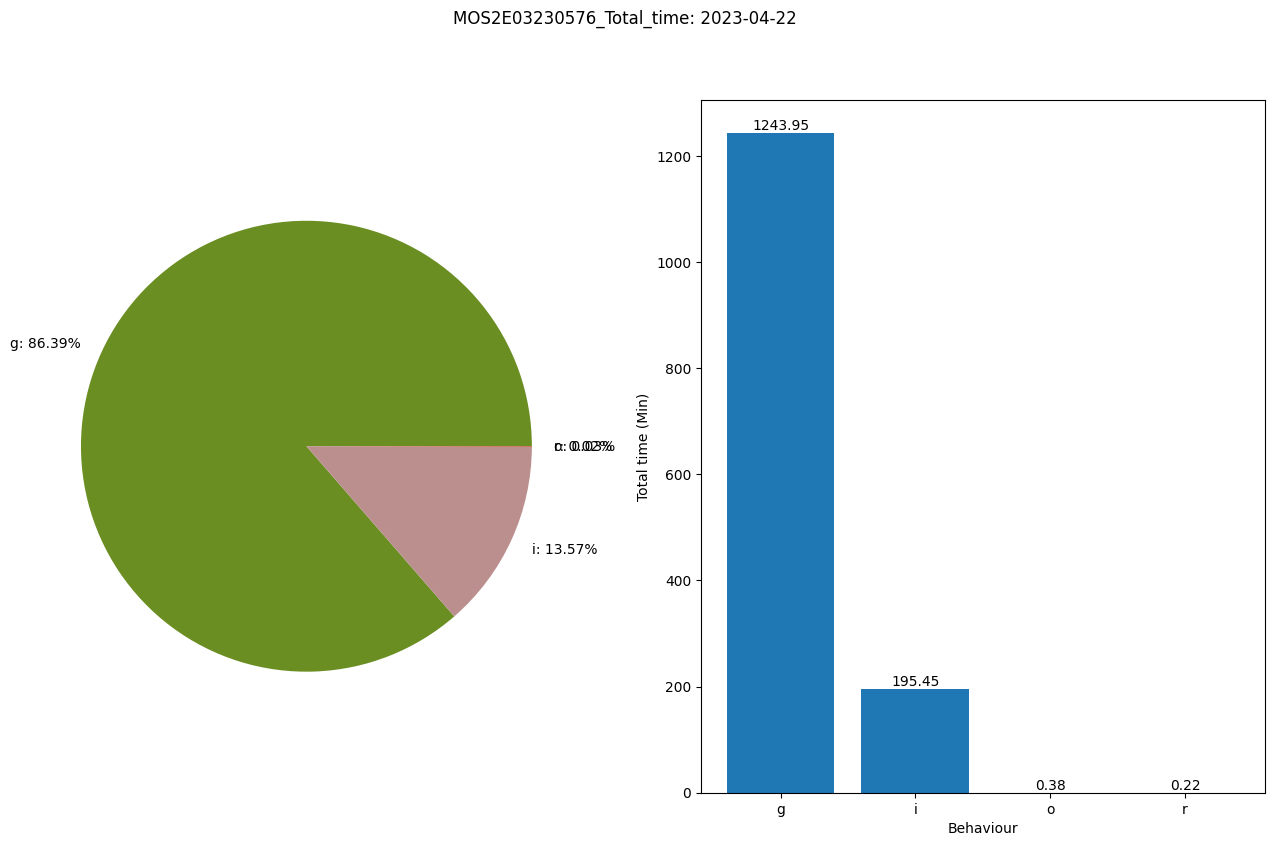

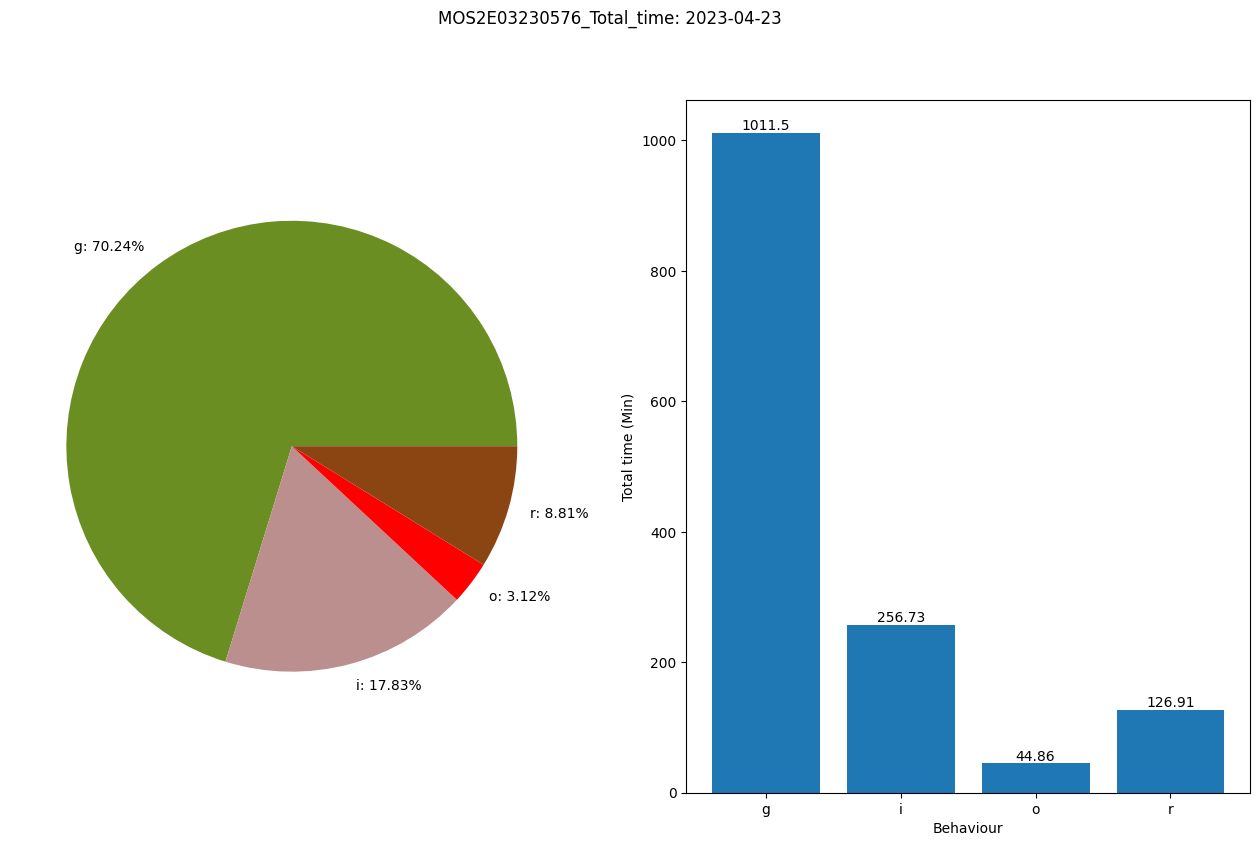

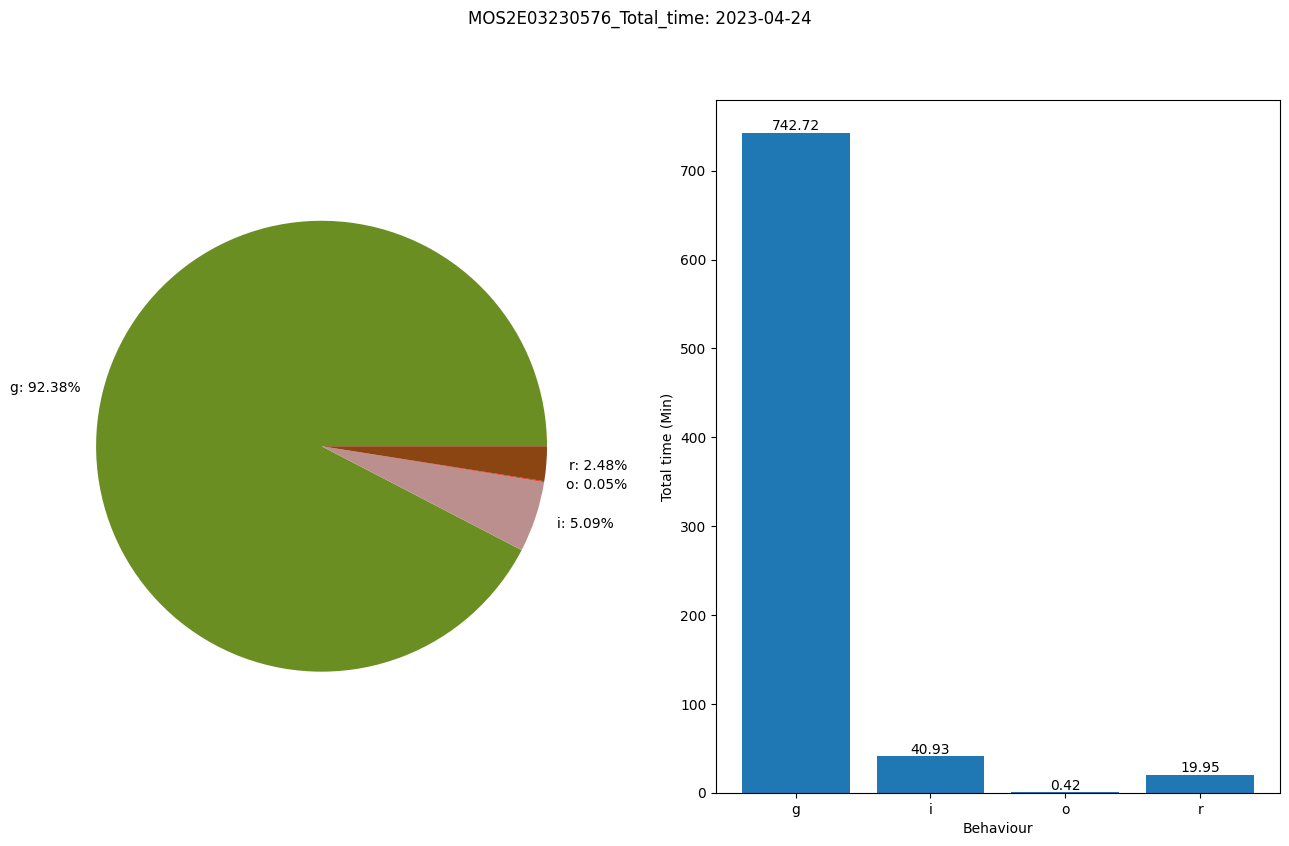

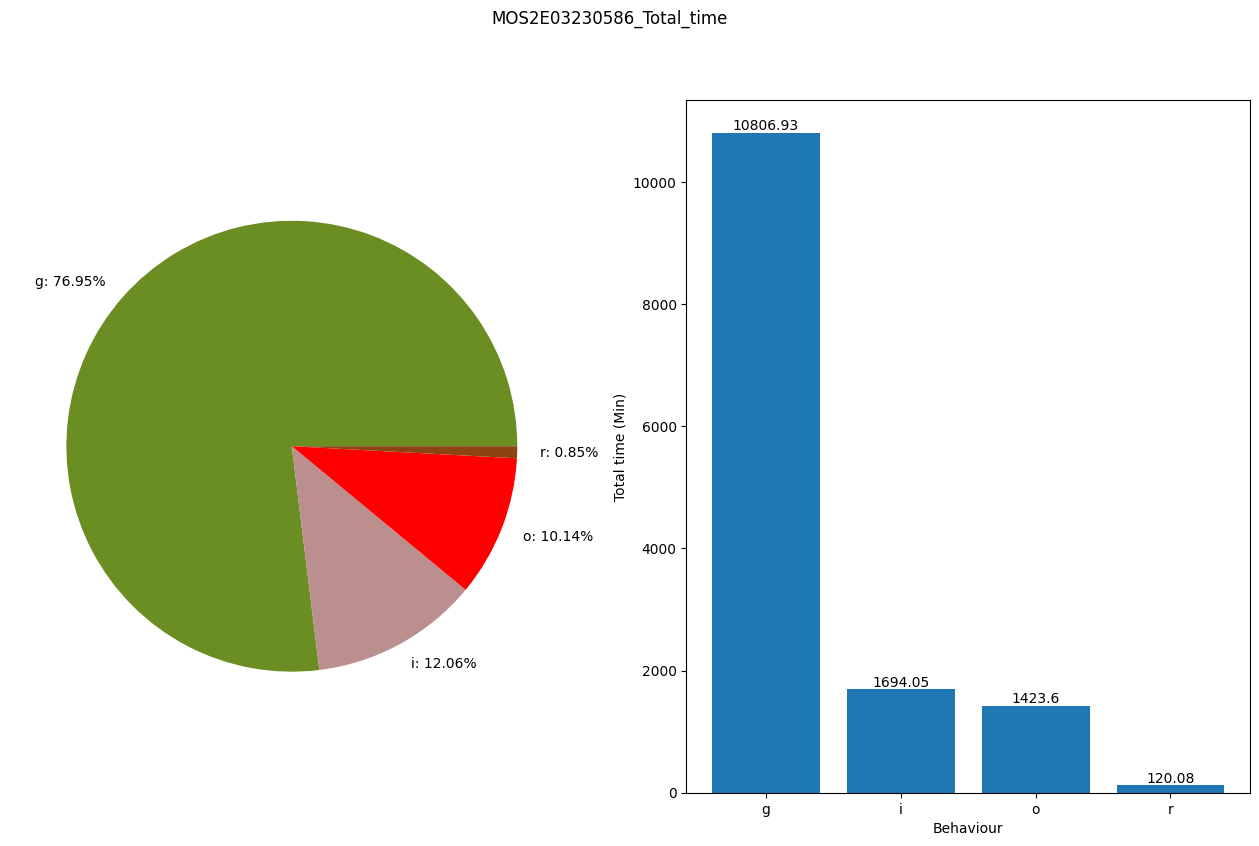

plotted


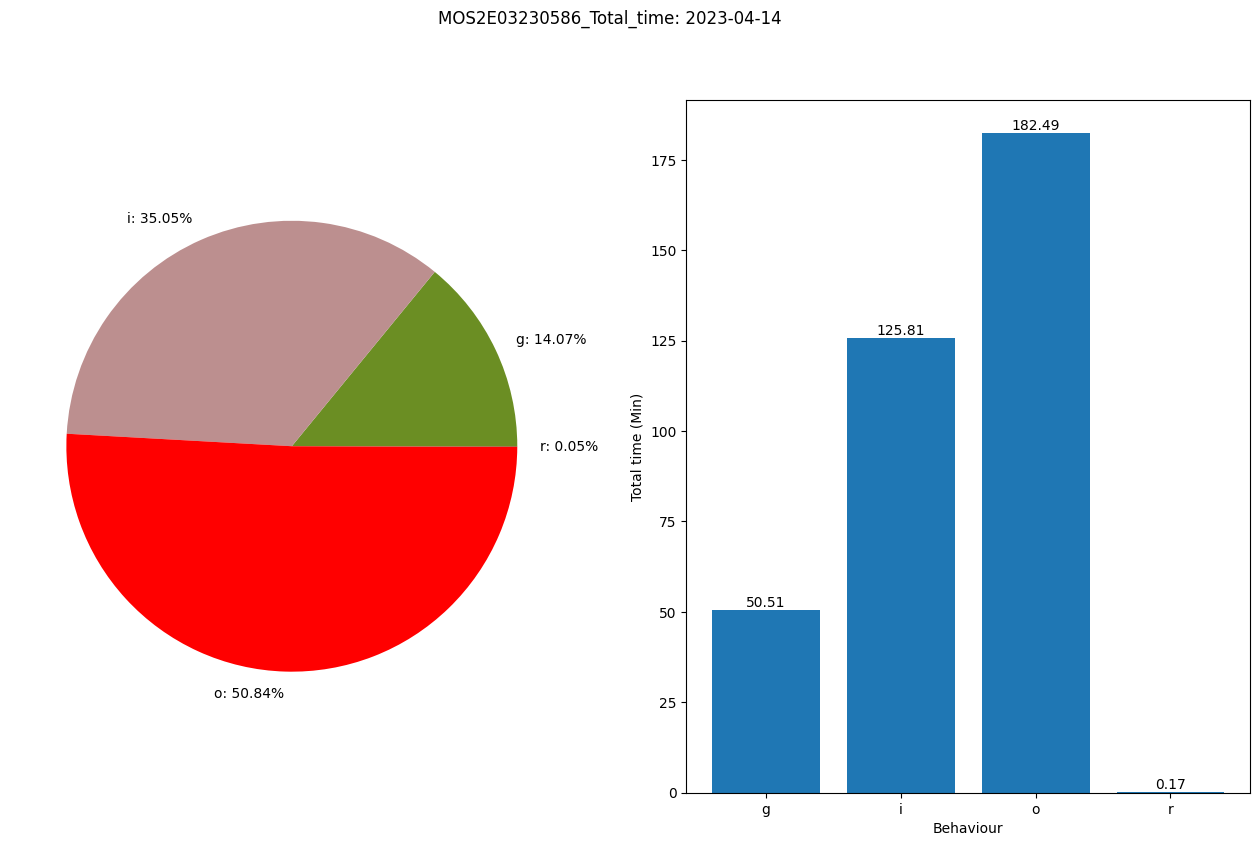

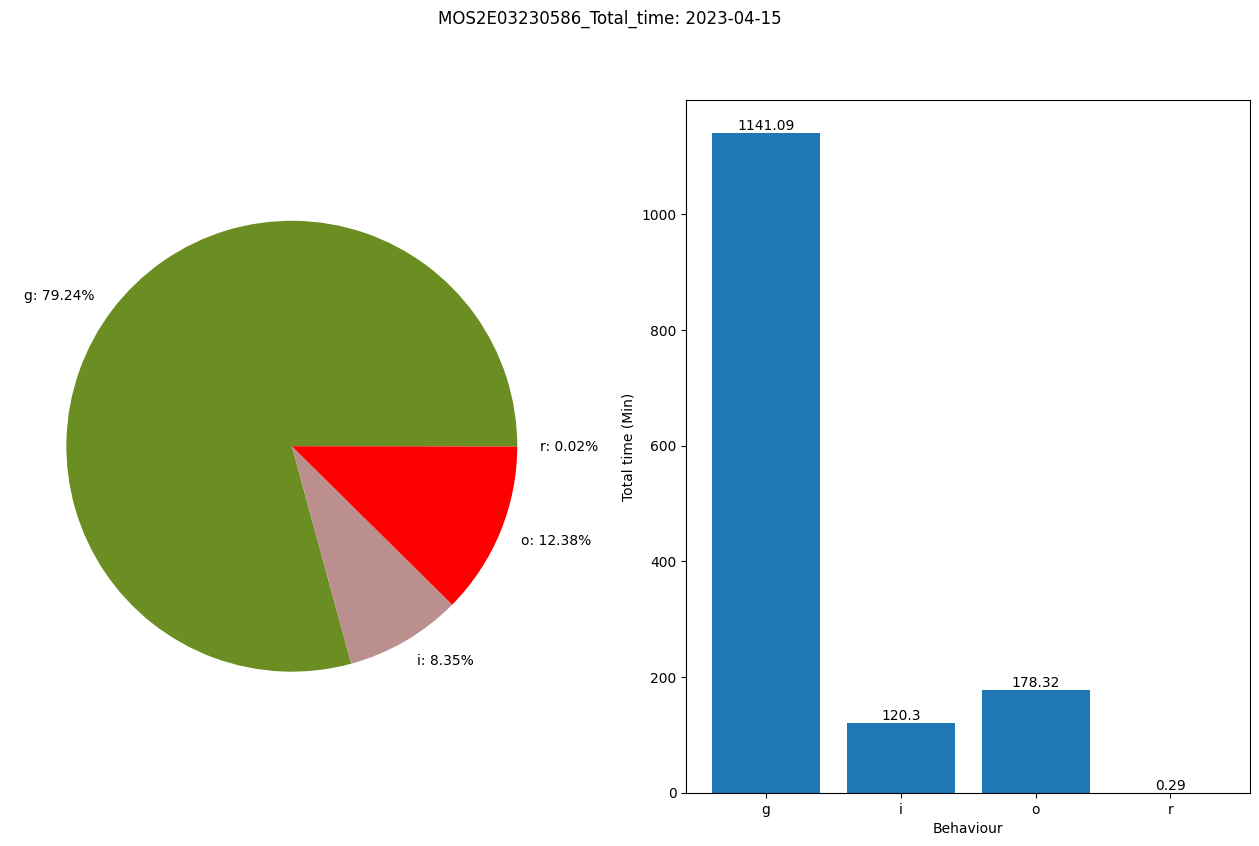

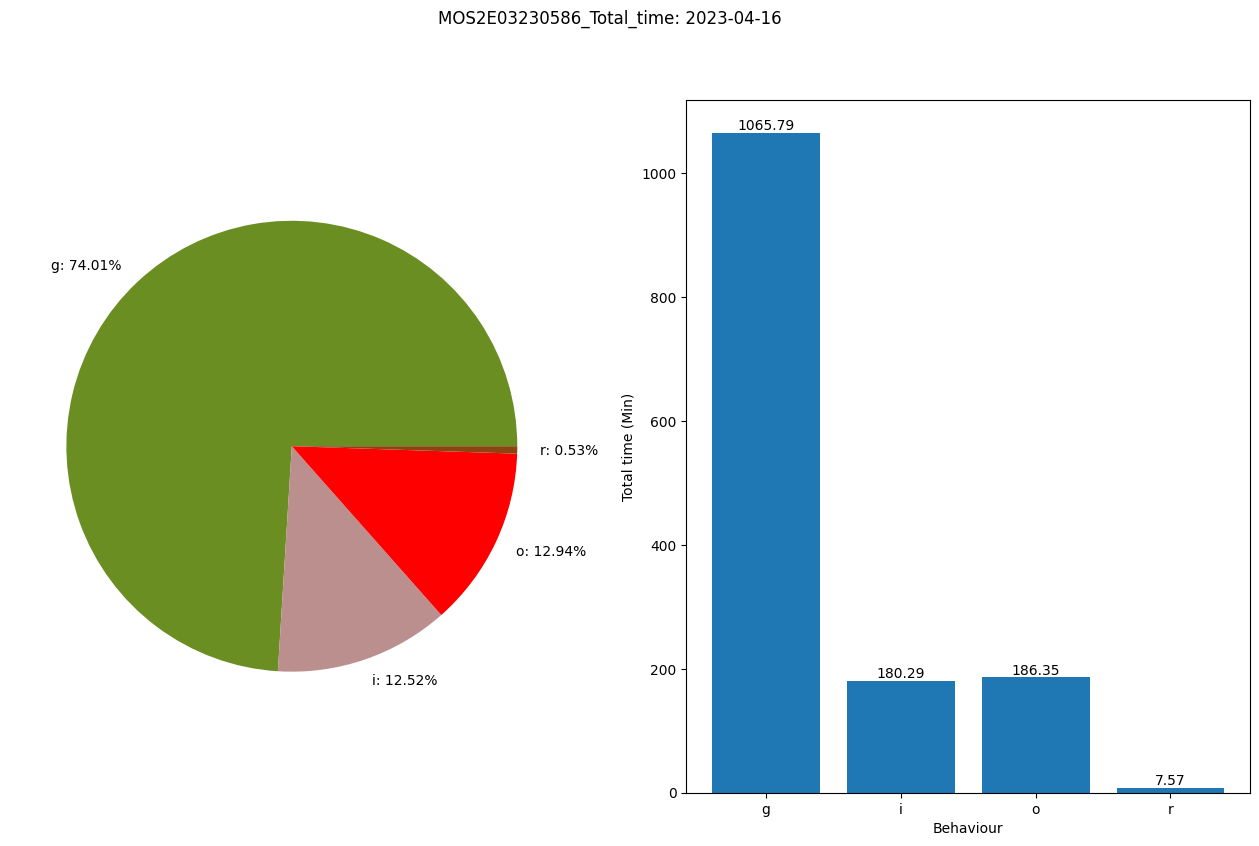

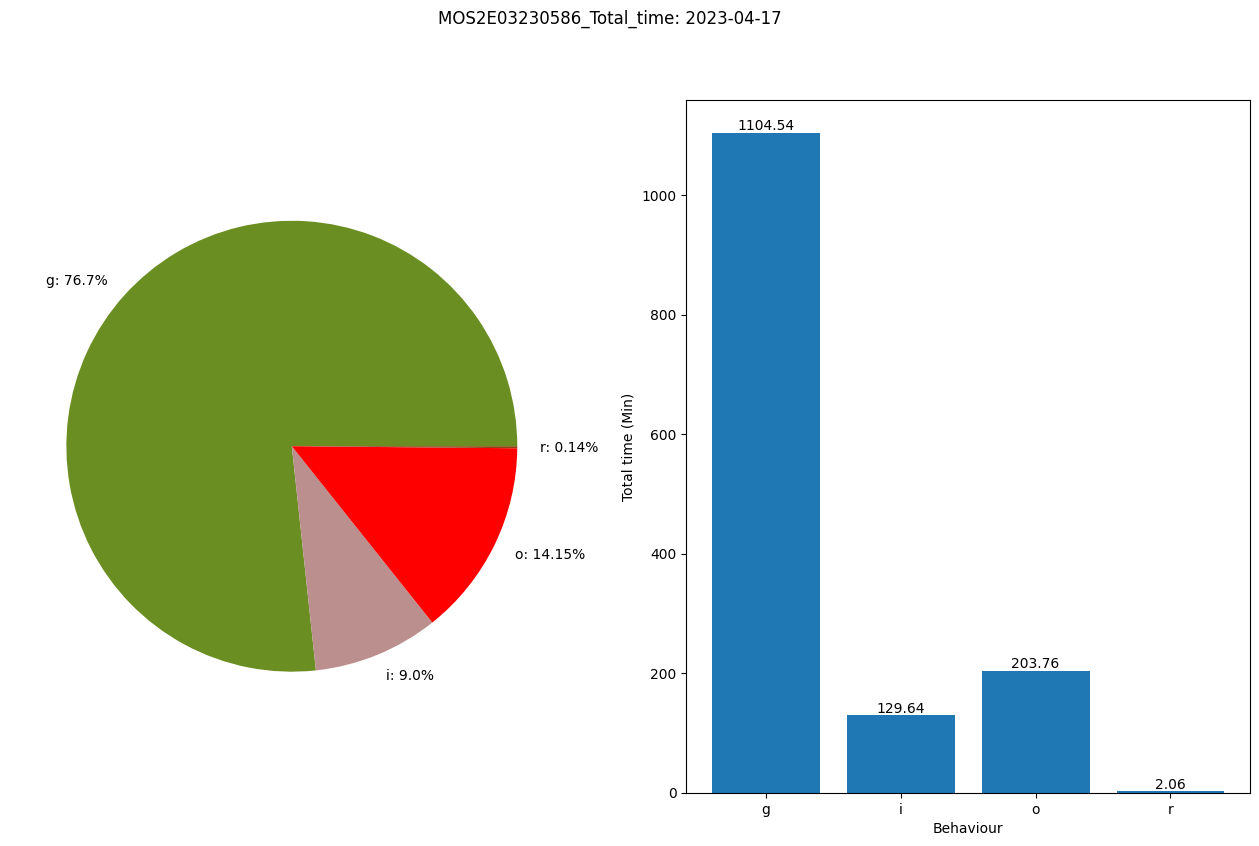

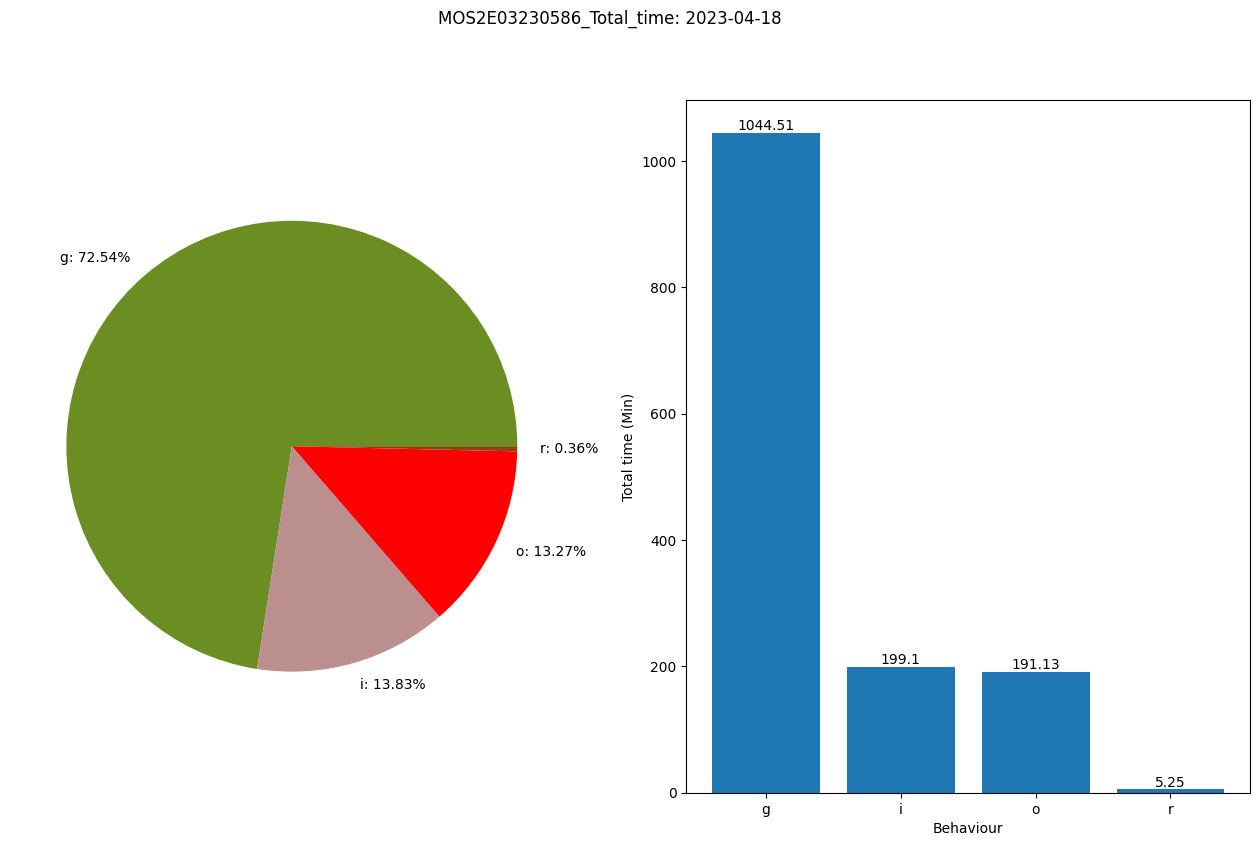

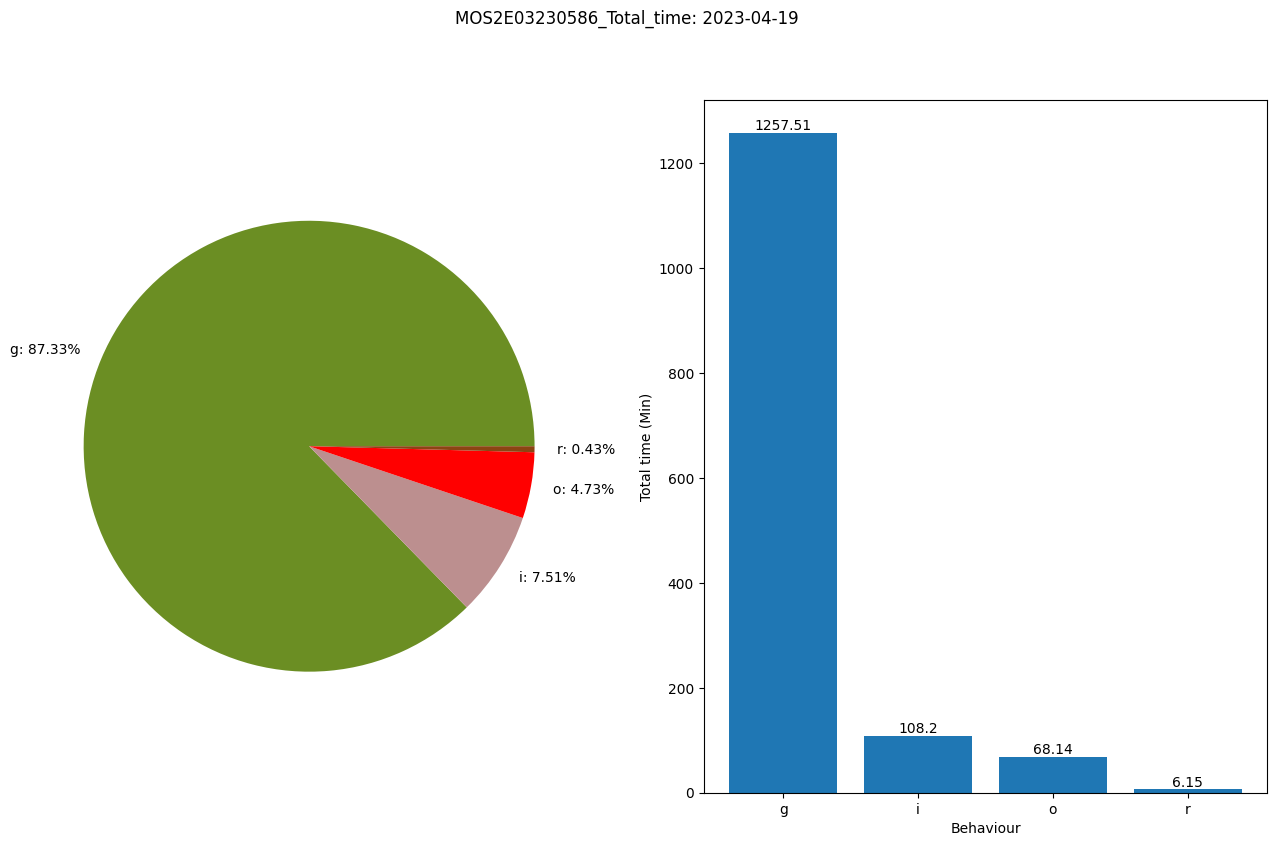

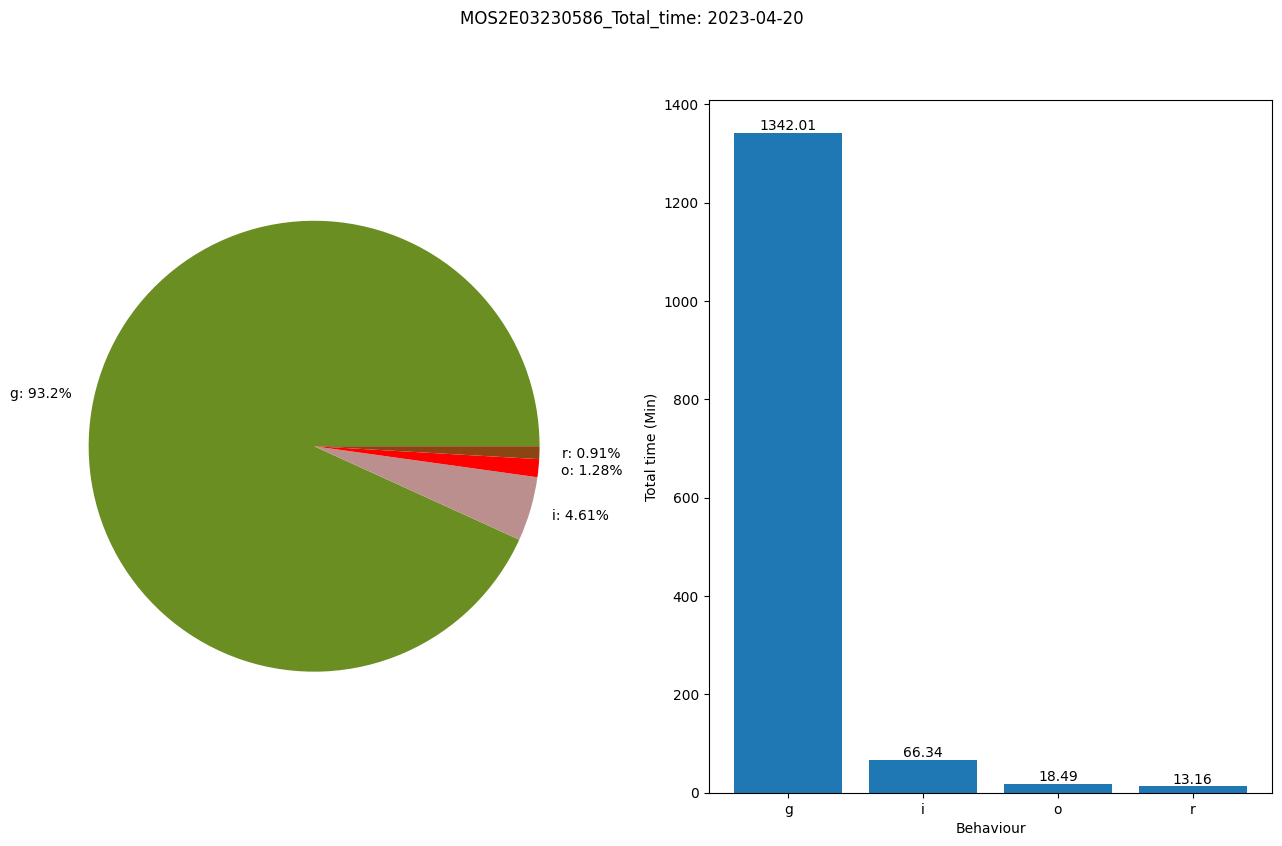

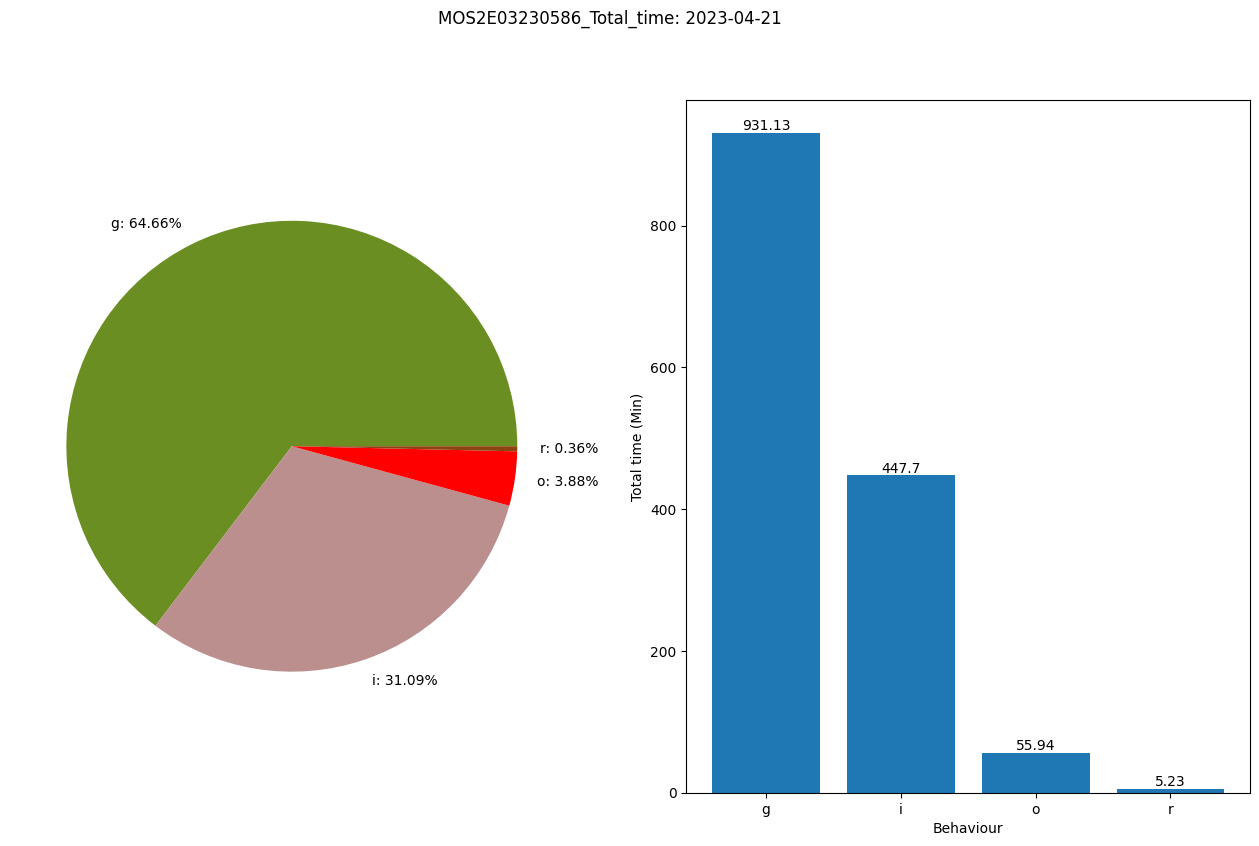

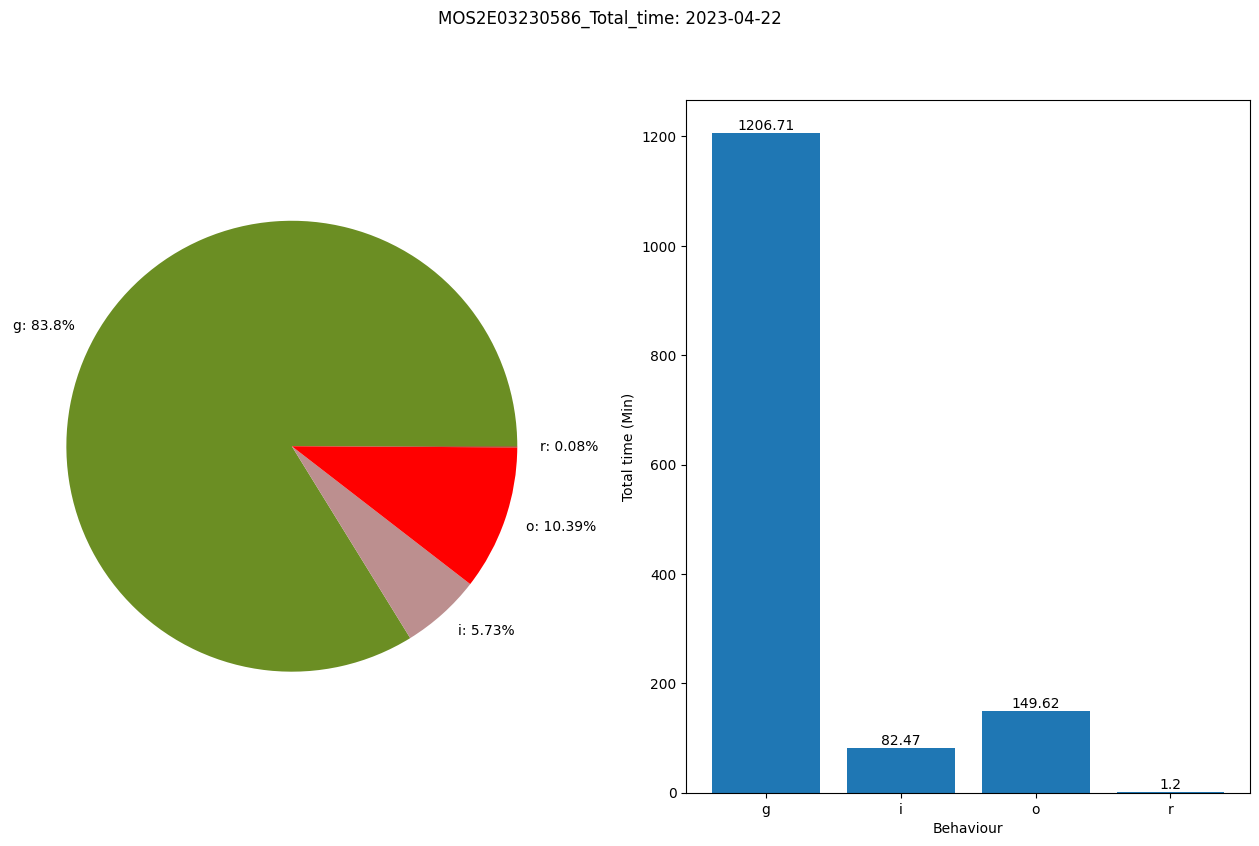

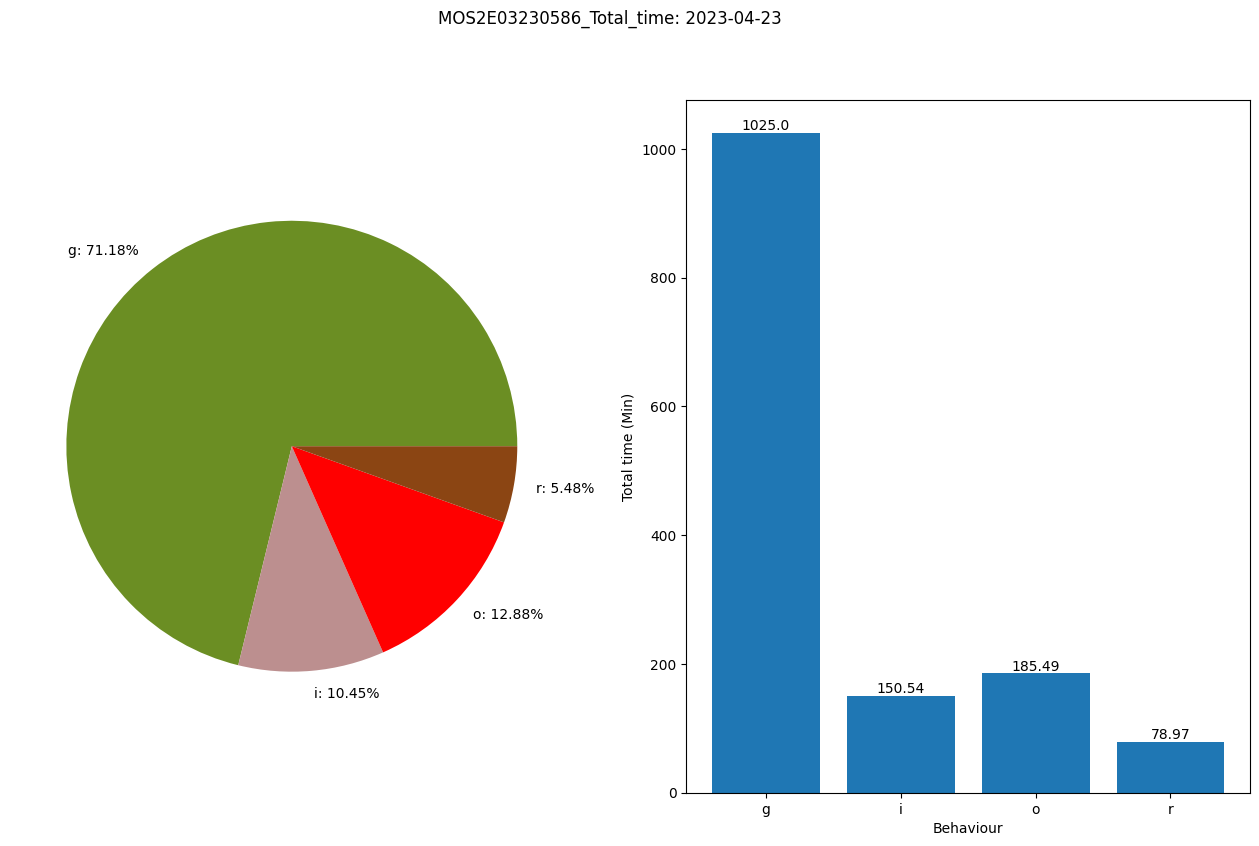

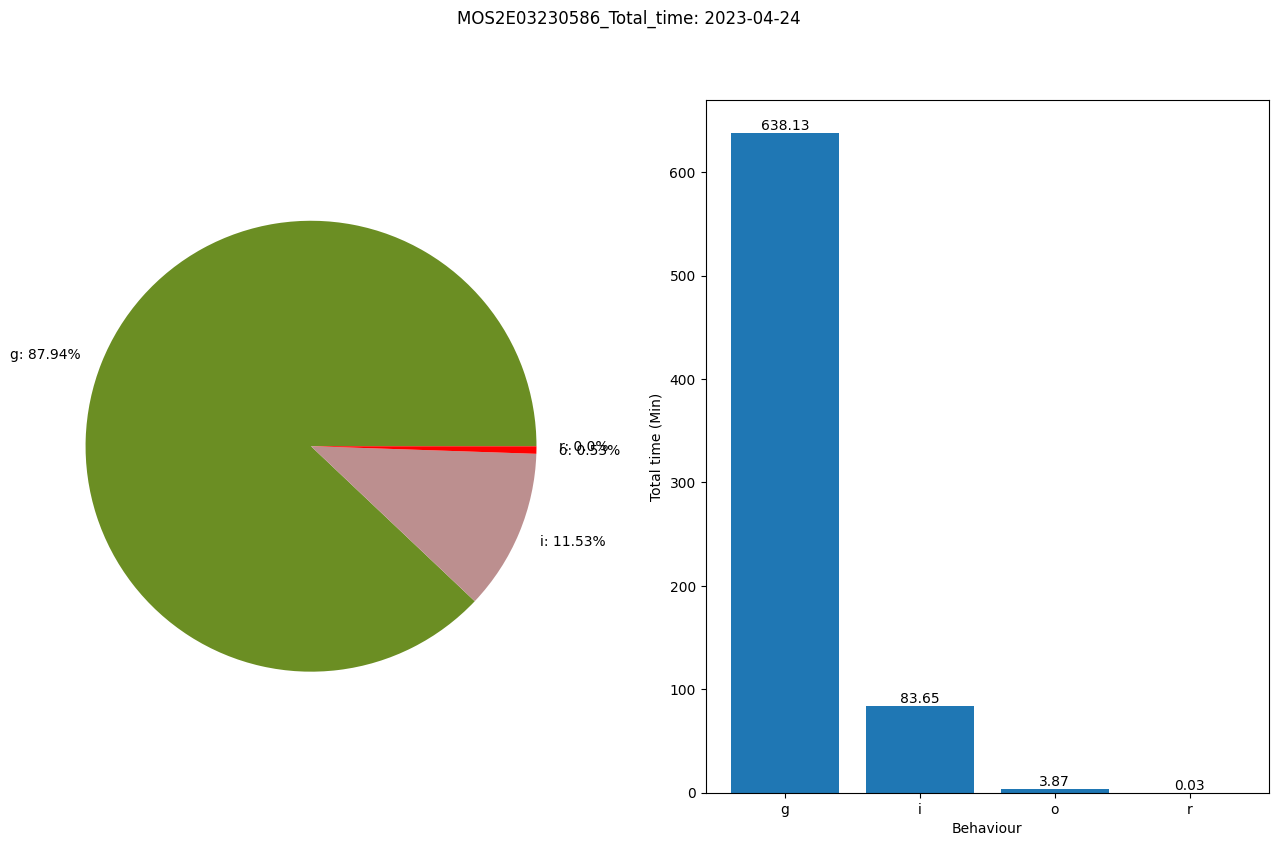

0

In [4]:
import gc


sensor_data: list[list[pandas.DataFrame]] = []
dated_df: list[pandas.DataFrame] = []
for sensor in sensor_dirs:
    files: list[str] = os.listdir(path="{}{}".format(INPUT_PATH, sensor))
    file: str = [f for f in files if f.endswith(".txt")][0]
    dated_df.clear()

    df: pandas.DataFrame = pandas.read_csv(
        filepath_or_buffer="{}{}/{}".format(INPUT_PATH, sensor, file),
        # nrows=10,
    )
    timestamps: pandas.DatetimeIndex = pandas.DatetimeIndex(df["timestamps"])
    days: pandas.Series = timestamps.date
    df["timestamps"] = days
    unique_days: list = list(df["timestamps"].unique())

    # 30 records = 1 second.
    labels: pandas.DataFrame = df.groupby(by=["predicted_labels"]).count().reset_index()
    labels = labels.rename(
        columns={labels.columns[-1]: "counts"},
        inplace=False,
    )
    labels[labels.columns[-1]] = labels[labels.columns[-1]] / (30 * 60)
    dated_df.append(labels)

    daily_labels: pandas.DataFrame = (
        df.groupby(by=["timestamps", "predicted_labels"]).size().reset_index()
    )
    daily_labels = daily_labels.rename(
        columns={daily_labels.columns[-1]: "counts"},
        inplace=False,
    )
    daily_labels["counts"] = daily_labels["counts"] / (30 * 60)

    for day in unique_days:
        d_df: pandas.DataFrame = daily_labels.loc[daily_labels["timestamps"] == day]
        dated_df.append(d_df)

    # sensor_data.append(dated_df)
    multiday_plotter(
        daily_sensor_df=dated_df,
        sensor_name=file.split("_")[0],
    )
    gc.collect()

len(sensor_data)